## Calibrating Tour Mode Choice
This script will iteratively perform updates to the tour mode choice coefficients config file in order to match model outputs to calibration targets.

### Load Libraries

In [70]:
import pandas as pd
import numpy as np
import os
# import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import importlib
import asim_calib_util
# check to make sure the dictionaries specifying names for calibration targets and activitysim outputs are consistent
importlib.reload(asim_calib_util)
asim_calib_util.check_input_dictionaries_for_consistency()

No problems found in input dictionaries


### Required Inputs
This script requires a working version of ActivitySim installed in the conda environment.  Input data sources are:
* Initial model output directory that includes household and tour files
* tour mode choice calibration target tables. Tables should be indexed by tour mode and columns should be auto sufficiency.  Tables should be broken down by tour purpose
* Model config directory containing the tour mode choice coefficients

Changes in tour modes and purposes can be implemented by changing the dictionaries at the top of asim_calib_util.py

In [2]:
# csv file containing calibration targets by tour mode choice.
# Column names and acceptable values should be set in dict at top of script
tour_mode_choice_calib_targets_file = r"C:\abm_runs\rohans\calibration\tour_mc\target\tour_mode_choice_calibration_targets.csv"

# directory of the simulation.py file
simpy_dir = r"C:\abm_runs\rohans"

# location of configuration files
settings_dir = r"C:\abm_runs\rohans\configs\resident\settings_mp.yaml"
configs_resident_dir = r"C:\abm_runs\rohans\configs\resident"
configs_common_dir = r"C:\abm_runs\rohans\configs\common"

warm_start_settings_mp_file = r"C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml"
cold_start_settings_mp_file = r"C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_cold_start.yaml"
tour_mc_coef_file = None #r"C:\abm_runs\rohans\calibration\tour_mc\Output\calibration_output_an_iter_PostAO\tour_mode_choice_coeffs.csv"

# input data location
data_dir = r"C:\abm_runs\rohans\input_2022"

# output location
output_dir = r"C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_cold"
activitysim_run_dir = r"C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir"

# calibration iterations
calibration_iterations_to_run = 5

# want to do intial model run first?
want_to_do_initial_model_run = True  # True or False

# calibration settings
max_ASC_adjust = 5 # maximum allowed adjustment per iteration
damping_factor = 1 # constant multiplied to all adjustments
adjust_when_zero_counts = 2 # coefficient change when have target counts but no model counts (or vise-versa)


--------------- User should not have to change anything below this line ----------------------

## Initial Model Run

In [3]:
### Change directory to model setup
### i.e. the location of simulation.py script
os.chdir(simpy_dir)

In [4]:
asim_calib_util.run_activitysim(
        data_dir=data_dir,  # data inputs for ActivitySim
        configs_resident_dir=configs_resident_dir,  # these files are copied to the config section of the run directory
        configs_common_dir=configs_common_dir,  # these files are copied to the config section of the run directory
        run_dir=activitysim_run_dir,  # ActivitySim run directory
        output_dir=output_dir,  # location to store run model outputs
        settings_file=cold_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
        tour_mc_coef_file=tour_mc_coef_file  # optional: tour_mode_choice_coefficients.csv to replace the one in configs_dir
    )

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_cold
ActivitySim run started at:  2023-09-12 19:08:58.079735
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_cold_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-12 20:39:44.770760
Run Time:  5446.69 secs =  90.77816666666666  mins


Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

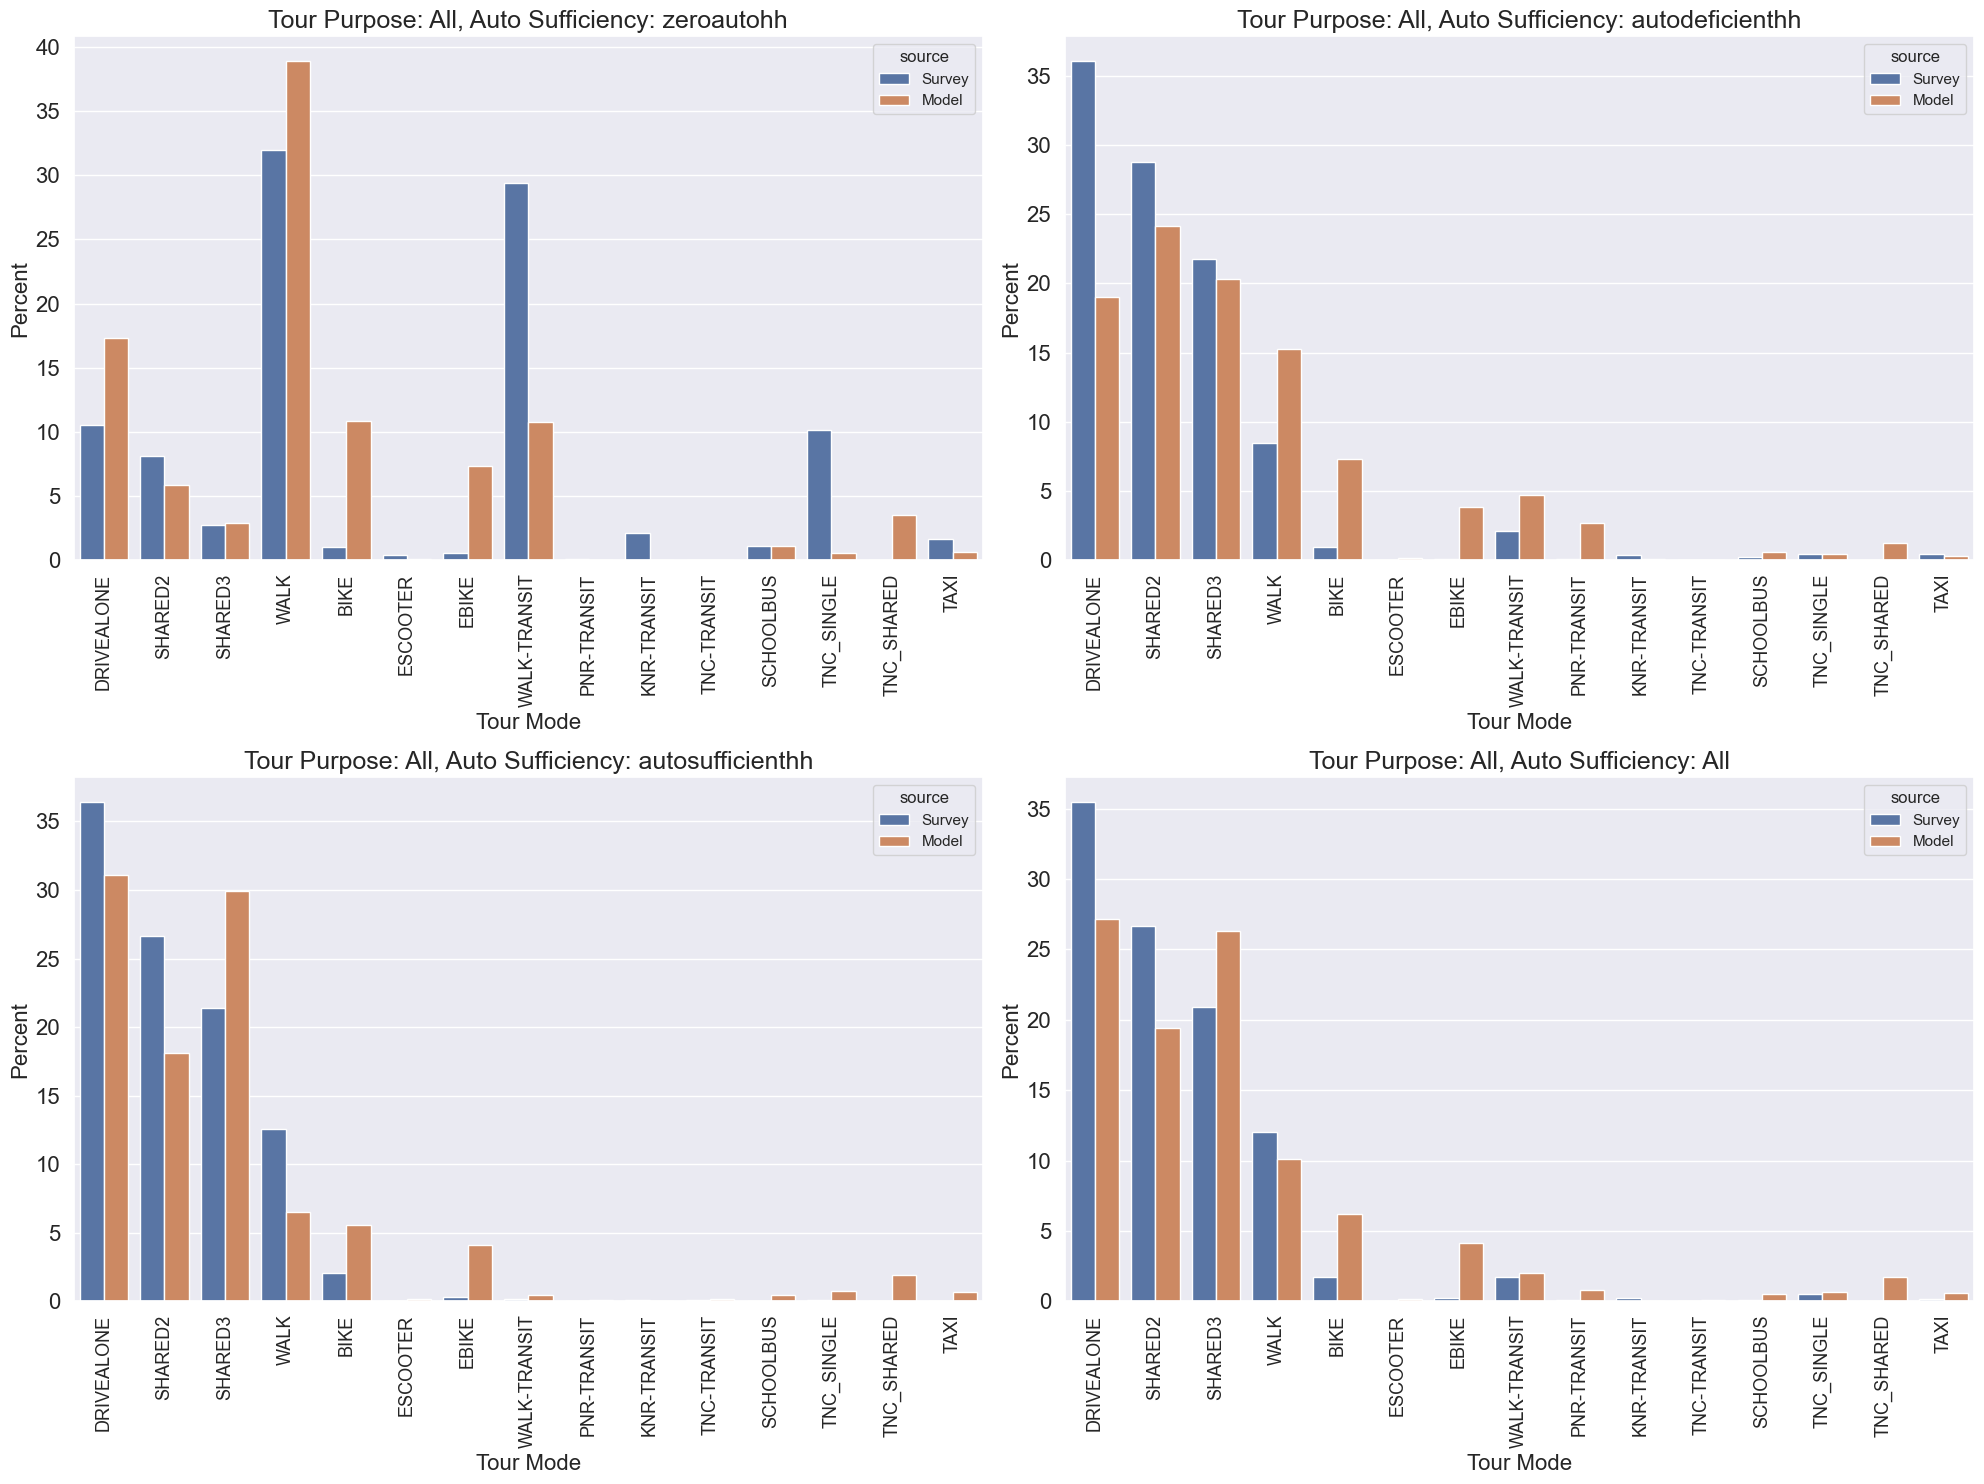

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 218 coefficients adjusted
	 550 coefficients converged
	 207 coefficients not converged


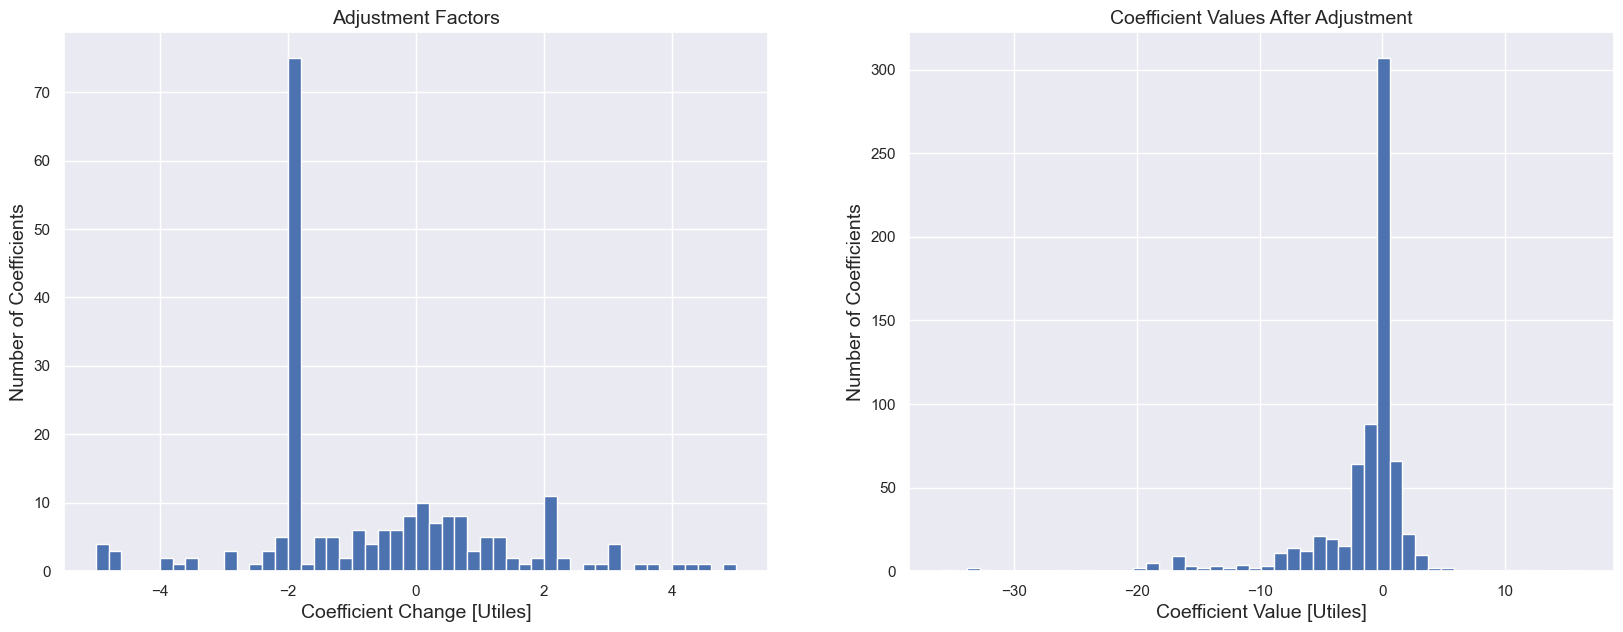

Top 10 largest coefficients:


coefficient_name      value  \
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -35.934870   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -31.390562   
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -30.865285   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -30.496907   
542          coef_calib_zeroautohhindivtou_WALK_atwork -27.908265   
471            coef_calib_zeroautohhindivtou_WALK_univ -23.883300   
468     #coef_calib_zeroautohhindivtou_DRIVEALONE_univ -19.706400   
671   coef_calib_autodeficienthhjoi_WALK_TRANSIT_maint -14.842518   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -16.970666   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -16.970666   

     model_counts  target_counts coef_change  new_value  converged  
541           0.0            0.0        <NA> -35.934870       True  
543        1060.0            0.0          -2 -33.390562      False  
540         327.0            0.0          -2 -32.865285      False  
544         124.0           29.0   -1.452986 -31.949893       True  
542         590.0         5313.0    2.197789 -25.710476      False  
471           0.0            0.0        <NA> -23.883300       True  
468           NaN            NaN        <NA> -19.706400       True  
671        4490.0           42.0   -4.671938 -19.514456      False  
677        5916.0            0.0          -2 -18.970666      False  
676        1813.0            0.0          -2 -18.970666      False

In [5]:
_ = asim_calib_util.perform_tour_mode_choice_model_calibration(
        asim_output_dir=output_dir, # folder containing the activitysim model output
        asim_configs_dir=configs_resident_dir,  # folder containing activitysim tour mode choice config files
        tour_mode_choice_calib_targets_file=tour_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=output_dir,  # location to write model calibration steps
    )
tour_mc_coef_file = os.path.join(output_dir, 'tour_mode_choice_coefficients.csv') 

In [6]:
# if want_to_do_initial_model_run:
#     asim_calib_util.run_activitysim(
#         data_dir=data_dir,  # data inputs for ActivitySim
#         configs_resident_dir=configs_resident_dir,  # these files are copied to the config section of the run directory
#         configs_common_dir=configs_common_dir,  # just the location of the common config, these files will be used from the original location
#         run_dir=activitysim_run_dir,  # ActivitySim run directory
#         output_dir=output_dir,  # location to store run model outputs
#         settings_file=cold_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
#         tour_mc_coef_file=tour_mc_coef_file  # optional: tour_mode_choice_coefficients.csv to replace the one in configs_dir
#     )
    
#     _ = asim_calib_util.perform_tour_mode_choice_model_calibration(
#         asim_output_dir=output_dir, # folder containing the activitysim model output
#         asim_configs_dir=configs_resident_dir,  # folder containing activitysim tour mode choice config files
#         tour_mode_choice_calib_targets_file=tour_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
#         max_ASC_adjust=max_ASC_adjust,  
#         damping_factor=damping_factor,  # constant multiplied to all adjustments
#         adjust_when_zero_counts=adjust_when_zero_counts,
#         output_dir=output_dir,  # location to write model calibration steps
#     )
#     tour_mc_coef_file = os.path.join(output_dir, 'tour_mode_choice_coefficients.csv') 
# else:
#     print("No initial model run performed.")

    

## Iterating

In [7]:
# tour_mc_coef_file = os.path.join(output_dir, 'tour_mode_choice_coefficients.csv')
# tour_mc_coef_file

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_1
ActivitySim run started at:  2023-09-12 22:48:37.096980
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-12 23:35:29.558125
Run Time:  2812.46 secs =  46.87433333333333  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

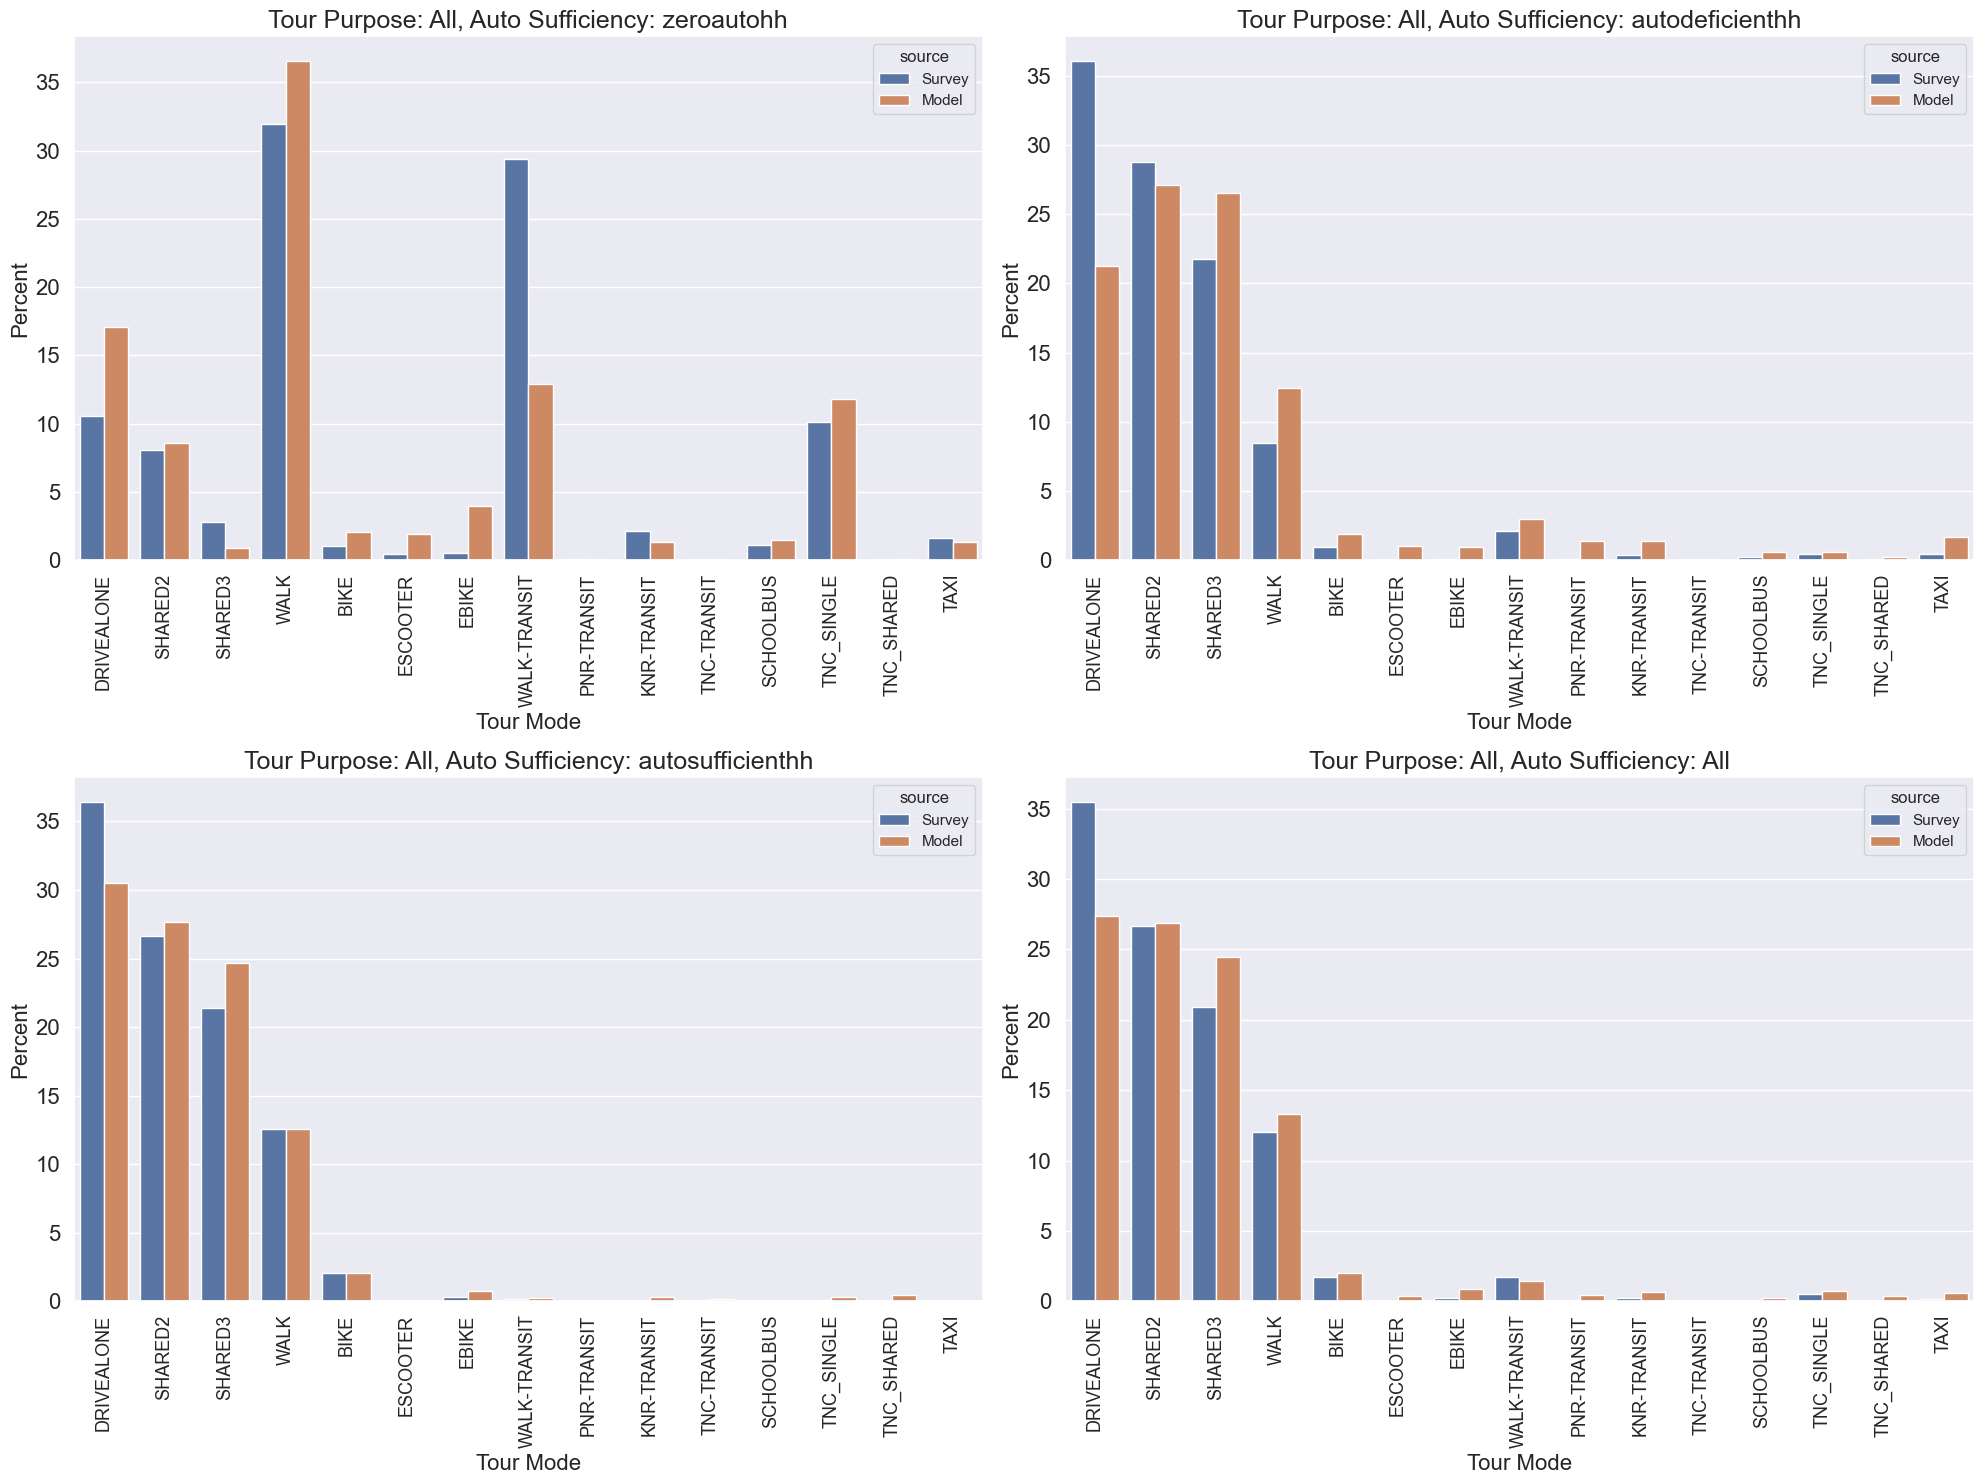

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 214 coefficients adjusted
	 567 coefficients converged
	 190 coefficients not converged


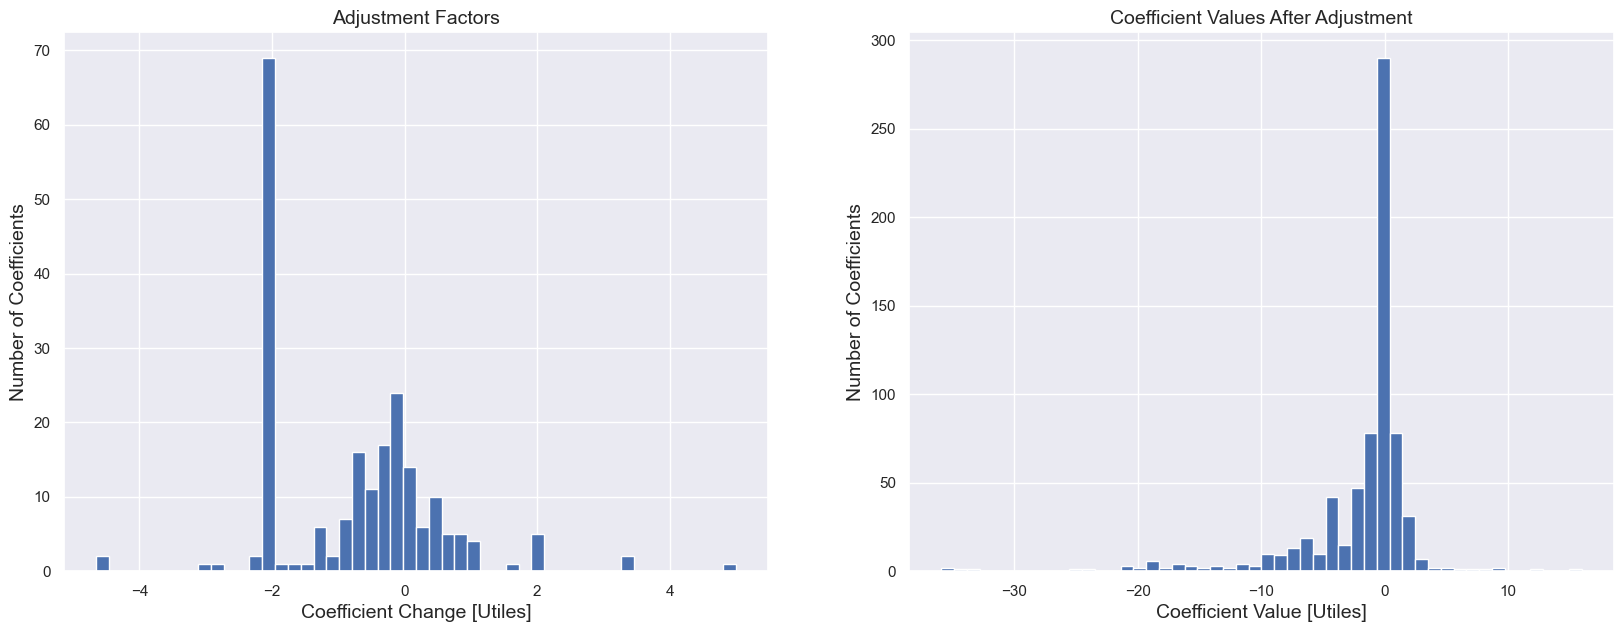

Top 10 largest coefficients:


coefficient_name      value  \
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -35.934870   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -33.390562   
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -32.865285   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -31.949893   
542          coef_calib_zeroautohhindivtou_WALK_atwork -25.710476   
471            coef_calib_zeroautohhindivtou_WALK_univ -23.883300   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -18.970666   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -18.970666   
675           coef_calib_autodeficienthhjoi_TAXI_maint -18.970666   
671   coef_calib_autodeficienthhjoi_WALK_TRANSIT_maint -19.514456   

     model_counts  target_counts coef_change  new_value  converged  
541           0.0            0.0        <NA> -35.934870       True  
543         255.0            0.0          -2 -35.390562      False  
540         175.0            0.0          -2 -34.865285      False  
544         100.0           29.0   -1.237874 -33.187767       True  
542        1777.0         5313.0     1.09523 -24.615246      False  
471           0.0            0.0        <NA> -23.883300       True  
676         602.0            0.0          -2 -20.970666      False  
677        1574.0            0.0          -2 -20.970666      False  
675         335.0            0.0          -2 -20.970666      False  
671          72.0           42.0   -0.538997 -20.053453       True



 Final coefficient table written to:  C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_1\tour_mode_choice_coefficients.csv


In [8]:
iteration_output_dir = output_dir.strip('_cold') + '_1'

calibration_iterations_to_run = 1
start_iter_num = 1

for i in range(start_iter_num, calibration_iterations_to_run+start_iter_num):
    asim_calib_util.run_activitysim(
        data_dir=data_dir,  # data inputs for ActivitySim
        configs_resident_dir=configs_resident_dir,  # these files are copied to the config section of the run directory
        configs_common_dir=configs_common_dir,  # just the location of the common config, these files will be used from the original location
        run_dir=activitysim_run_dir,  # ActivitySim run directory
        output_dir=iteration_output_dir,  # location to store run model outputs
        settings_file=warm_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
        tour_mc_coef_file=tour_mc_coef_file  # optional: tour_mode_choice_coefficients.csv to replace the one in configs_dir
    )
    
    _ = asim_calib_util.perform_tour_mode_choice_model_calibration(
        asim_output_dir=iteration_output_dir, # folder containing the activitysim model output
        asim_configs_dir=os.path.join(activitysim_run_dir, 'configs'),  # folder containing activitysim tour mode choice config files
        tour_mode_choice_calib_targets_file=tour_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  # maximum allowed adjustment per iteration
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=iteration_output_dir,  # location to write model calibration steps
    )
    tour_mc_coef_file = os.path.join(iteration_output_dir, 'tour_mode_choice_coefficients.csv')
    iteration_output_dir = iteration_output_dir.strip('_'+str(i)) + '_' + str(i+1)

print("\n\n", "Final coefficient table written to: ", tour_mc_coef_file)

In [29]:
print(tour_mc_coef_file)
print(iteration_output_dir)

C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_1\tour_mode_choice_coefficients.csv
C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_2


creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_2
ActivitySim run started at:  2023-09-13 00:32:40.676421
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-13 01:19:29.017960
Run Time:  2808.34 secs =  46.80566666666667  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

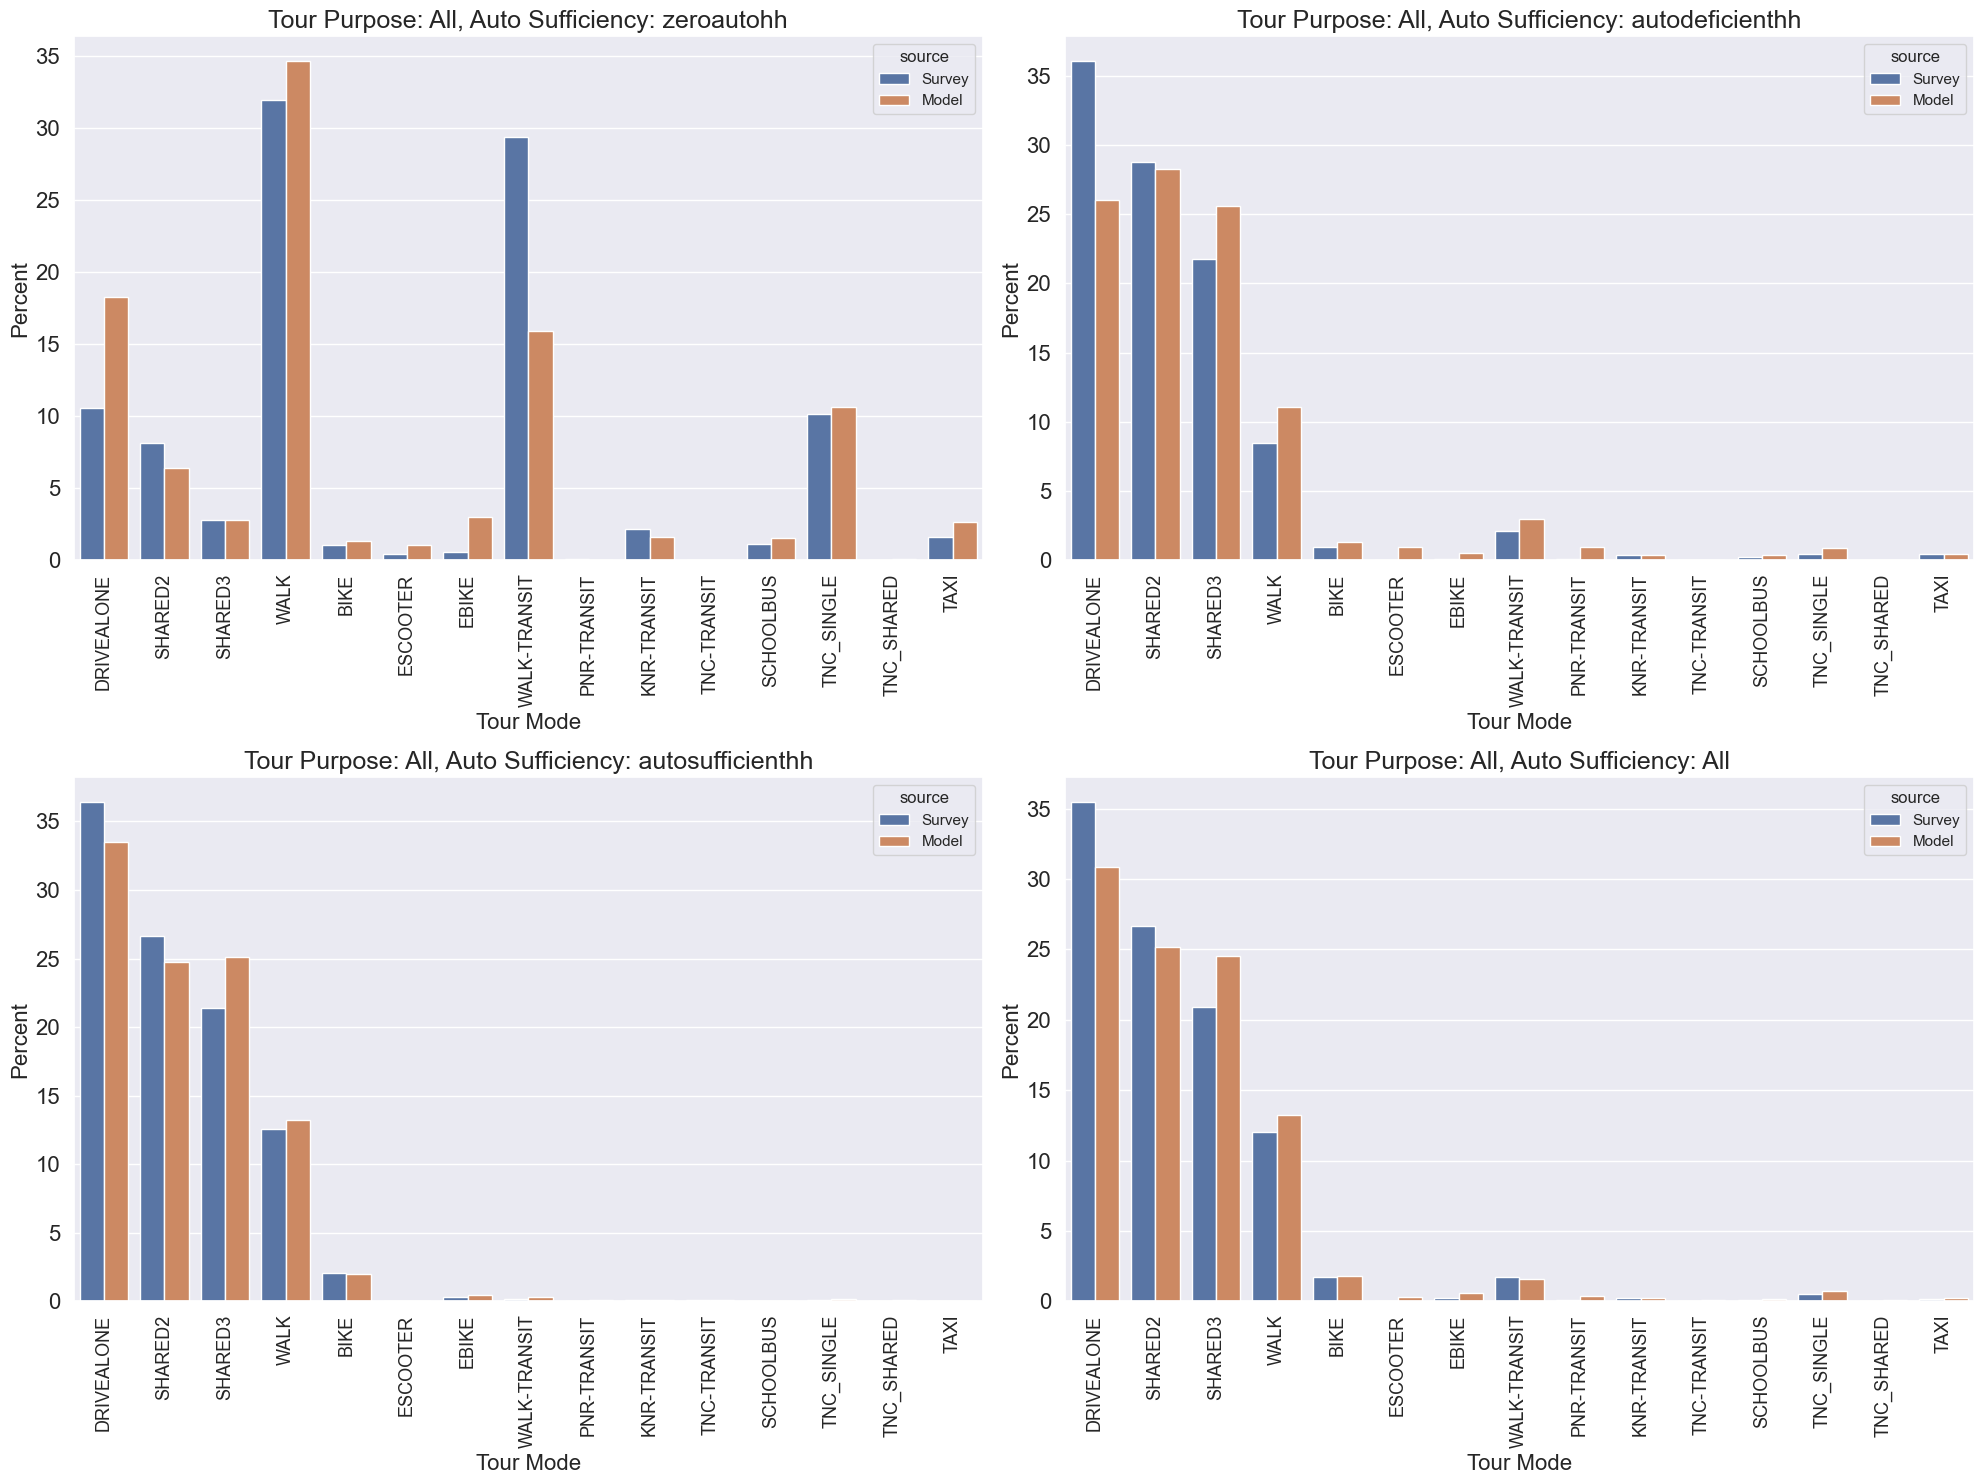

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 191 coefficients adjusted
	 609 coefficients converged
	 148 coefficients not converged


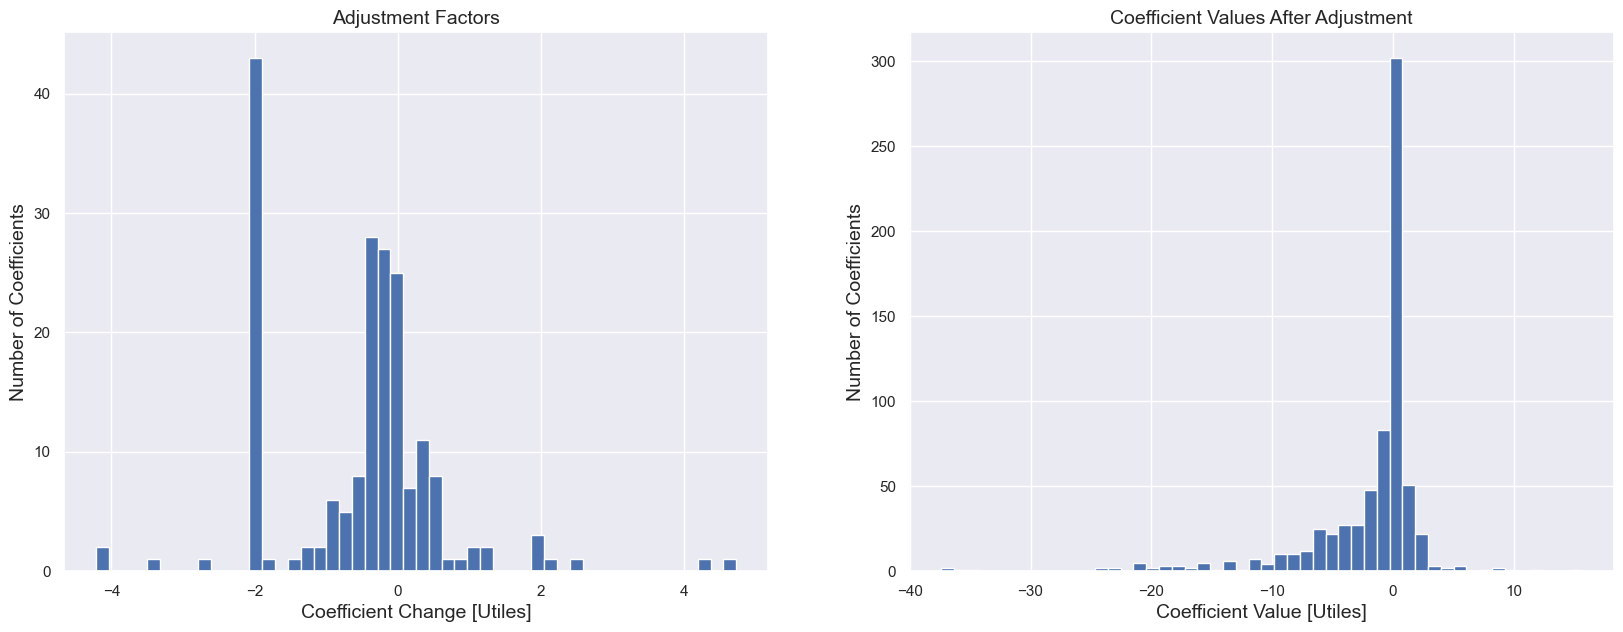

Top 10 largest coefficients:


coefficient_name      value  \
543          coef_calib_zeroautohhindivtou_BIKE_atwork -35.390562   
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -34.865285   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -35.934870   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -33.187767   
471            coef_calib_zeroautohhindivtou_WALK_univ -23.883300   
542          coef_calib_zeroautohhindivtou_WALK_atwork -24.615246   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -20.970666   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -20.970666   
675           coef_calib_autodeficienthhjoi_TAXI_maint -20.970666   
671   coef_calib_autodeficienthhjoi_WALK_TRANSIT_maint -20.053453   

     model_counts  target_counts coef_change  new_value  converged  
543         127.0            0.0          -2 -37.390562      False  
540         143.0            0.0          -2 -36.865285      False  
541           0.0            0.0        <NA> -35.934870       True  
544         112.0           29.0   -1.351203 -34.538970       True  
471           0.0            0.0        <NA> -23.883300       True  
542        1984.0         5313.0    0.985042 -23.630204      False  
677         386.0            0.0          -2 -22.970666      False  
676         203.0            0.0          -2 -22.970666      False  
675          92.0            0.0        <NA> -20.970666       True  
671         100.0           42.0   -0.867501 -20.920953       True

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_3
ActivitySim run started at:  2023-09-13 01:20:03.956510
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-13 02:05:31.639605
Run Time:  2727.68 secs =  45.46133333333333  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

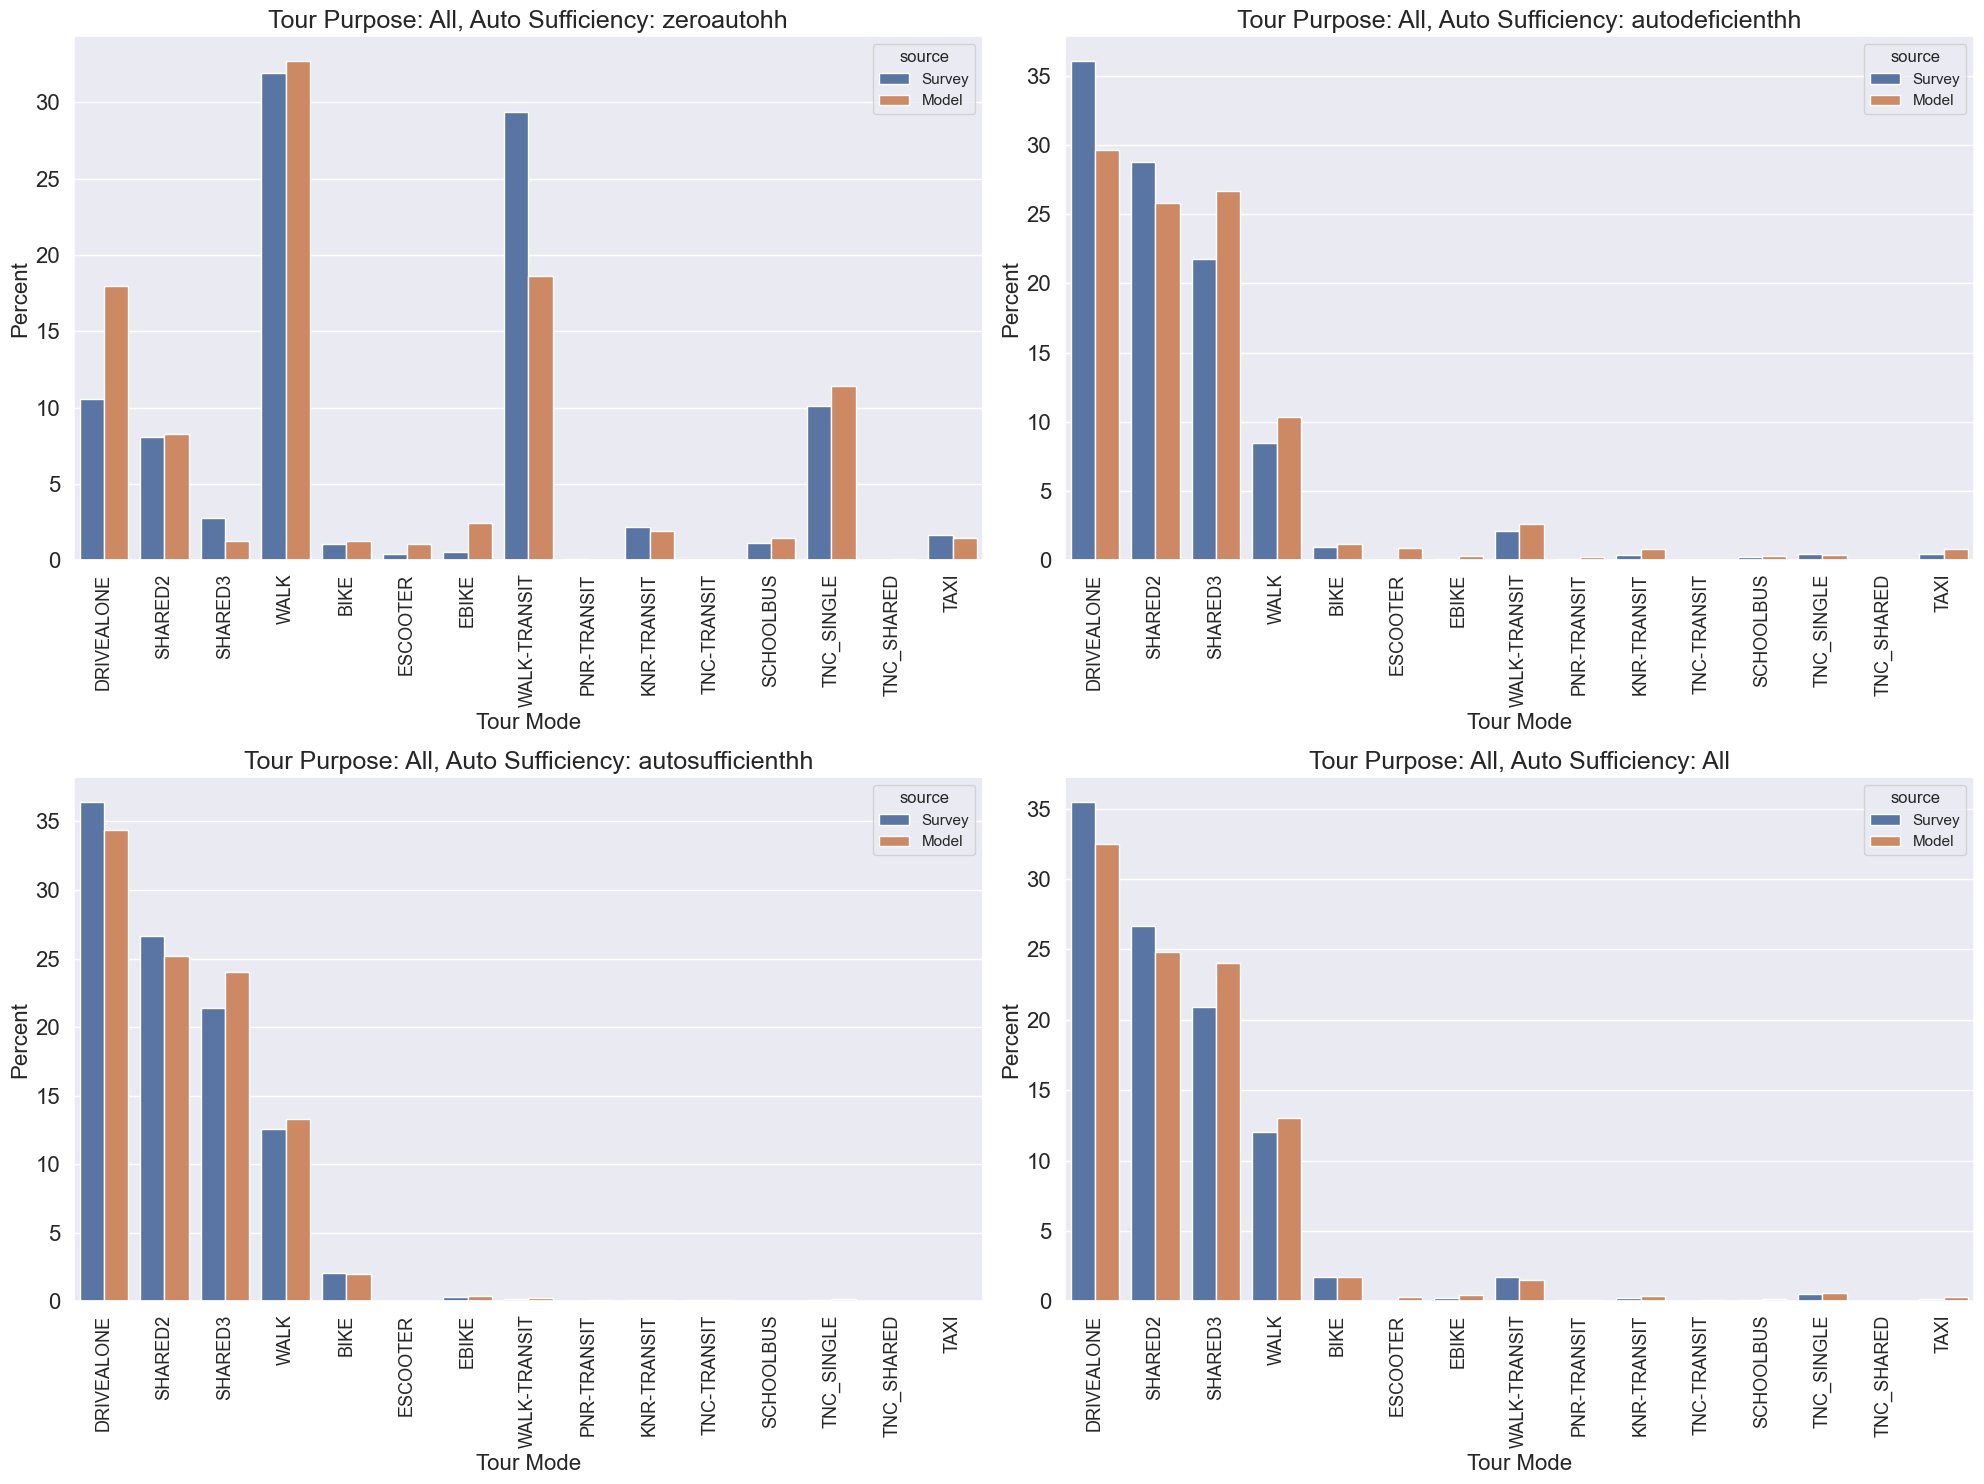

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 183 coefficients adjusted
	 622 coefficients converged
	 135 coefficients not converged


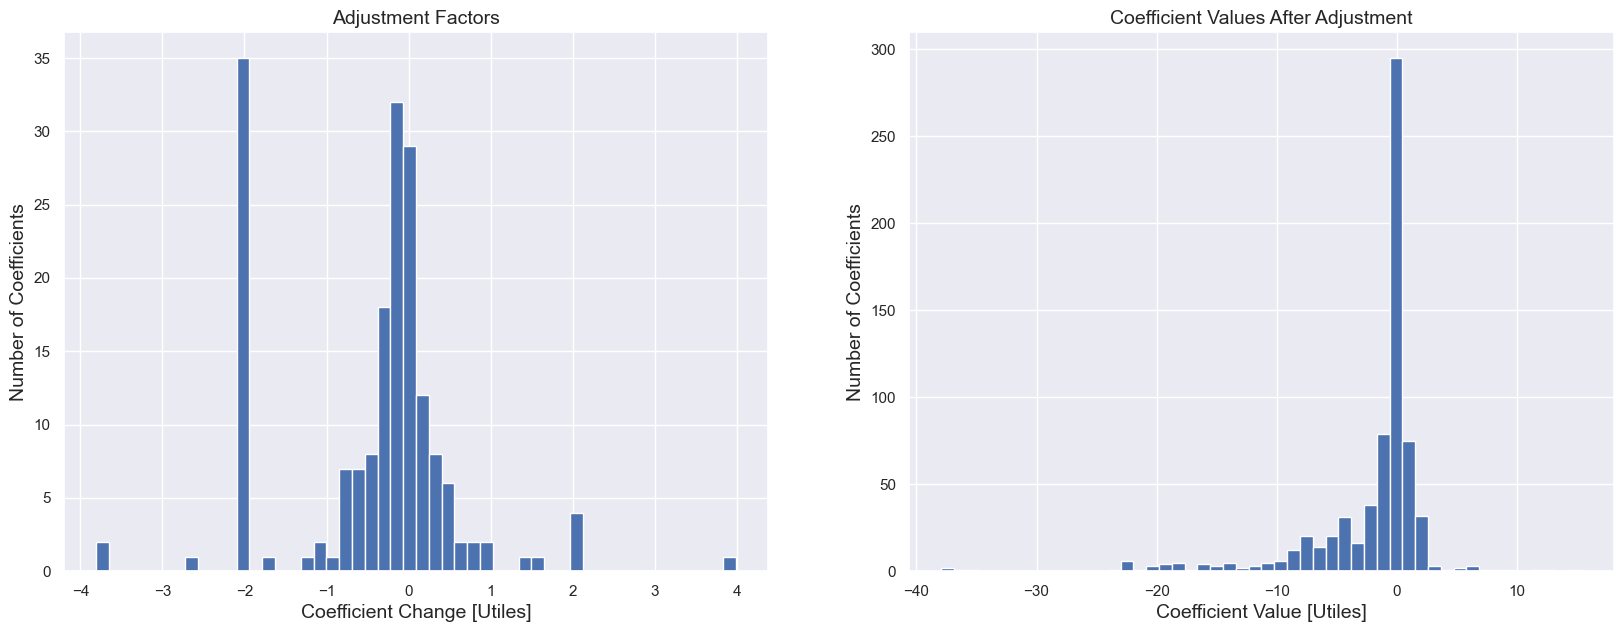

Top 10 largest coefficients:


coefficient_name      value  \
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -35.934870   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -37.390562   
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -36.865285   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -34.538970   
471            coef_calib_zeroautohhindivtou_WALK_univ -23.883300   
675           coef_calib_autodeficienthhjoi_TAXI_maint -20.970666   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -22.970666   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -22.970666   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -20.875688   
542          coef_calib_zeroautohhindivtou_WALK_atwork -23.630204   

     model_counts  target_counts coef_change  new_value  converged  
541         131.0            0.0          -2 -37.934870      False  
543          68.0            0.0        <NA> -37.390562       True  
540          16.0            0.0        <NA> -36.865285       True  
544          96.0           29.0   -1.197052 -35.736022       True  
471           0.0            0.0        <NA> -23.883300       True  
675         335.0            0.0          -2 -22.970666      False  
676          28.0            0.0        <NA> -22.970666       True  
677          88.0            0.0        <NA> -22.970666       True  
698         203.0            0.0          -2 -22.875688      False  
542        1992.0         5313.0    0.981017 -22.649186      False

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_4
ActivitySim run started at:  2023-09-13 02:06:05.703048
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-13 02:51:13.815844
Run Time:  2708.11 secs =  45.13516666666667  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

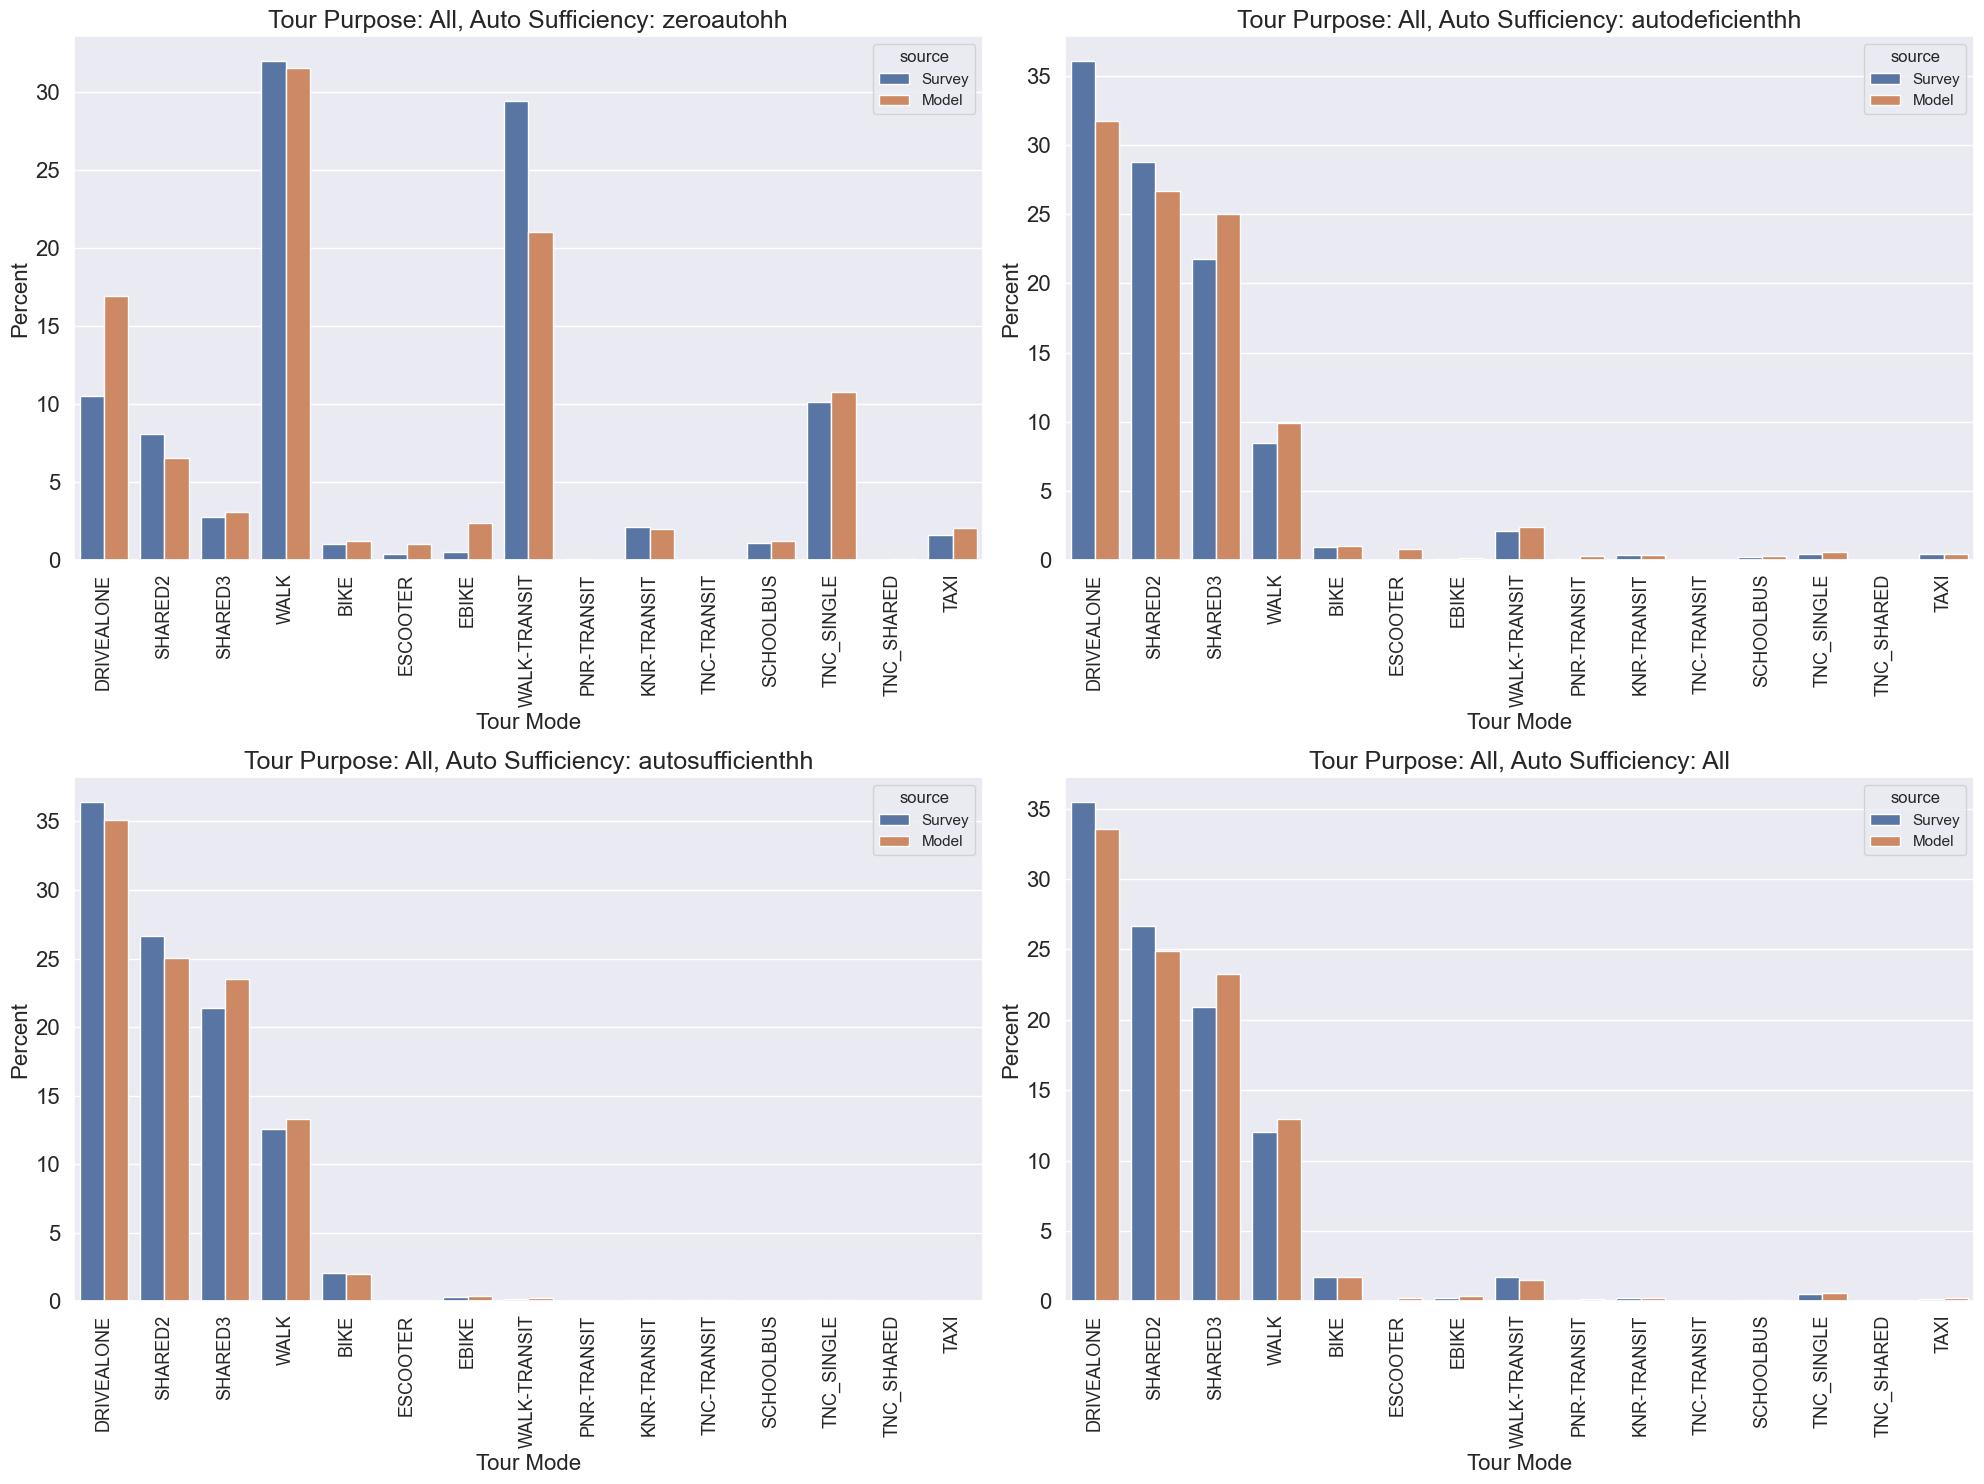

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 184 coefficients adjusted
	 637 coefficients converged
	 120 coefficients not converged


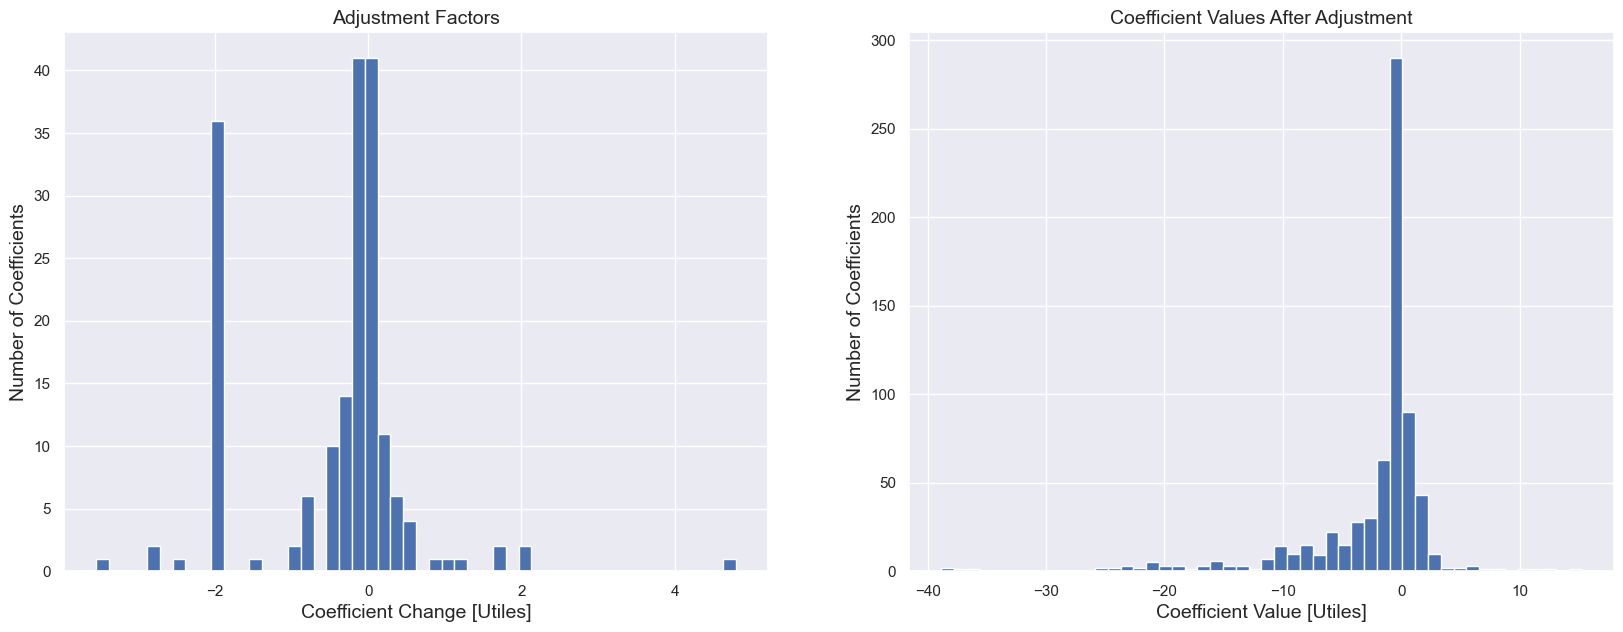

Top 10 largest coefficients:


coefficient_name      value  \
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -36.865285   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -37.934870   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -37.390562   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -35.736022   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -22.970666   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -22.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -22.246255   
471            coef_calib_zeroautohhindivtou_WALK_univ -23.883300   
675           coef_calib_autodeficienthhjoi_TAXI_maint -22.970666   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -22.970666   

     model_counts  target_counts coef_change  new_value  converged  
540         131.0            0.0          -2 -38.865285      False  
541           0.0            0.0        <NA> -37.934870       True  
543         100.0            0.0        <NA> -37.390562       True  
544          72.0           29.0    -0.90937 -36.645393       True  
677         219.0            0.0          -2 -24.970666      False  
698         159.0            0.0          -2 -24.875688      False  
695         124.0            0.0          -2 -24.246255      False  
471           0.0            0.0        <NA> -23.883300       True  
675          32.0            0.0        <NA> -22.970666       True  
676          60.0            0.0        <NA> -22.970666       True

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_5
ActivitySim run started at:  2023-09-13 02:51:44.198650
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-13 03:38:29.700390
Run Time:  2805.5 secs =  46.75833333333333  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

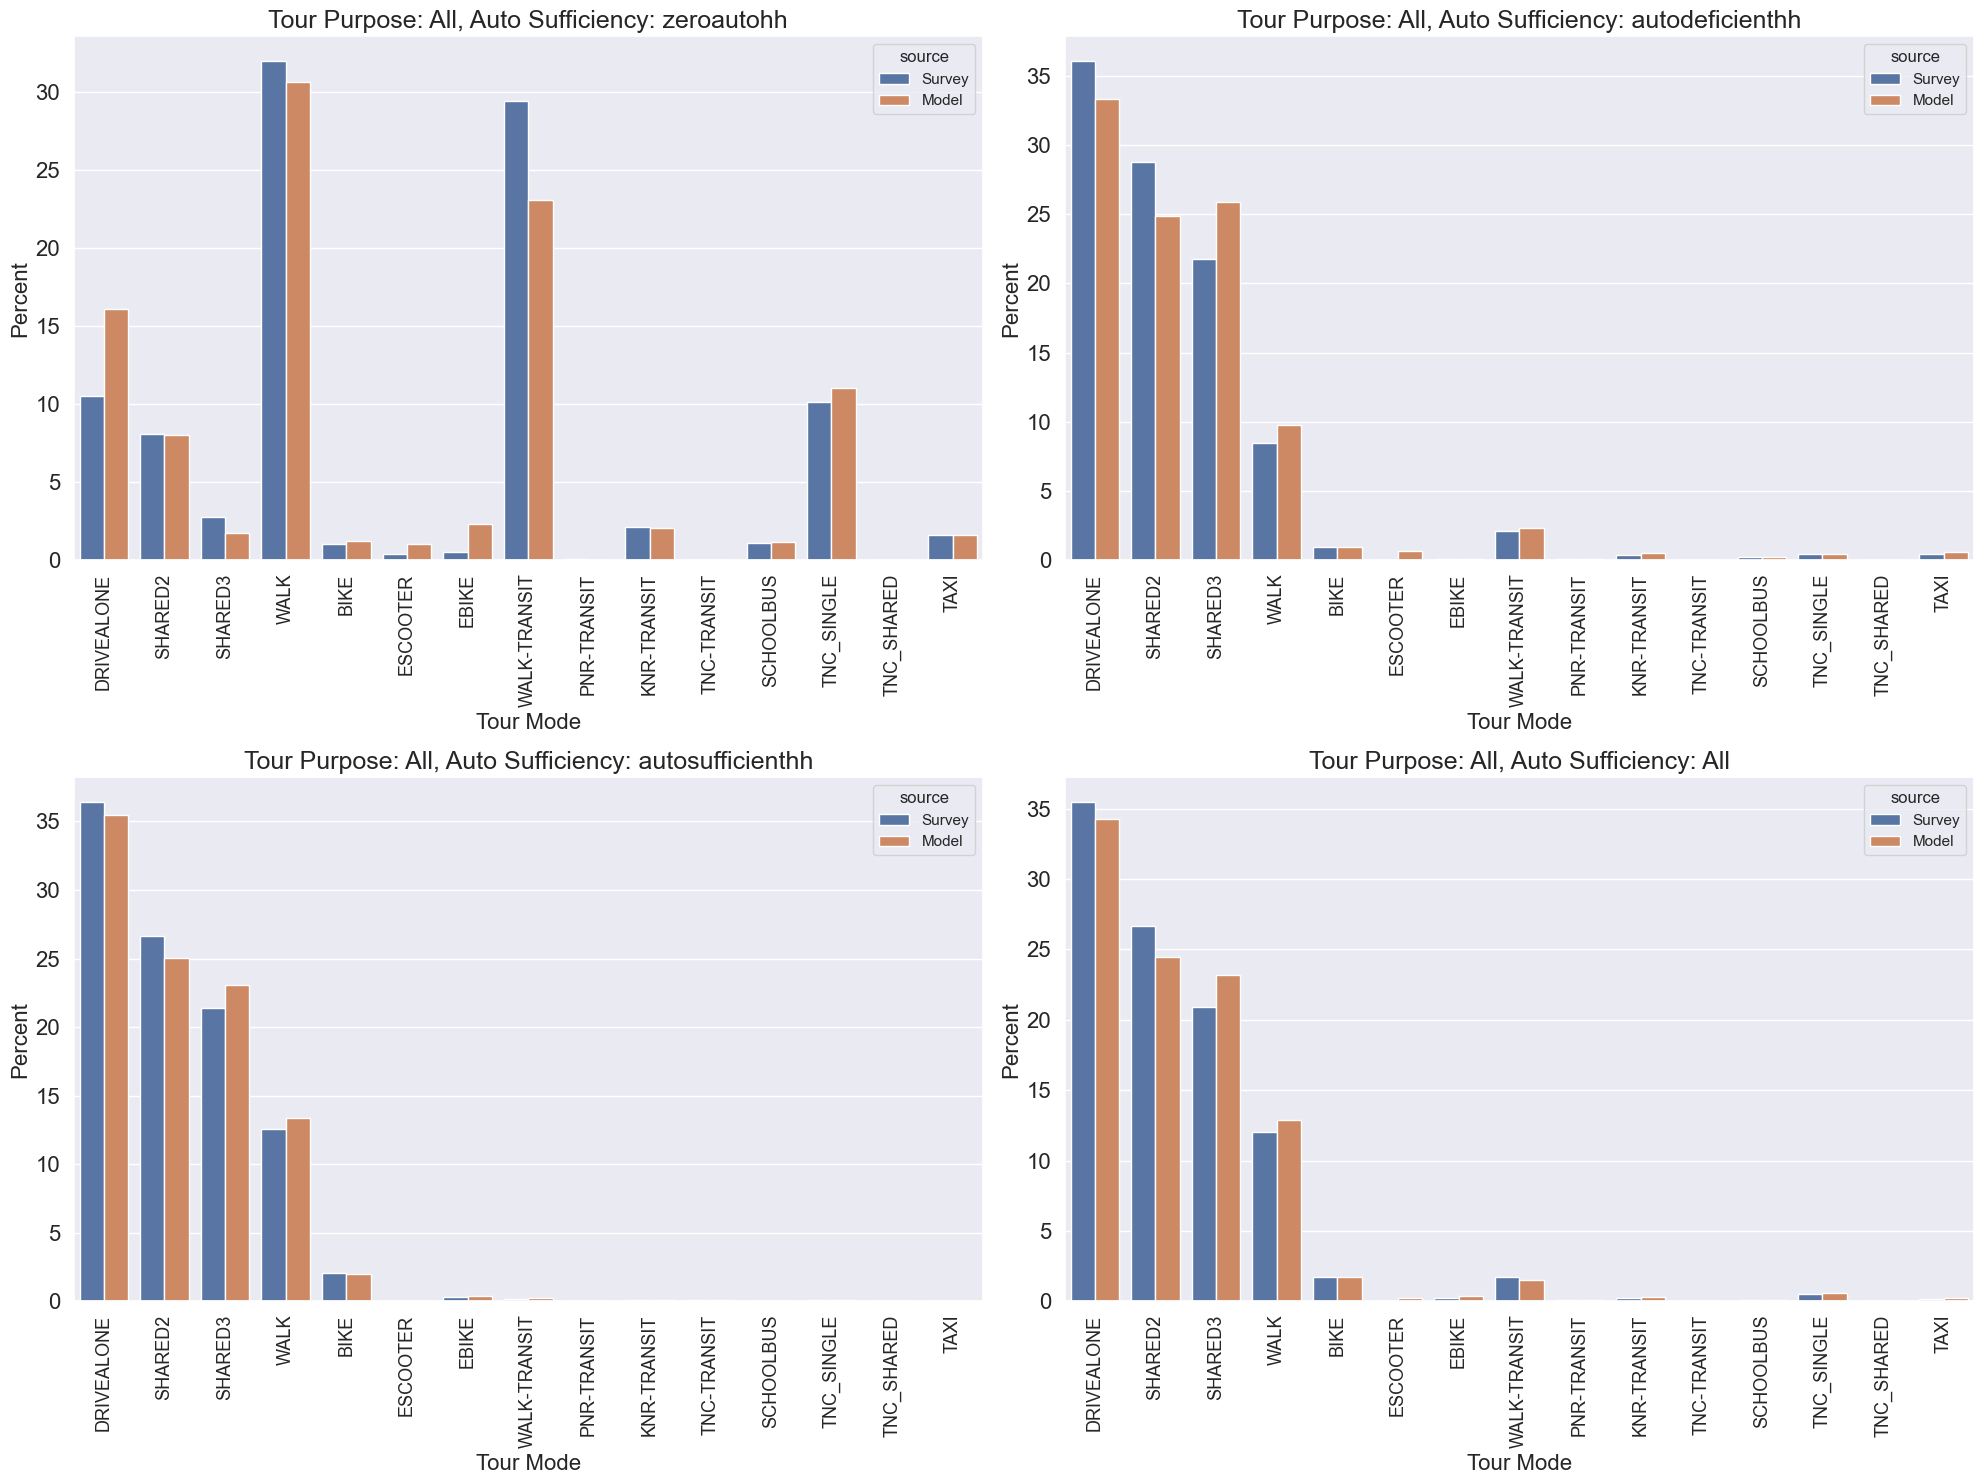

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 179 coefficients adjusted
	 658 coefficients converged
	 99 coefficients not converged


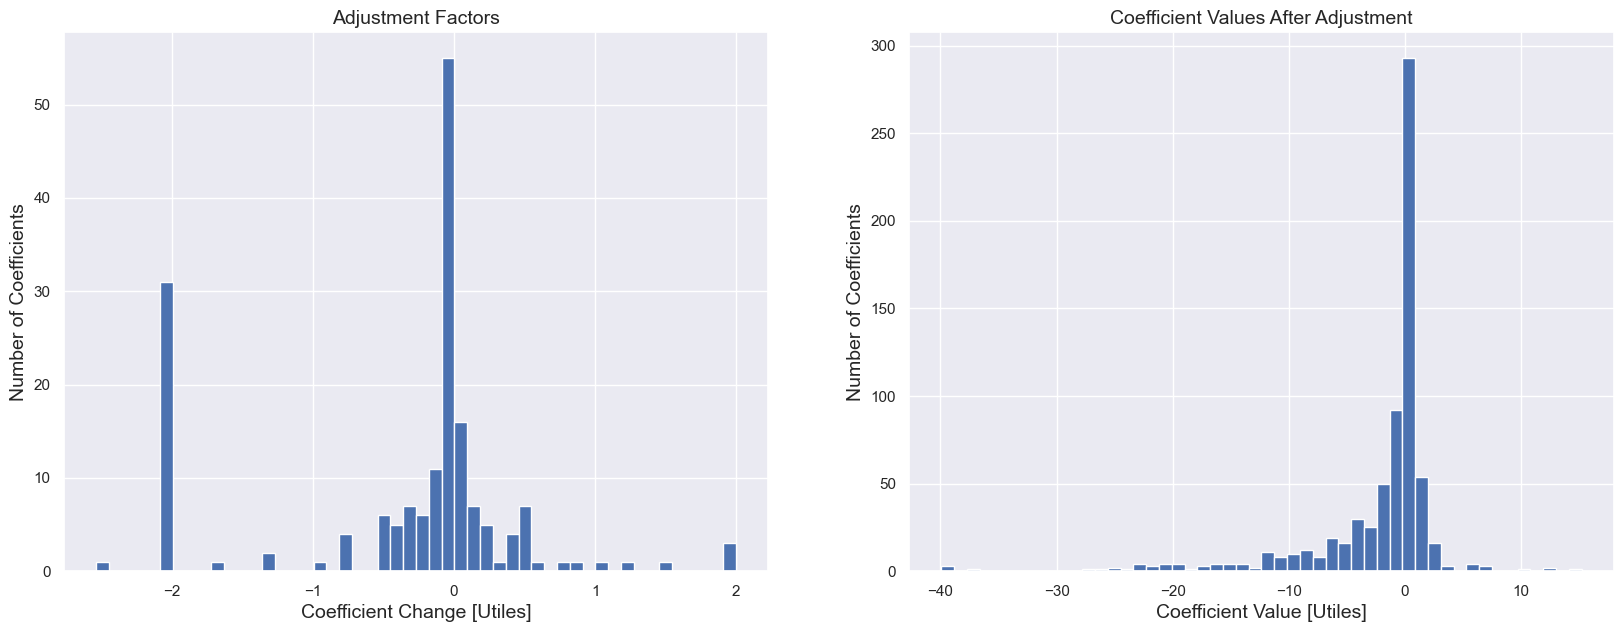

Top 10 largest coefficients:


coefficient_name      value  \
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -37.934870   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -37.390562   
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -38.865285   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -36.645393   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -24.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -24.246255   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -22.970666   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -24.970666   
471            coef_calib_zeroautohhindivtou_WALK_univ -23.883300   
675           coef_calib_autodeficienthhjoi_TAXI_maint -22.970666   

     model_counts  target_counts coef_change  new_value  converged  
541         108.0            0.0          -2 -39.934870      False  
543         108.0            0.0          -2 -39.390562      False  
540           8.0            0.0        <NA> -38.865285       True  
544          60.0           29.0   -0.727049 -37.372441       True  
698         139.0            0.0          -2 -26.875688      False  
695         116.0            0.0          -2 -26.246255      False  
676         219.0            0.0          -2 -24.970666      False  
677          20.0            0.0        <NA> -24.970666       True  
471           0.0            0.0        <NA> -23.883300       True  
675          68.0            0.0        <NA> -22.970666       True

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_6
ActivitySim run started at:  2023-09-13 03:38:57.140971
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-13 04:26:17.760735
Run Time:  2840.62 secs =  47.343666666666664  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

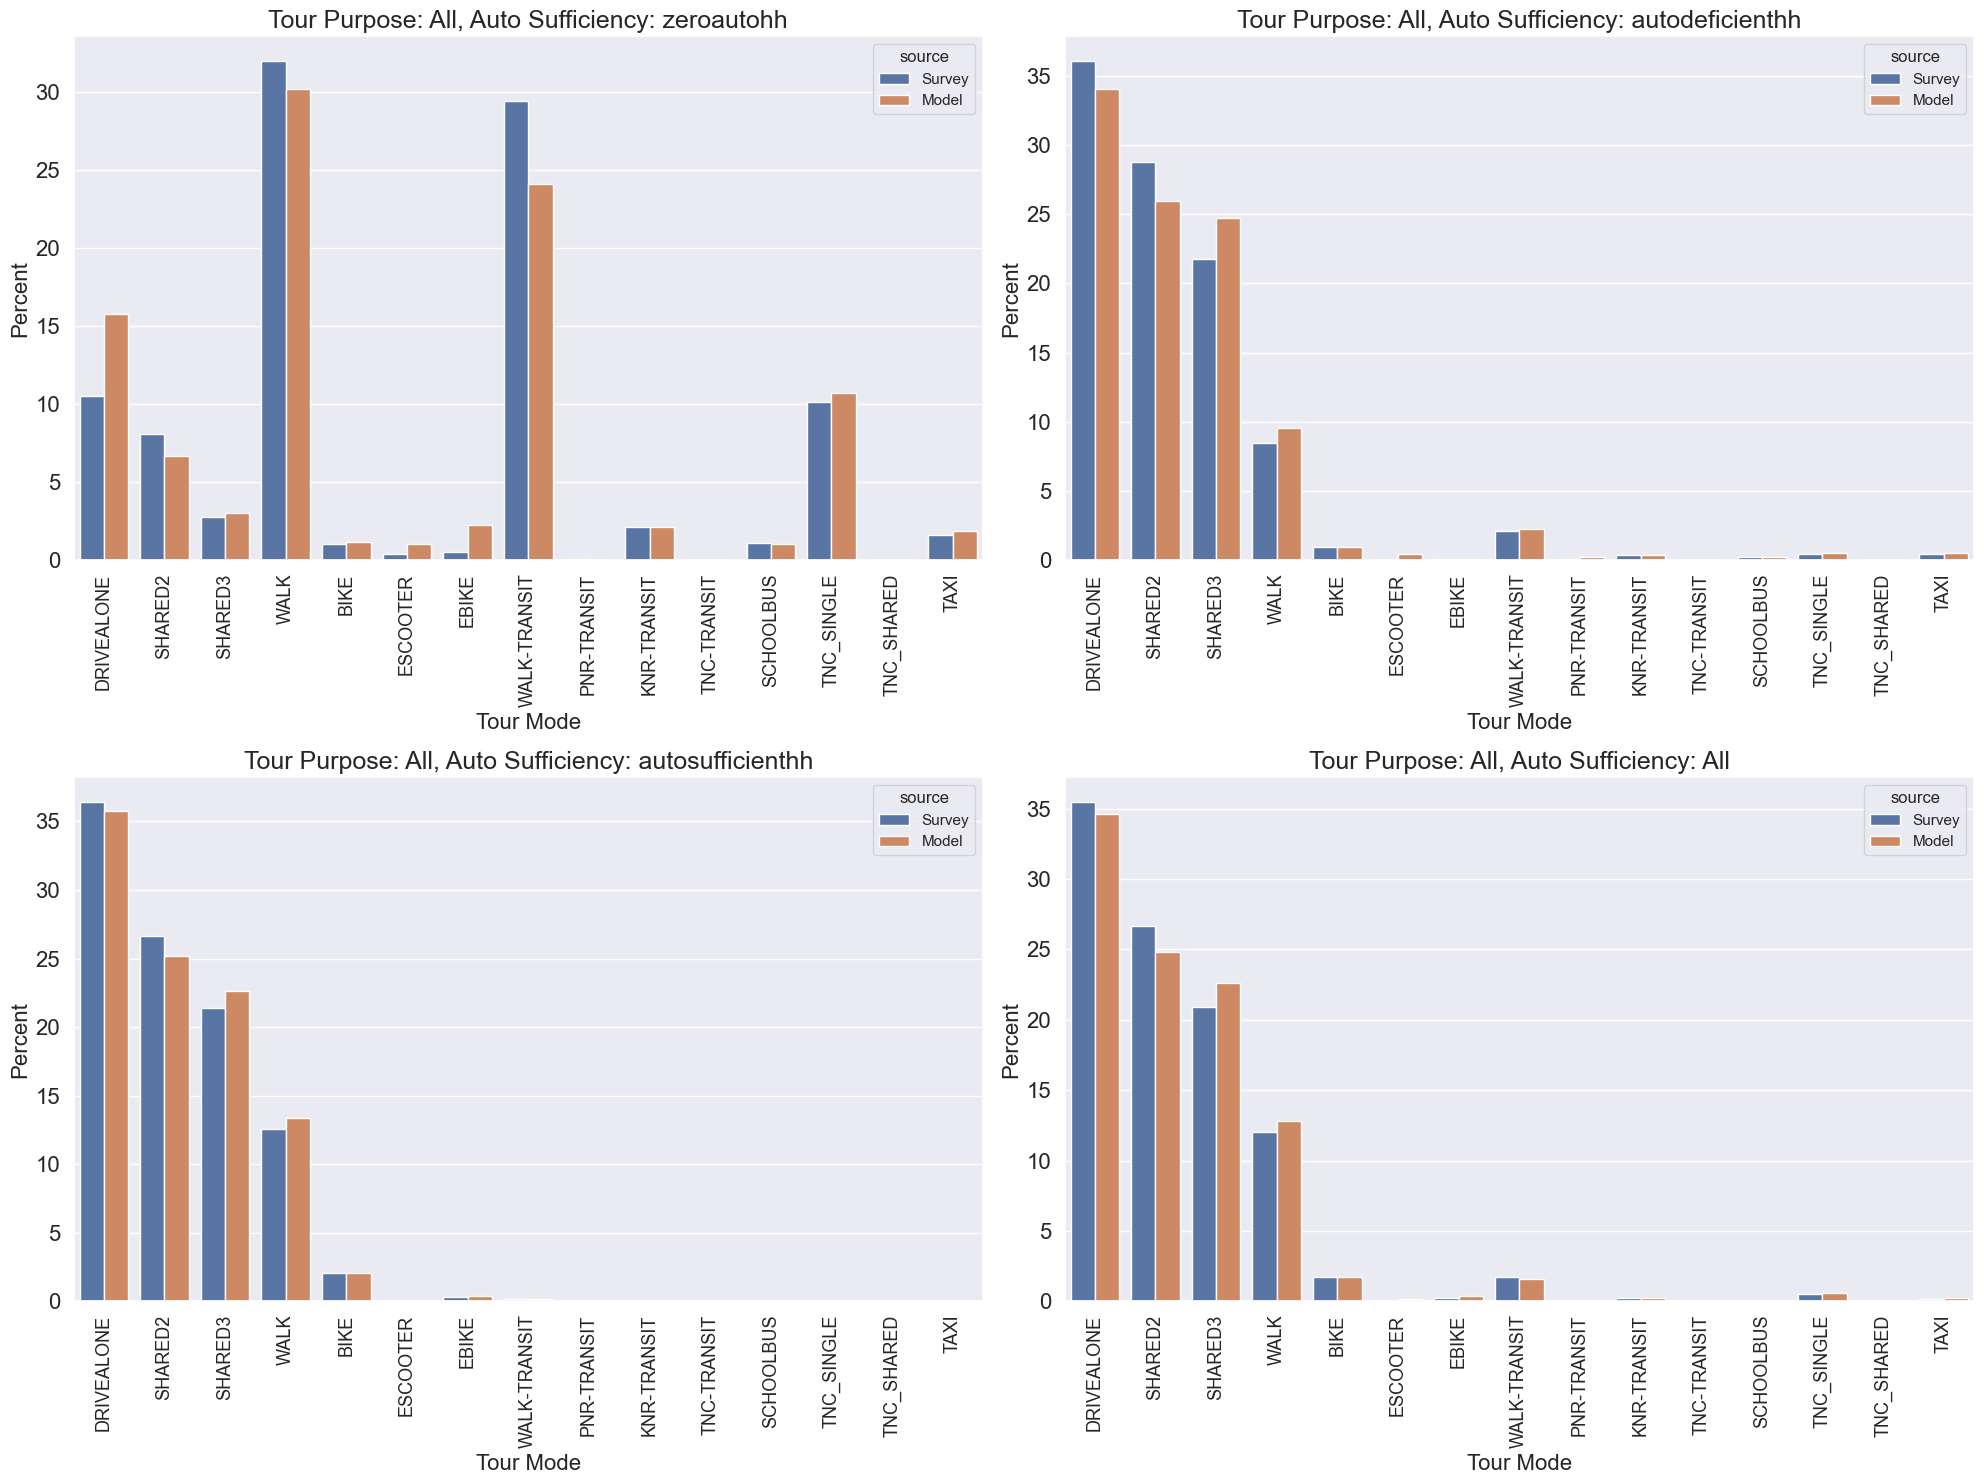

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 177 coefficients adjusted
	 670 coefficients converged
	 87 coefficients not converged


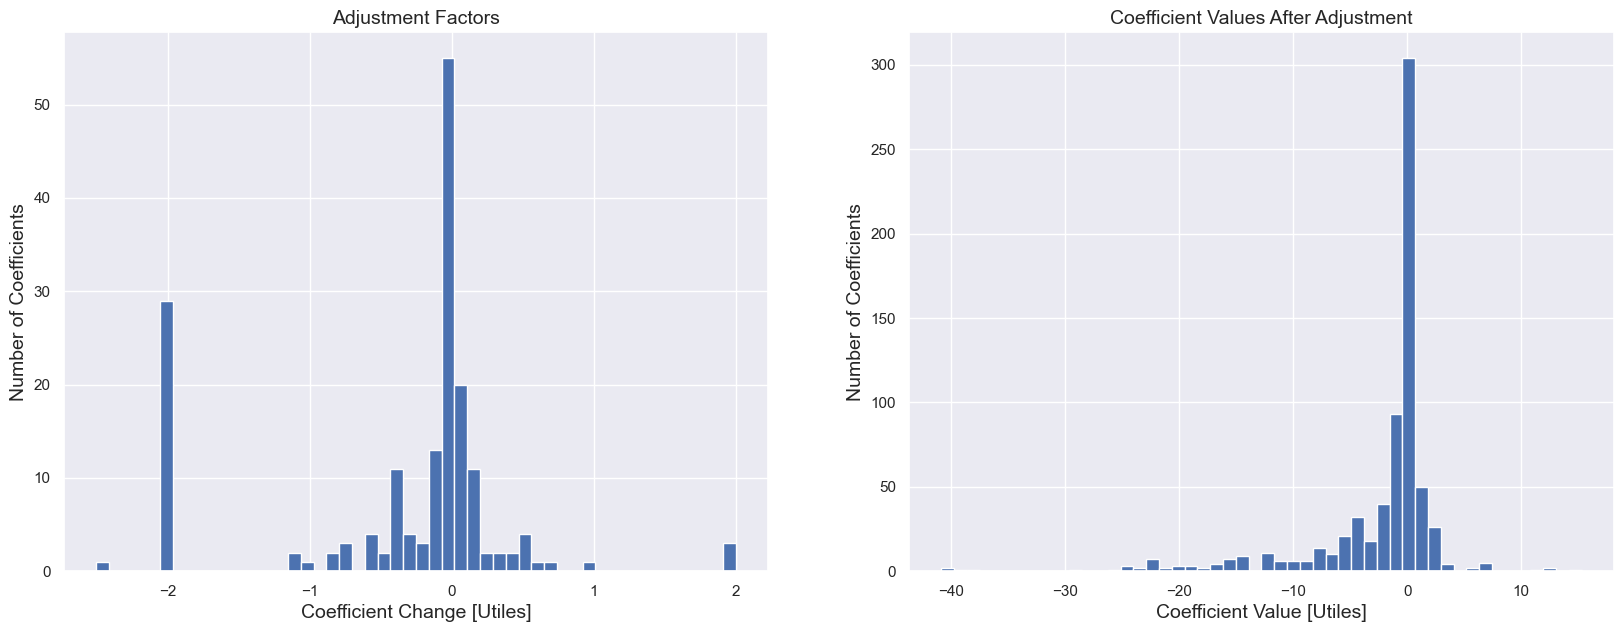

Top 10 largest coefficients:


coefficient_name      value  \
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -38.865285   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -39.934870   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -39.390562   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -37.372441   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -26.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -26.246255   
675           coef_calib_autodeficienthhjoi_TAXI_maint -22.970666   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -24.970666   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -24.970666   
471            coef_calib_zeroautohhindivtou_WALK_univ -23.883300   

     model_counts  target_counts coef_change  new_value  converged  
540         124.0            0.0          -2 -40.865285      False  
541           0.0            0.0        <NA> -39.934870       True  
543          64.0            0.0        <NA> -39.390562       True  
544          84.0           29.0   -1.063521 -38.435962       True  
698         112.0            0.0          -2 -28.875688      False  
695          96.0            0.0        <NA> -26.246255       True  
675         207.0            0.0          -2 -24.970666      False  
676          24.0            0.0        <NA> -24.970666       True  
677          56.0            0.0        <NA> -24.970666       True  
471           0.0            0.0        <NA> -23.883300       True

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_7
ActivitySim run started at:  2023-09-13 04:26:45.337503
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-13 05:12:15.645622
Run Time:  2730.31 secs =  45.50516666666667  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

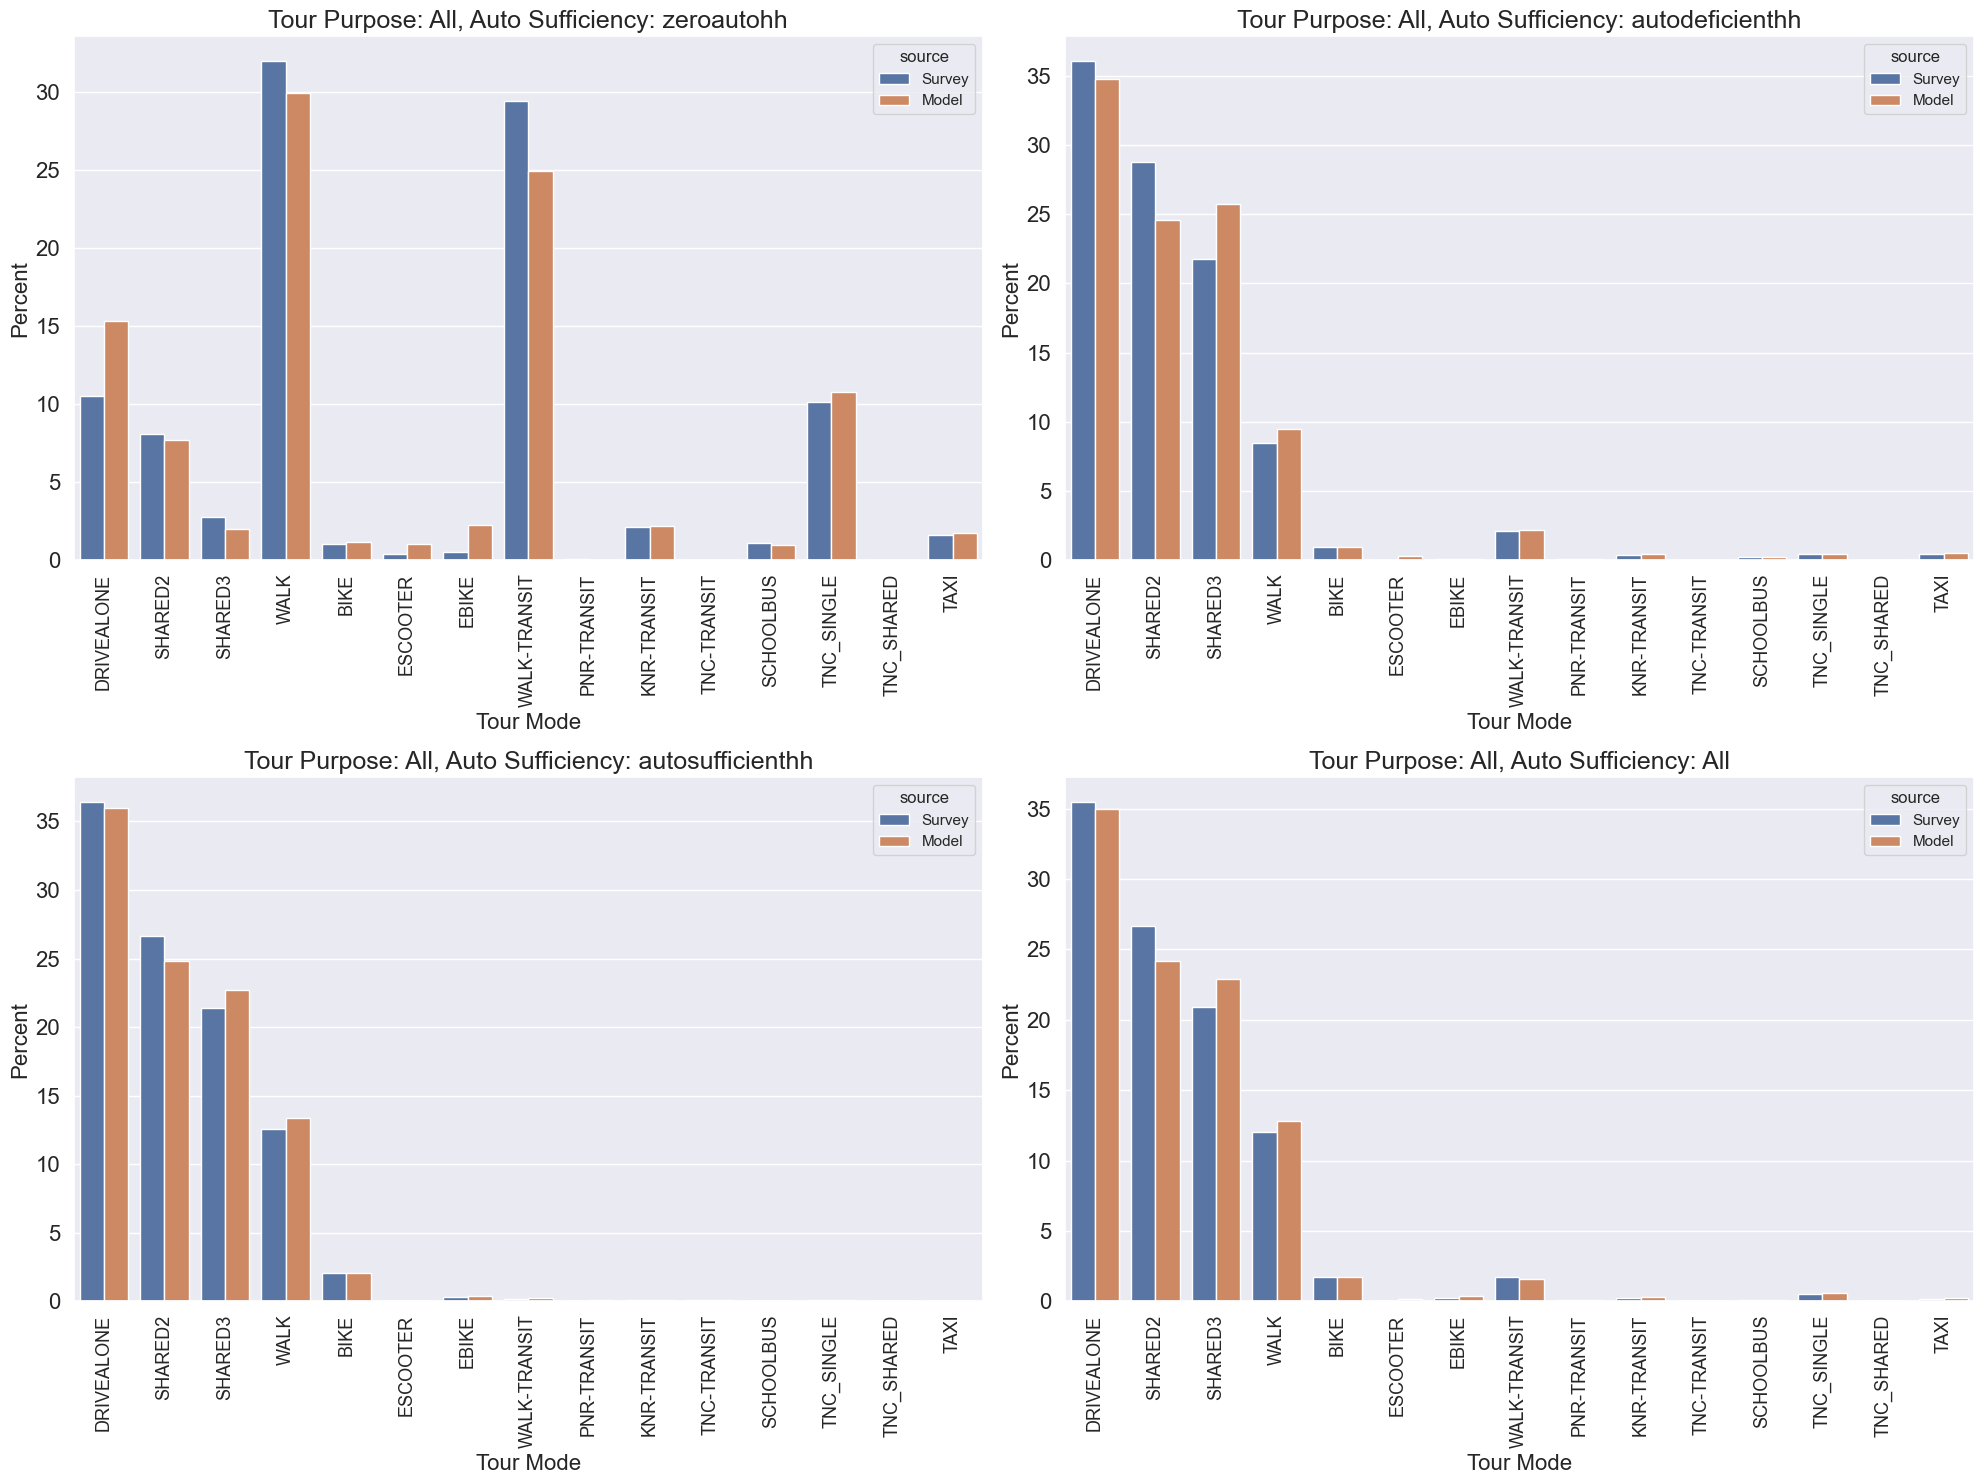

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 175 coefficients adjusted
	 679 coefficients converged
	 78 coefficients not converged


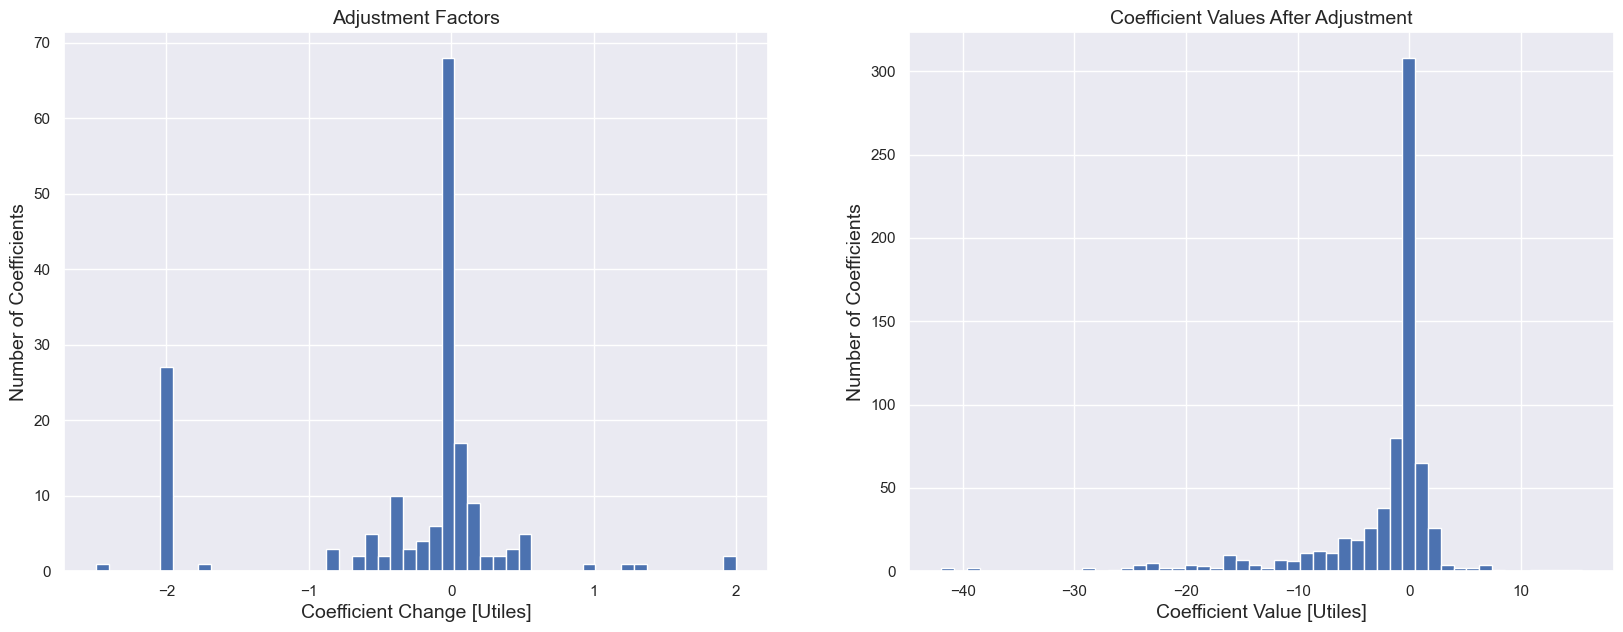

Top 10 largest coefficients:


coefficient_name      value  \
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -39.934870   
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -40.865285   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -39.390562   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -38.435962   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -28.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -26.246255   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -24.970666   
675           coef_calib_autodeficienthhjoi_TAXI_maint -24.970666   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -24.970666   
717      coef_calib_autodeficienthhjoi_TNC_SHARED_disc -22.715984   

     model_counts  target_counts coef_change  new_value  converged  
541         104.0            0.0          -2 -41.934870      False  
540           8.0            0.0        <NA> -40.865285       True  
543          84.0            0.0        <NA> -39.390562       True  
544          68.0           29.0   -0.852212 -39.288174       True  
698          72.0            0.0        <NA> -28.875688       True  
695         131.0            0.0          -2 -28.246255      False  
677         143.0            0.0          -2 -26.970666      False  
675          24.0            0.0        <NA> -24.970666       True  
676          68.0            0.0        <NA> -24.970666       True  
717         143.0            0.0          -2 -24.715984      False

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_8
ActivitySim run started at:  2023-09-13 05:12:45.784381
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-13 05:58:00.925618
Run Time:  2715.14 secs =  45.25233333333333  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

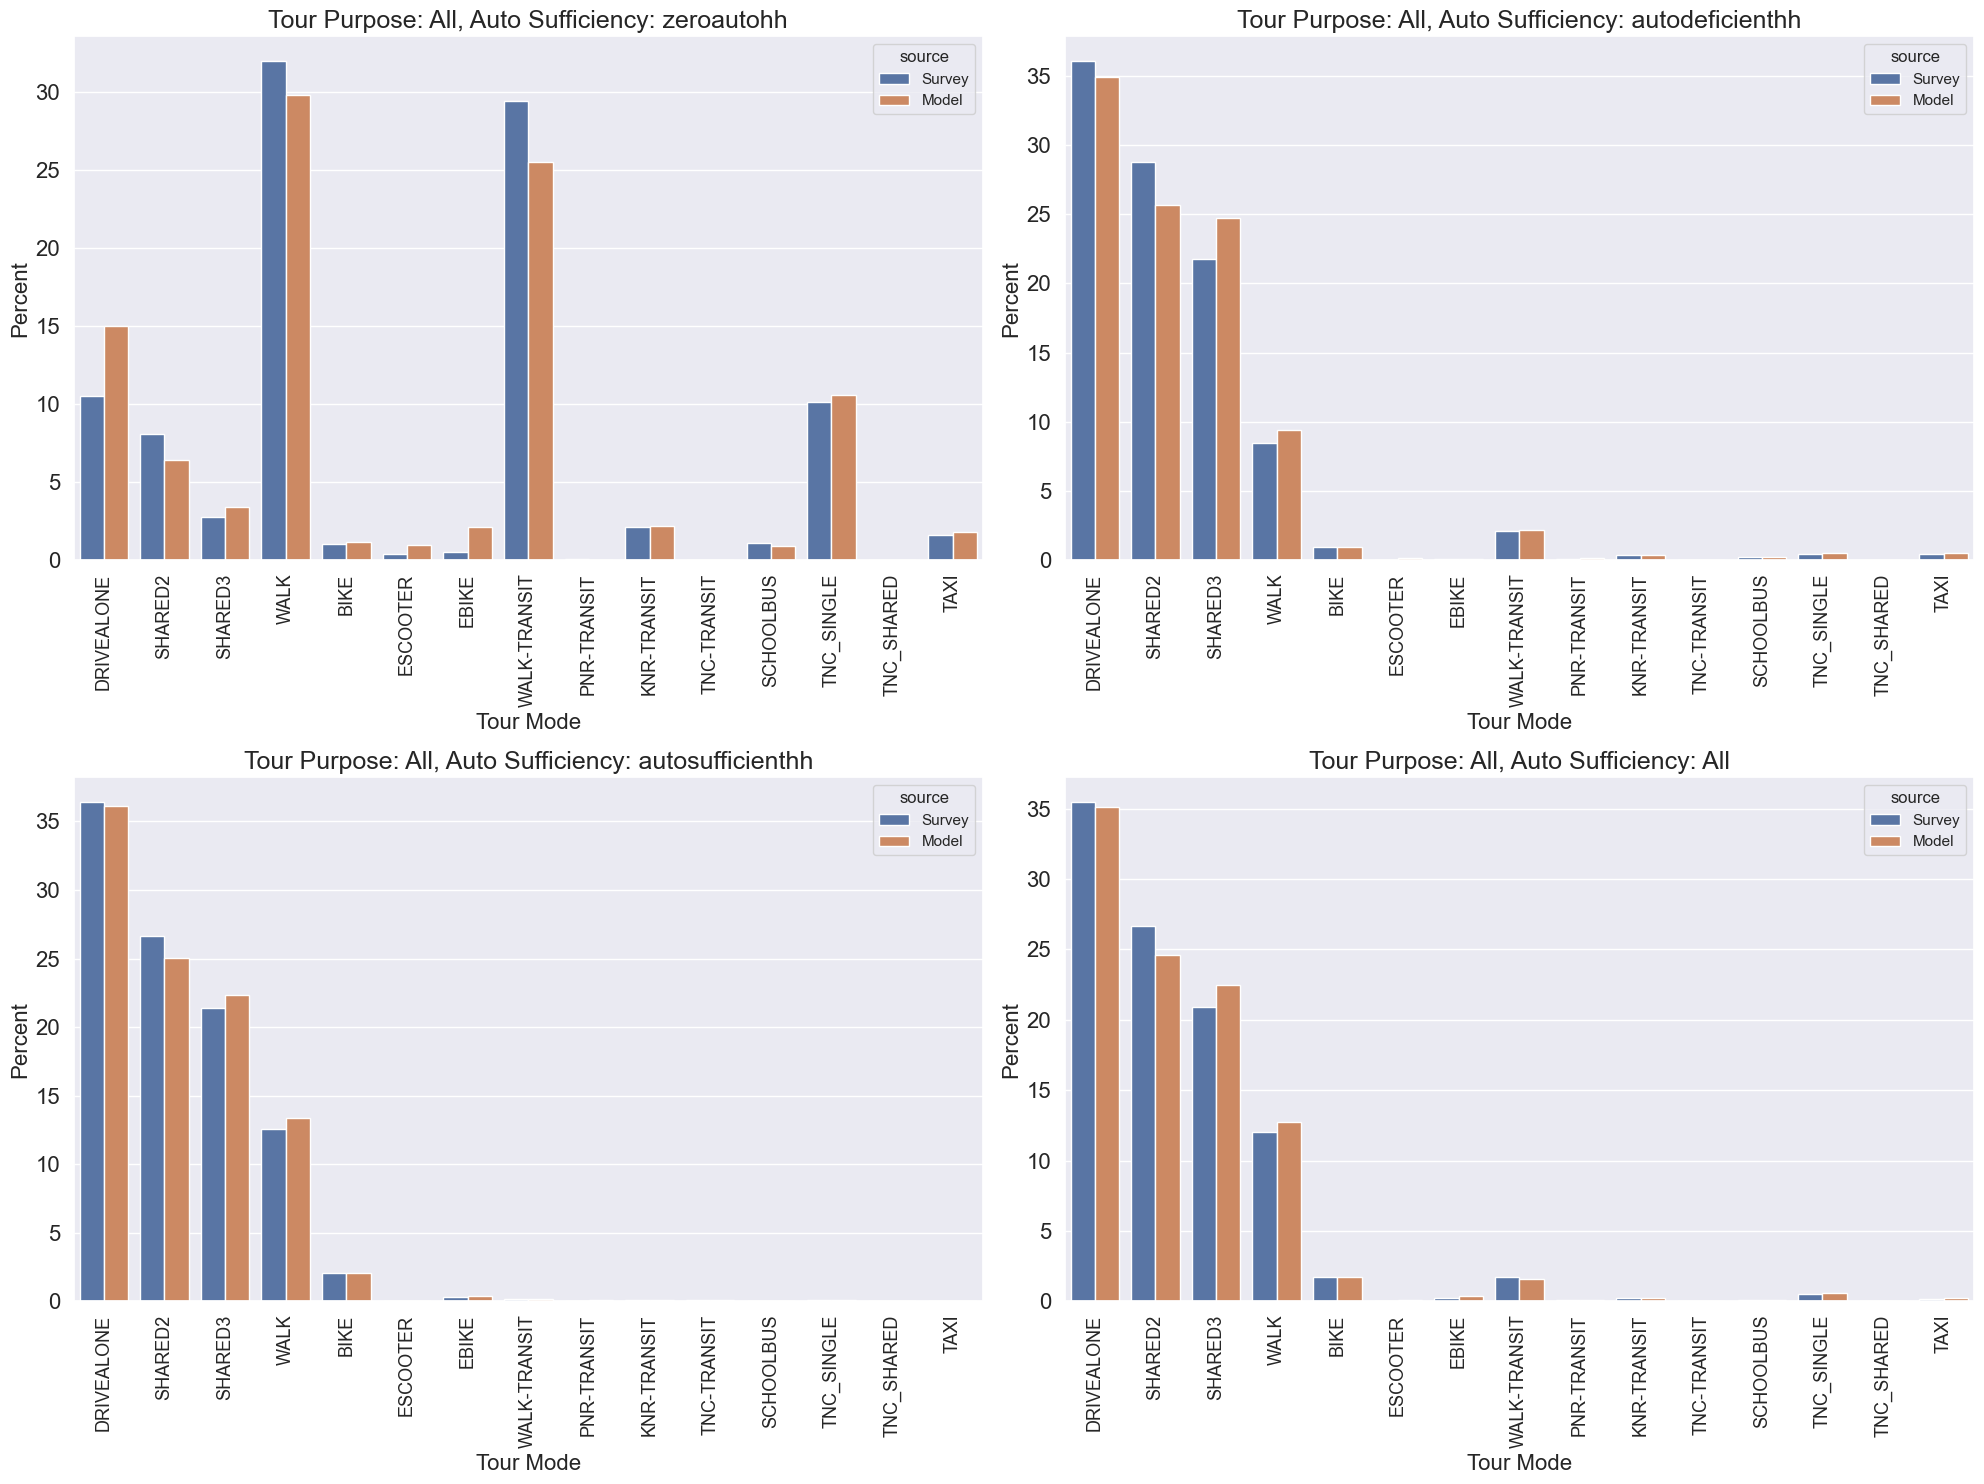

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 173 coefficients adjusted
	 684 coefficients converged
	 73 coefficients not converged


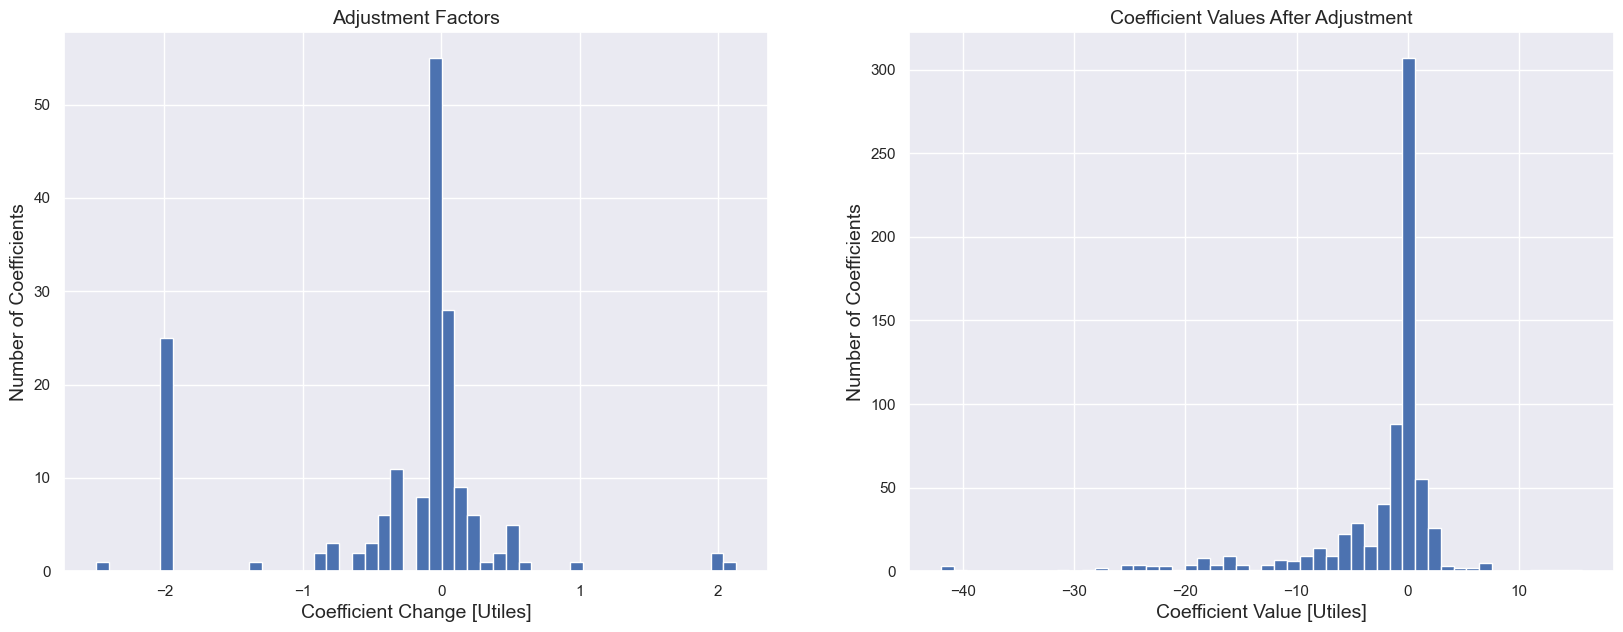

Top 10 largest coefficients:


coefficient_name      value  \
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -41.934870   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -39.390562   
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -40.865285   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -39.288174   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -28.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -28.246255   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -26.970666   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -24.970666   
675           coef_calib_autodeficienthhjoi_TAXI_maint -24.970666   
717      coef_calib_autodeficienthhjoi_TNC_SHARED_disc -24.715984   

     model_counts  target_counts coef_change  new_value  converged  
541           0.0            0.0        <NA> -41.934870       True  
543         112.0            0.0          -2 -41.390562      False  
540         100.0            0.0        <NA> -40.865285       True  
544          48.0           29.0   -0.503905 -39.792080       True  
698         112.0            0.0          -2 -30.875688      False  
695          92.0            0.0        <NA> -28.246255       True  
677          20.0            0.0        <NA> -26.970666       True  
676         155.0            0.0          -2 -26.970666      False  
675          64.0            0.0        <NA> -24.970666       True  
717          20.0            0.0        <NA> -24.715984       True

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_9
ActivitySim run started at:  2023-09-13 05:58:30.385875
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-13 06:44:00.485939
Run Time:  2730.1 secs =  45.501666666666665  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

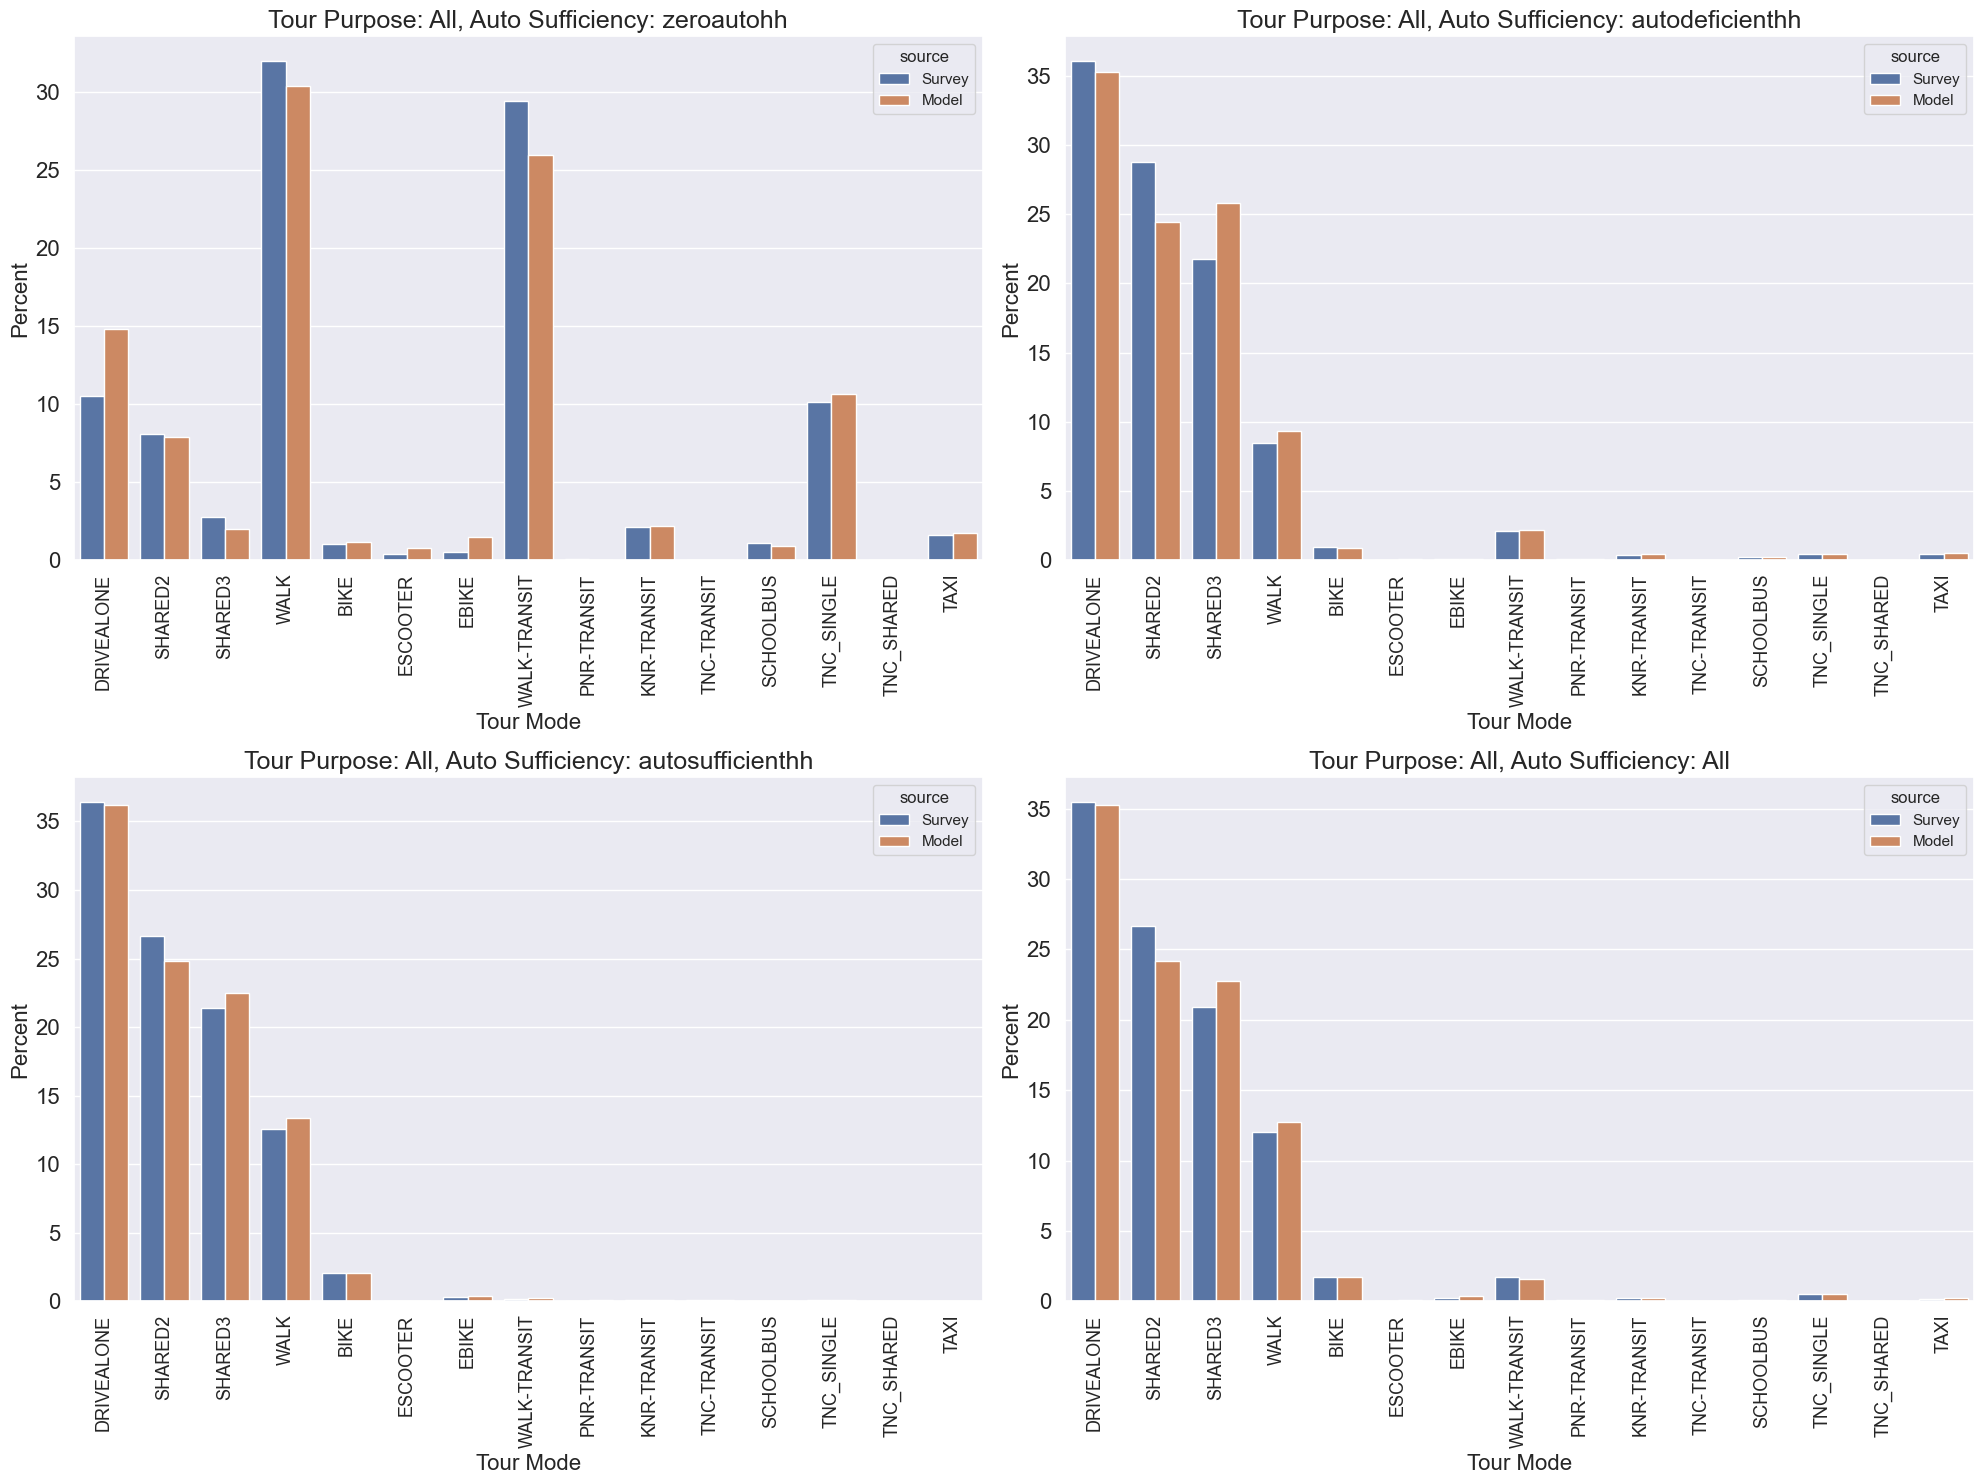

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 171 coefficients adjusted
	 687 coefficients converged
	 70 coefficients not converged


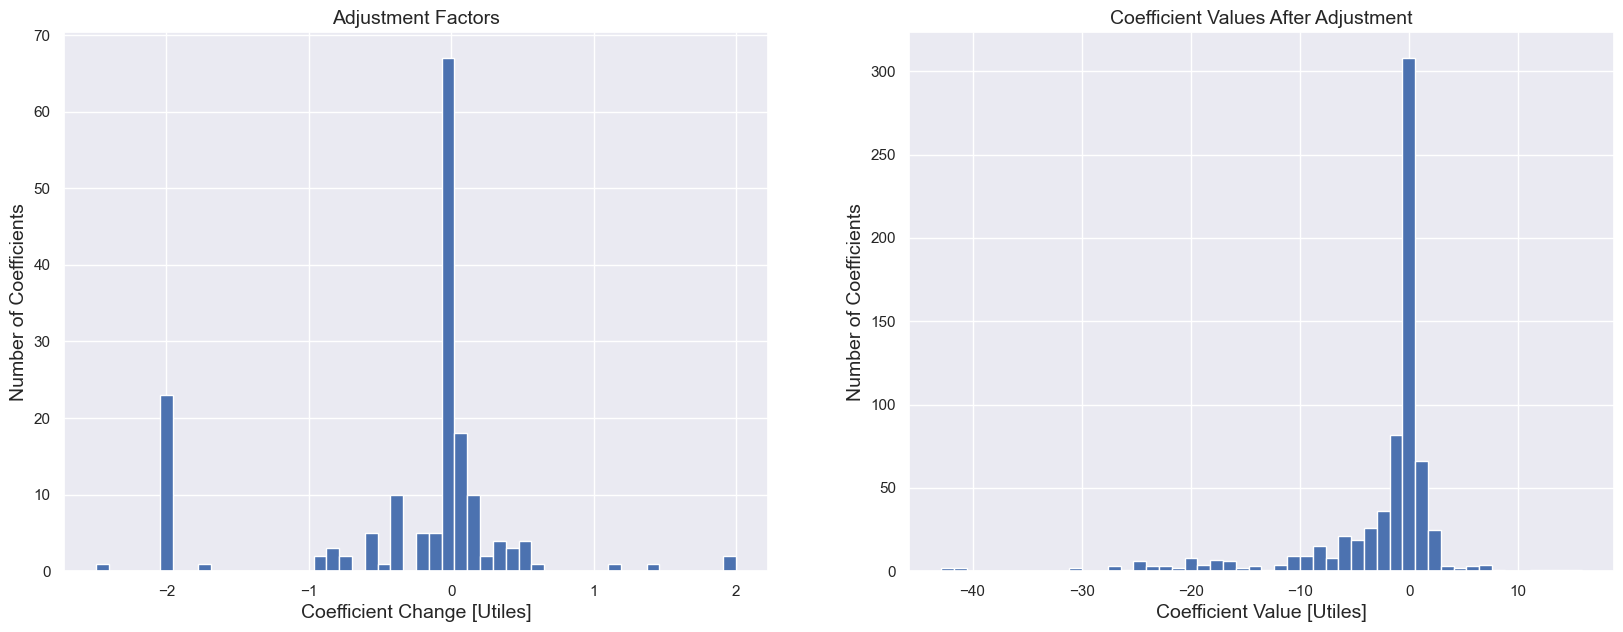

Top 10 largest coefficients:


coefficient_name      value  \
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -40.865285   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -41.934870   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -41.390562   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -39.792080   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -30.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -28.246255   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -26.970666   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -26.970666   
675           coef_calib_autodeficienthhjoi_TAXI_maint -24.970666   
671   coef_calib_autodeficienthhjoi_WALK_TRANSIT_maint -24.691160   

     model_counts  target_counts coef_change  new_value  converged  
540         116.0            0.0          -2 -42.865285      False  
541           0.0            0.0        <NA> -41.934870       True  
543          68.0            0.0        <NA> -41.390562       True  
544          68.0           29.0   -0.852212 -40.644291       True  
698          88.0            0.0        <NA> -30.875688       True  
695         139.0            0.0          -2 -30.246255      False  
676          12.0            0.0        <NA> -26.970666       True  
677          40.0            0.0        <NA> -26.970666       True  
675         155.0            0.0          -2 -26.970666      False  
671          92.0           42.0   -0.784119 -25.475279       True



 Final coefficient table written to:  C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_9\tour_mode_choice_coefficients.csv


In [30]:
calibration_iterations_to_run = 8
start_iter_num = 2

for i in range(start_iter_num, calibration_iterations_to_run+start_iter_num):
    asim_calib_util.run_activitysim(
        data_dir=data_dir,  # data inputs for ActivitySim
        configs_resident_dir=configs_resident_dir,  # these files are copied to the config section of the run directory
        configs_common_dir=configs_common_dir,  # just the location of the common config, these files will be used from the original location
        run_dir=activitysim_run_dir,  # ActivitySim run directory
        output_dir=iteration_output_dir,  # location to store run model outputs
        settings_file=warm_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
        tour_mc_coef_file=tour_mc_coef_file  # optional: tour_mode_choice_coefficients.csv to replace the one in configs_dir
    )
    
    _ = asim_calib_util.perform_tour_mode_choice_model_calibration(
        asim_output_dir=iteration_output_dir, # folder containing the activitysim model output
        asim_configs_dir=os.path.join(activitysim_run_dir, 'configs'),  # folder containing activitysim tour mode choice config files
        tour_mode_choice_calib_targets_file=tour_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  # maximum allowed adjustment per iteration
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=iteration_output_dir,  # location to write model calibration steps
    )
    tour_mc_coef_file = os.path.join(iteration_output_dir, 'tour_mode_choice_coefficients.csv')
    iteration_output_dir = iteration_output_dir.strip('_'+str(i)) + '_' + str(i+1)

print("\n\n", "Final coefficient table written to: ", tour_mc_coef_file)

In [65]:
tour_mc_coef_file = r'C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_9\tour_mode_choice_coefficients_UPDATED.csv'
iteration_output_dir = r'C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_10'

print(tour_mc_coef_file)
print(iteration_output_dir)

C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_9\tour_mode_choice_coefficients_UPDATED.csv
C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_10


creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_10
ActivitySim run started at:  2023-09-13 14:37:43.903139
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-13 15:25:25.378209
Run Time:  2861.48 secs =  47.69133333333333  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:732: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_tour_per_source_df = data.groupby('source').sum()
c:\abm_runs\rohans\calibration\tour_mc\

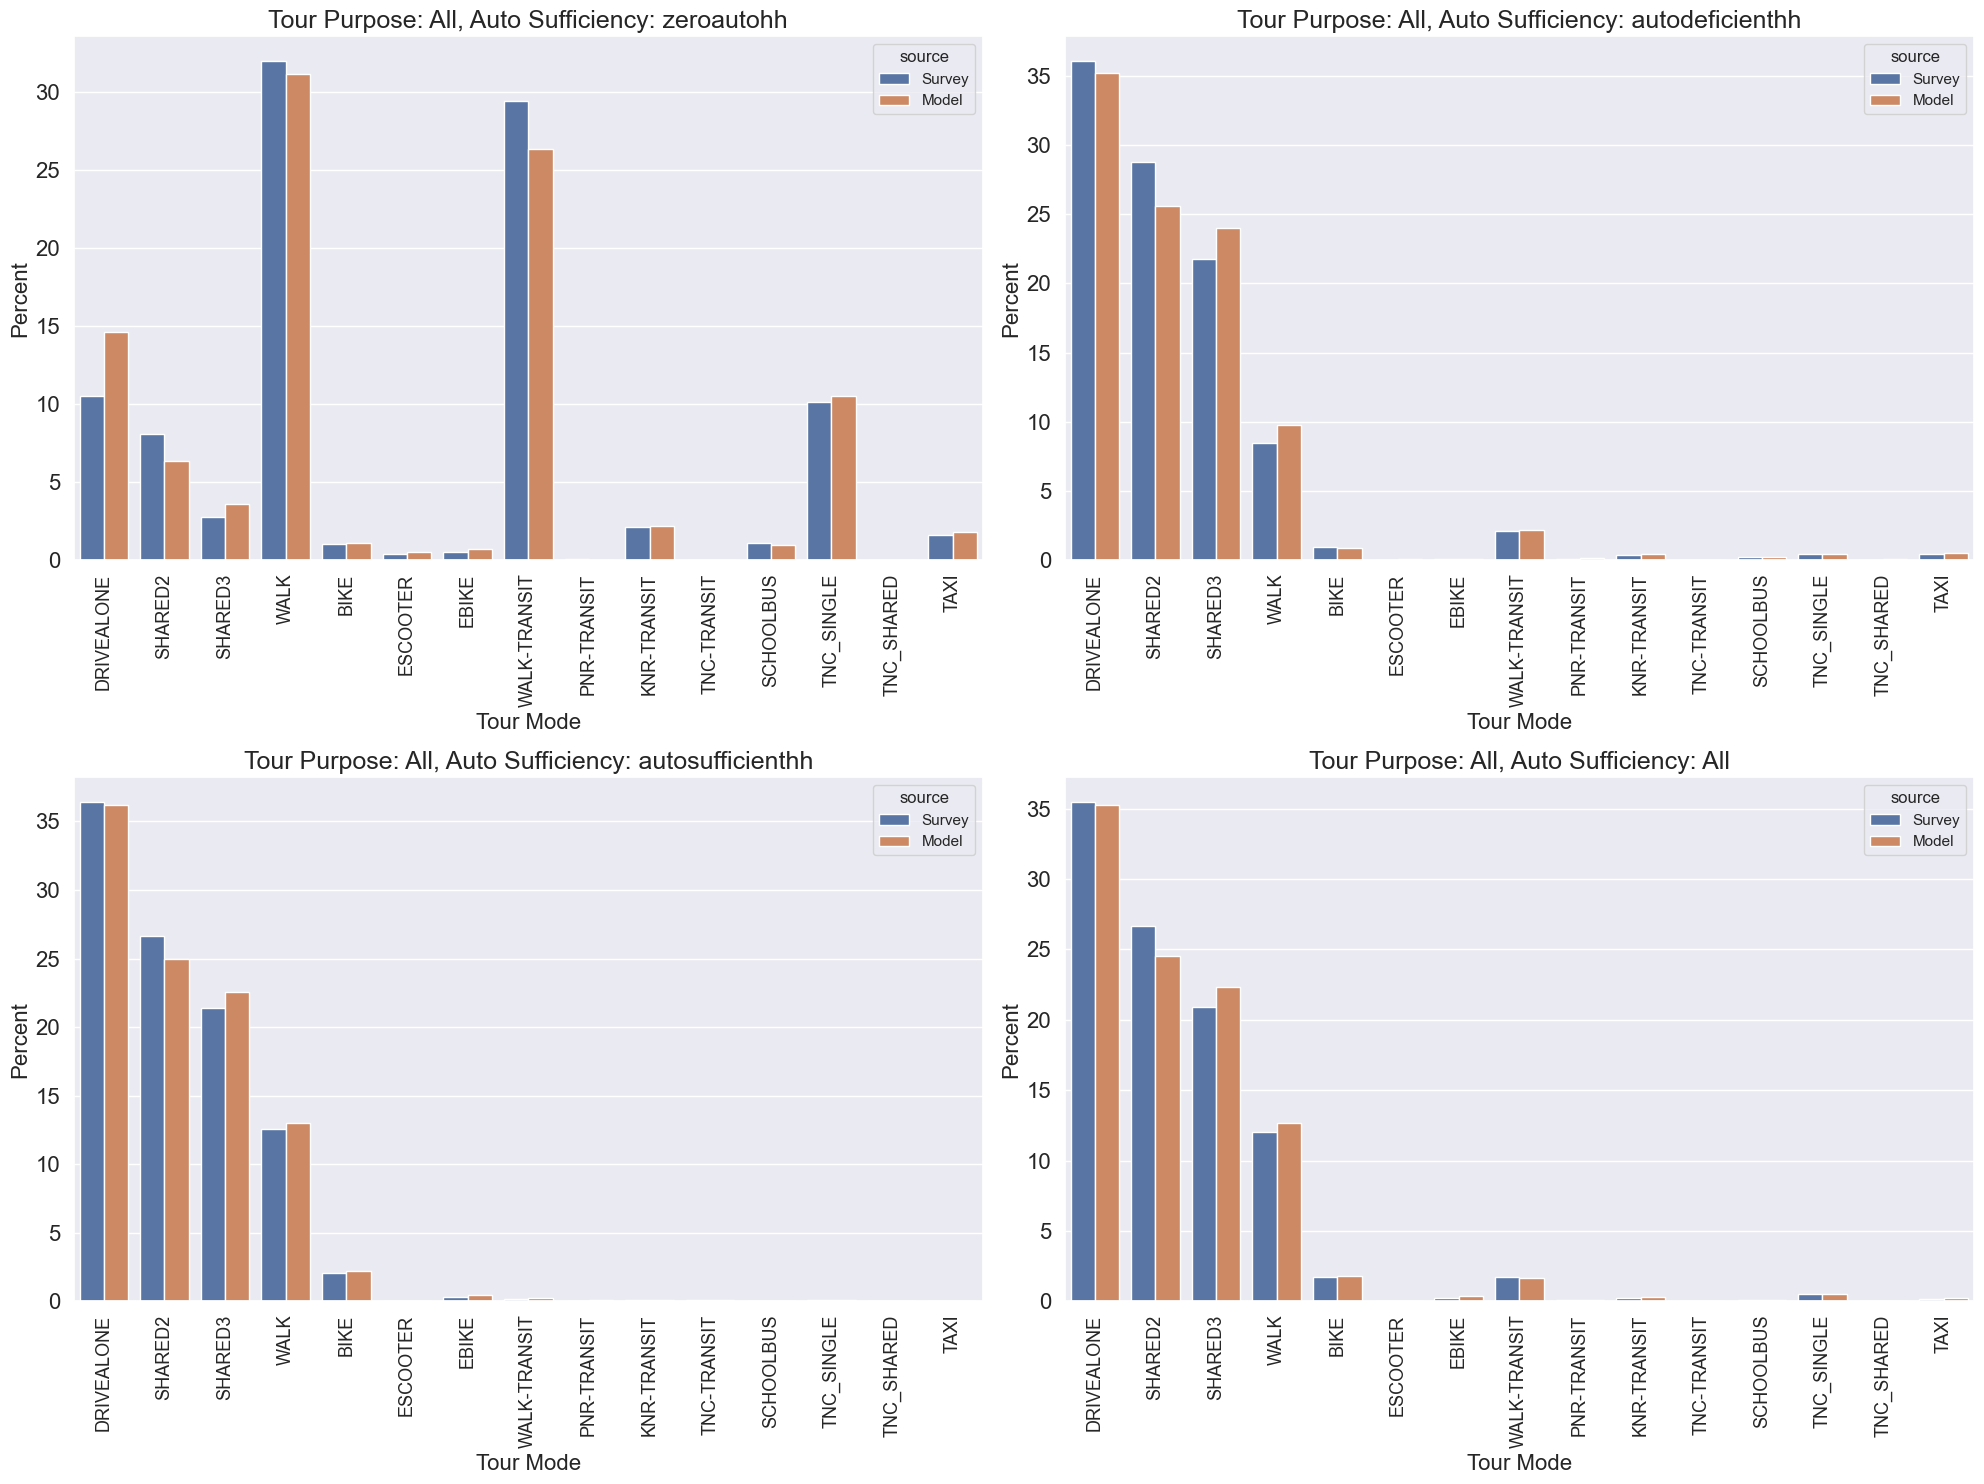

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 178 coefficients adjusted
	 677 coefficients converged
	 80 coefficients not converged


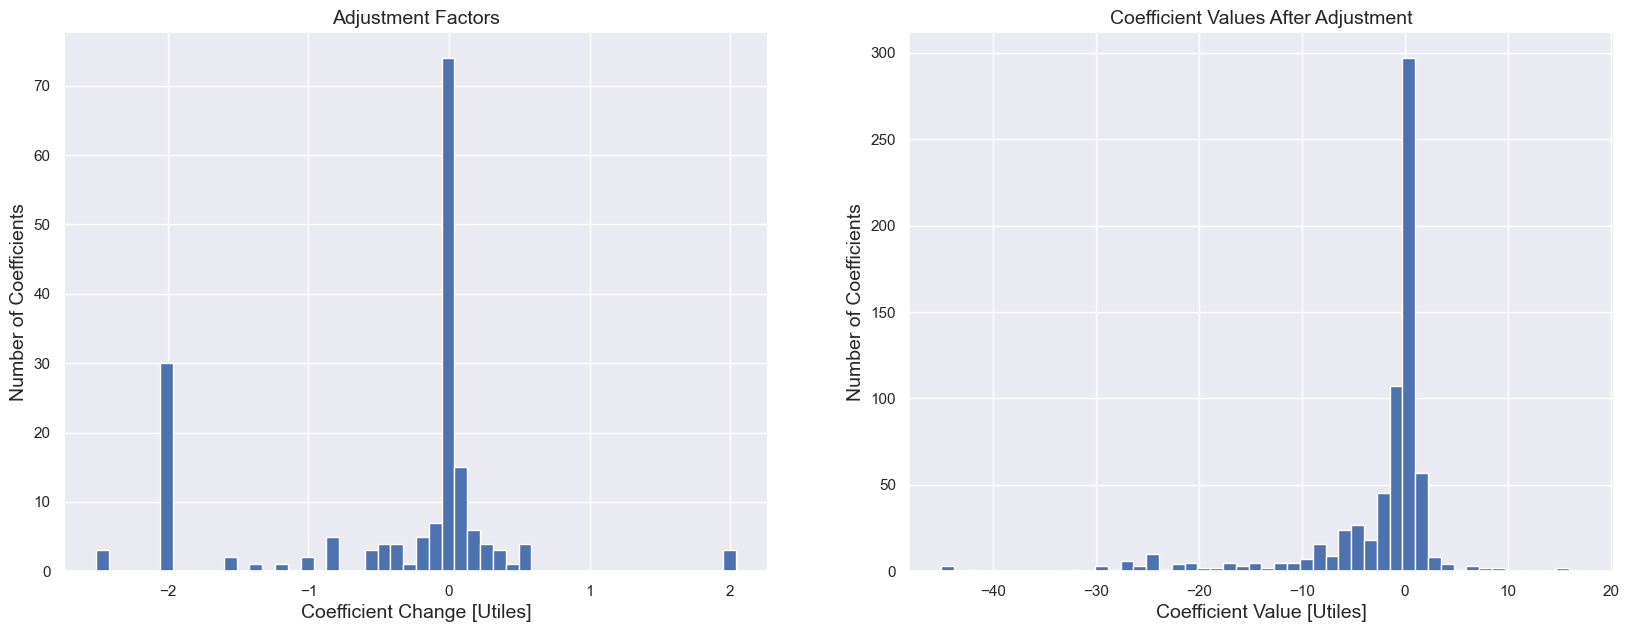

Top 10 largest coefficients:


coefficient_name      value  \
543          coef_calib_zeroautohhindivtou_BIKE_atwork -45.000000   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -45.000000   
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -45.000000   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -41.000000   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -30.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -30.246255   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -26.970666   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -26.970666   
675           coef_calib_autodeficienthhjoi_TAXI_maint -26.970666   
671   coef_calib_autodeficienthhjoi_WALK_TRANSIT_maint -25.475279   

     model_counts  target_counts coef_change  new_value  converged  
543          52.0            0.0        <NA> -45.000000       True  
541          52.0            0.0        <NA> -45.000000       True  
540          56.0            0.0        <NA> -45.000000       True  
544          92.0           29.0   -1.154493 -42.154493       True  
698         155.0            0.0          -2 -32.875688      False  
695         108.0            0.0          -2 -32.246255      False  
676         151.0            0.0          -2 -28.970666      False  
677         566.0            0.0          -2 -28.970666      False  
675         127.0            0.0          -2 -28.970666      False  
671         518.0           42.0   -2.512306 -27.987585      False



 Final coefficient table written to:  C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_10\tour_mode_choice_coefficients.csv


In [66]:
calibration_iterations_to_run = 1
start_iter_num = 10

for i in range(start_iter_num, calibration_iterations_to_run+start_iter_num):
    asim_calib_util.run_activitysim(
        data_dir=data_dir,  # data inputs for ActivitySim
        configs_resident_dir=configs_resident_dir,  # these files are copied to the config section of the run directory
        configs_common_dir=configs_common_dir,  # just the location of the common config, these files will be used from the original location
        run_dir=activitysim_run_dir,  # ActivitySim run directory
        output_dir=iteration_output_dir,  # location to store run model outputs
        settings_file=warm_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
        tour_mc_coef_file=tour_mc_coef_file  # optional: tour_mode_choice_coefficients.csv to replace the one in configs_dir
    )
    
    _ = asim_calib_util.perform_tour_mode_choice_model_calibration(
        asim_output_dir=iteration_output_dir, # folder containing the activitysim model output
        asim_configs_dir=os.path.join(activitysim_run_dir, 'configs'),  # folder containing activitysim tour mode choice config files
        tour_mode_choice_calib_targets_file=tour_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  # maximum allowed adjustment per iteration
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=iteration_output_dir,  # location to write model calibration steps
    )
    tour_mc_coef_file = os.path.join(iteration_output_dir, 'tour_mode_choice_coefficients.csv')
    iteration_output_dir = iteration_output_dir.strip('_'+str(i)) + '_' + str(i+1)

print("\n\n", "Final coefficient table written to: ", tour_mc_coef_file)

In [71]:
tour_mc_coef_file = r'C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_10\tour_mode_choice_coefficients_UPDATED_2.csv'
iteration_output_dir = r'C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_11'

print(tour_mc_coef_file)
print(iteration_output_dir)

C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_10\tour_mode_choice_coefficients_UPDATED_2.csv
C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_11


creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_11
ActivitySim run started at:  2023-09-14 13:45:16.633700
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-14 14:34:02.587656
Run Time:  2925.95 secs =  48.76583333333333  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.yticks(fontsize=16)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: 

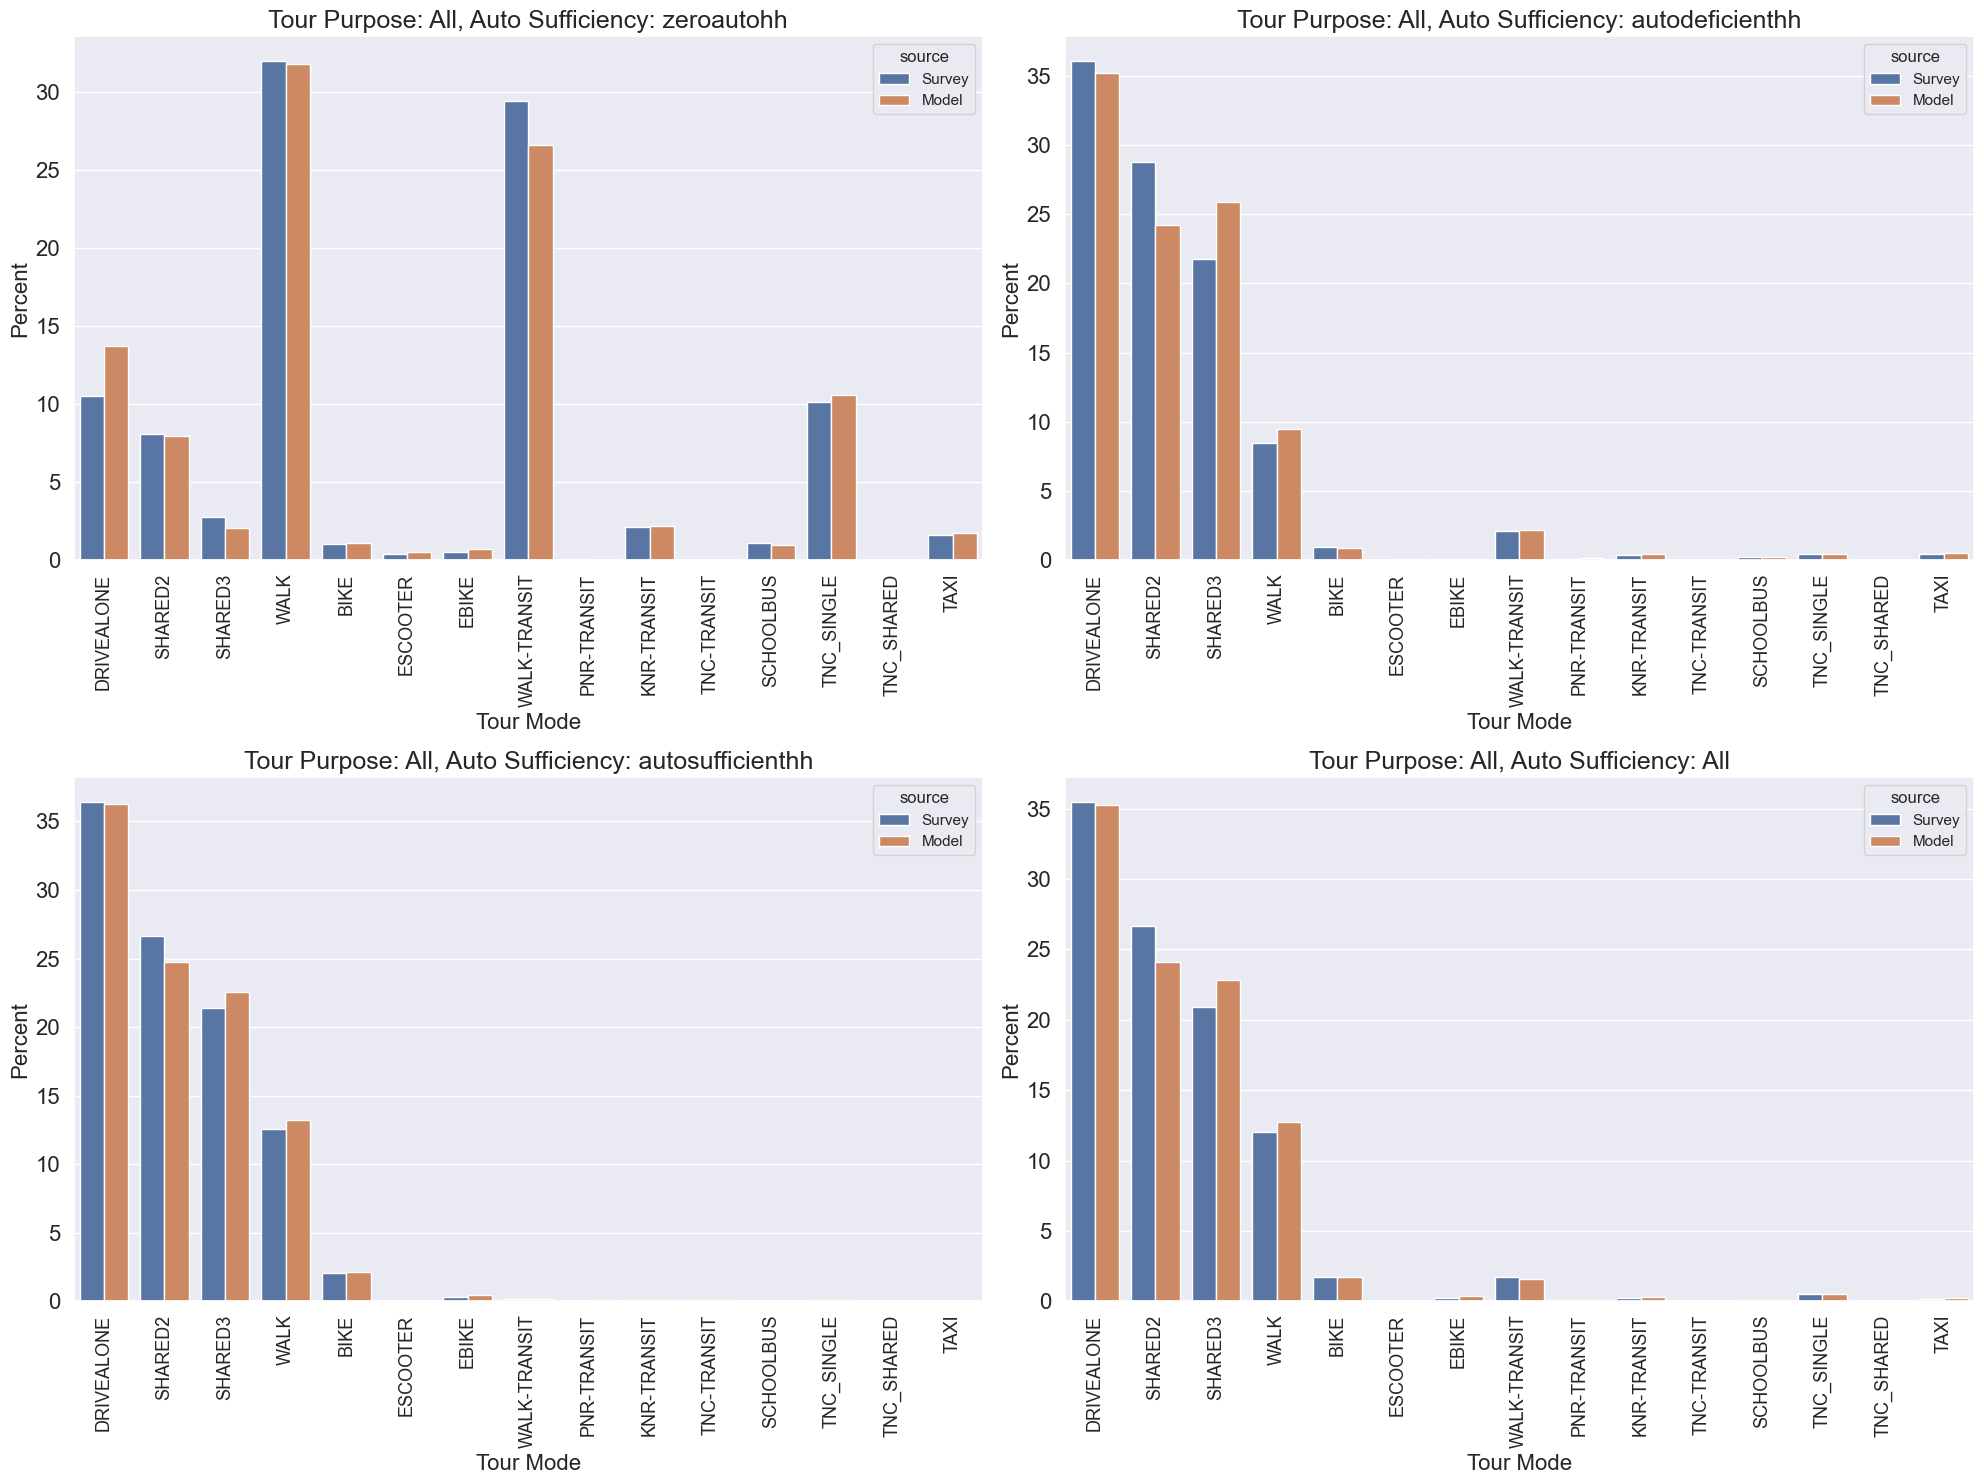

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 61 coefficients adjusted
	 696 coefficients converged
	 61 coefficients not converged


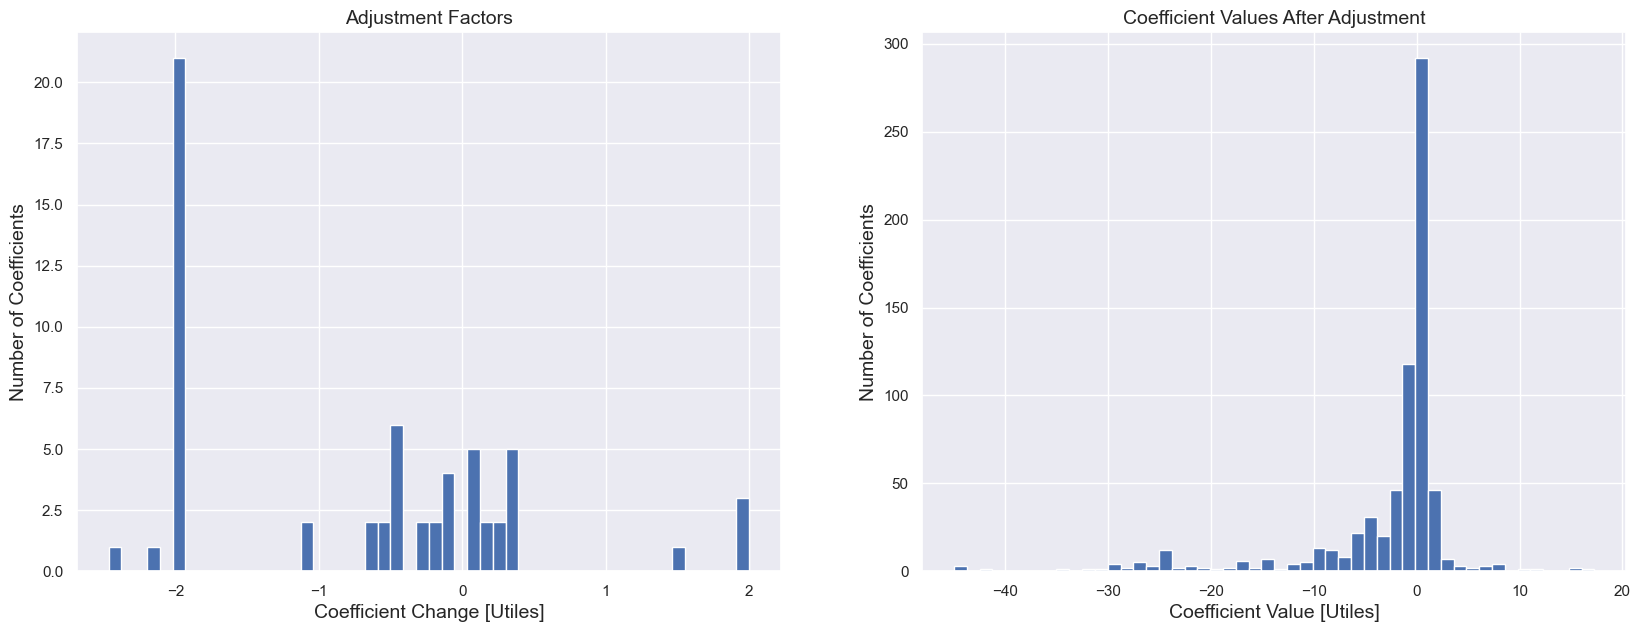

Top 10 largest coefficients:


coefficient_name      value  \
543          coef_calib_zeroautohhindivtou_BIKE_atwork -45.000000   
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -45.000000   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -45.000000   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -42.154493   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -32.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -32.246255   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -28.970666   
519  coef_calib_autodeficienthhind_WALK_TRANSIT_school -26.769537   
503       coef_calib_zeroautohhindivtou_SHARED2_school -27.000000   
675           coef_calib_autodeficienthhjoi_TAXI_maint -28.970666   

     model_counts  target_counts coef_change  new_value  converged  
543          32.0            0.0        <NA> -45.000000       True  
540          56.0            0.0        <NA> -45.000000       True  
541          40.0            0.0        <NA> -45.000000       True  
544          72.0           29.0        <NA> -42.154493       True  
698         147.0            0.0          -2 -34.875688      False  
695          96.0            0.0        <NA> -32.246255       True  
677         155.0            0.0          -2 -30.970666      False  
519         259.0           22.0   -2.465786 -29.235323      False  
503         311.0            0.0          -2 -29.000000      False  
675          36.0            0.0        <NA> -28.970666       True

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_12
ActivitySim run started at:  2023-09-14 14:34:30.084773
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-14 15:23:19.689578
Run Time:  2929.61 secs =  48.82683333333333  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.yticks(fontsize=16)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: 

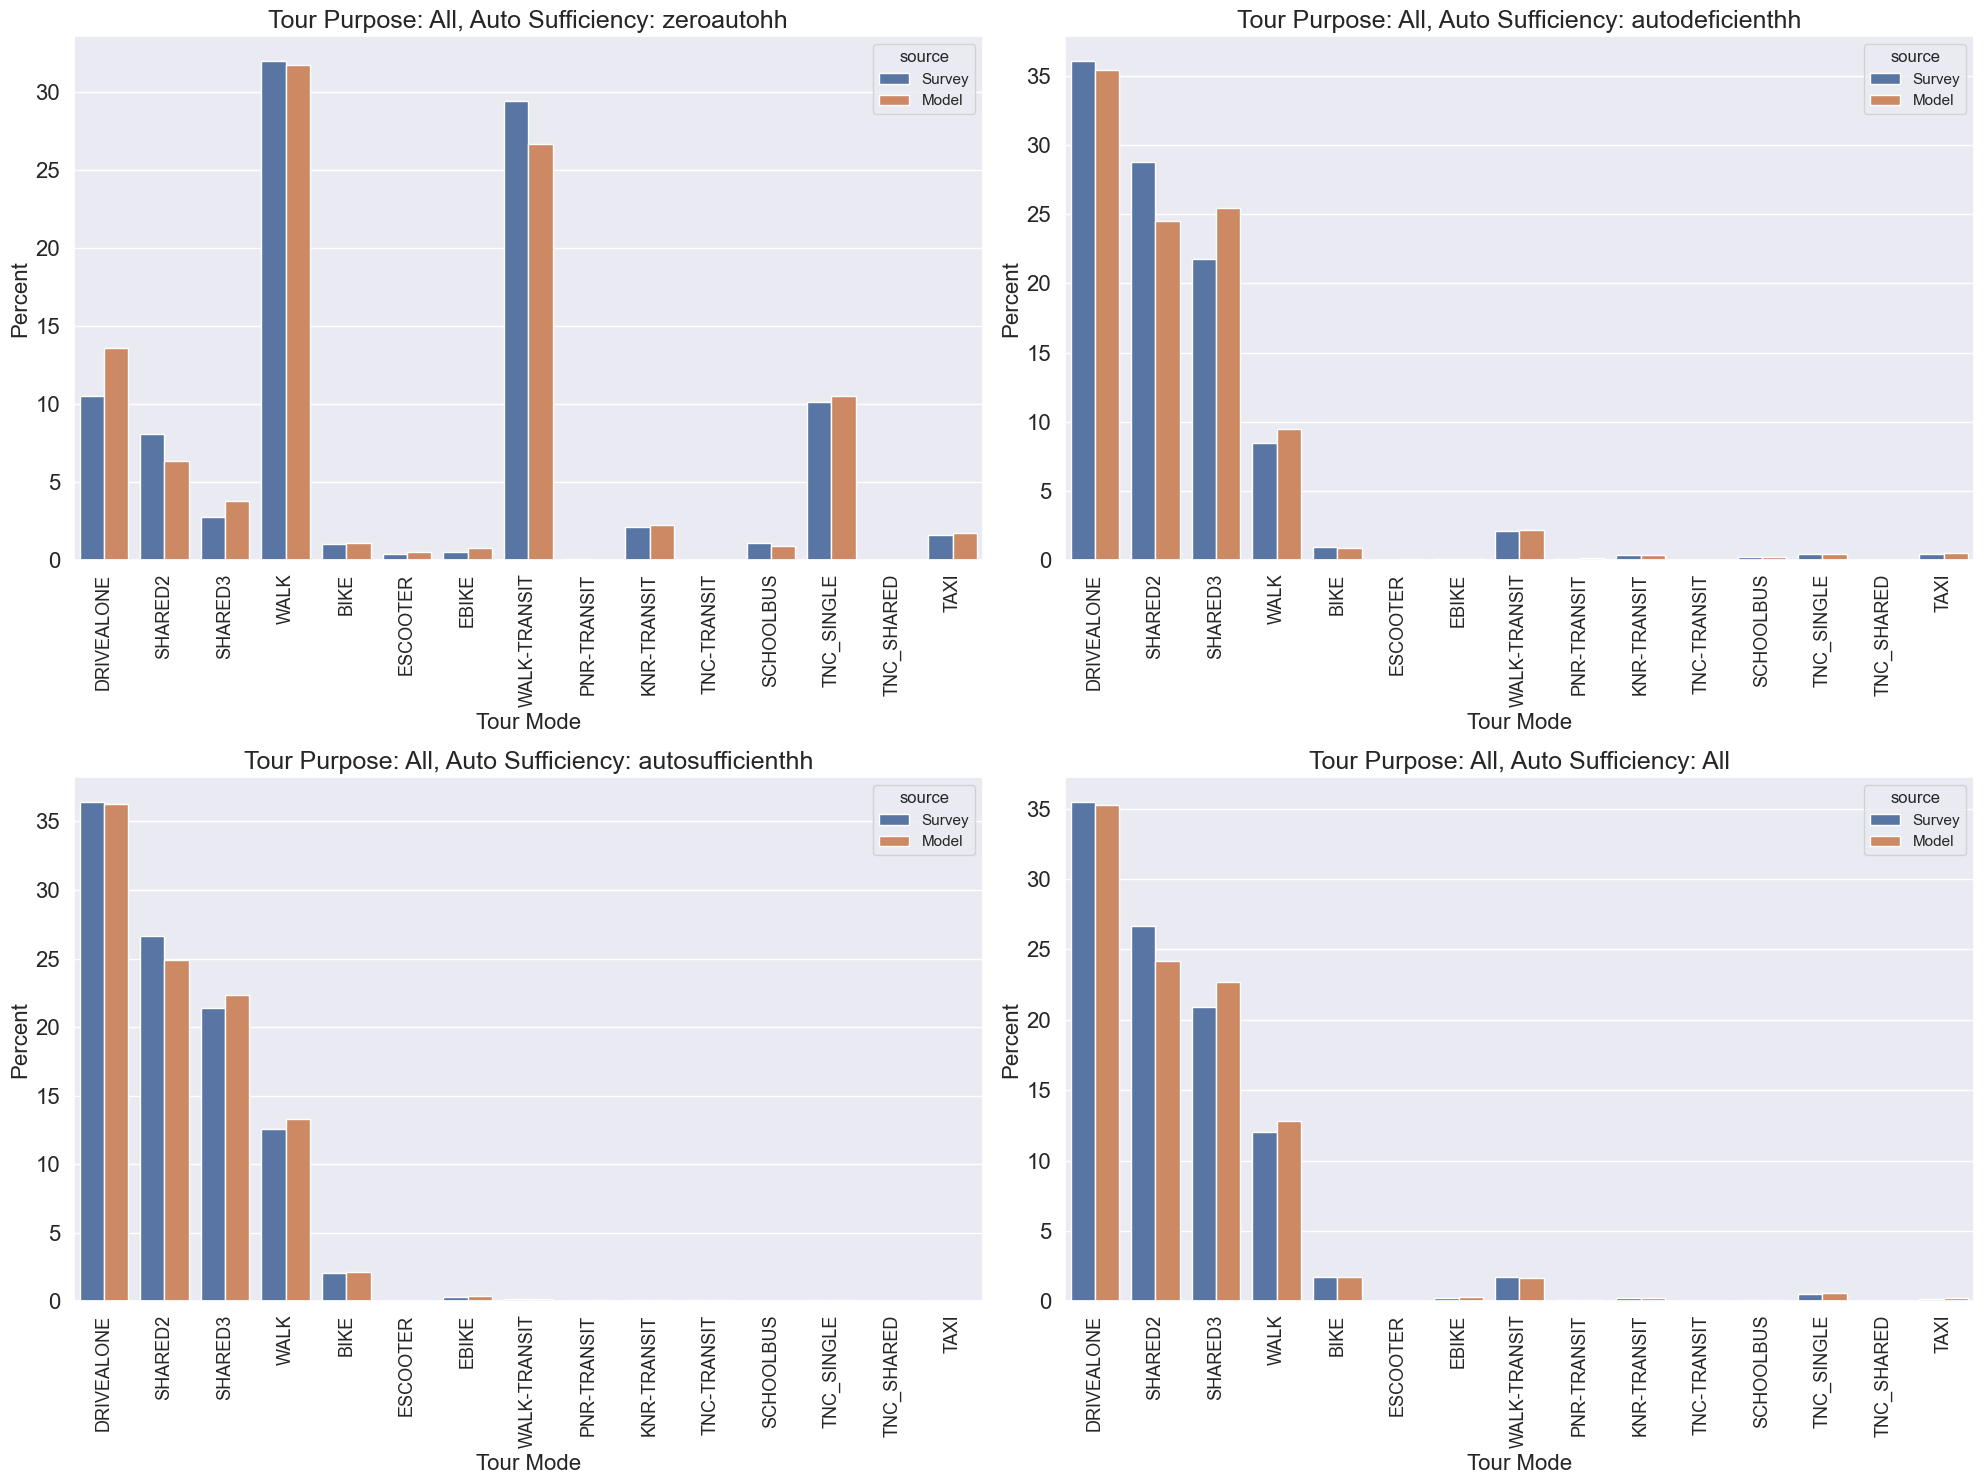

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 69 coefficients adjusted
	 688 coefficients converged
	 69 coefficients not converged


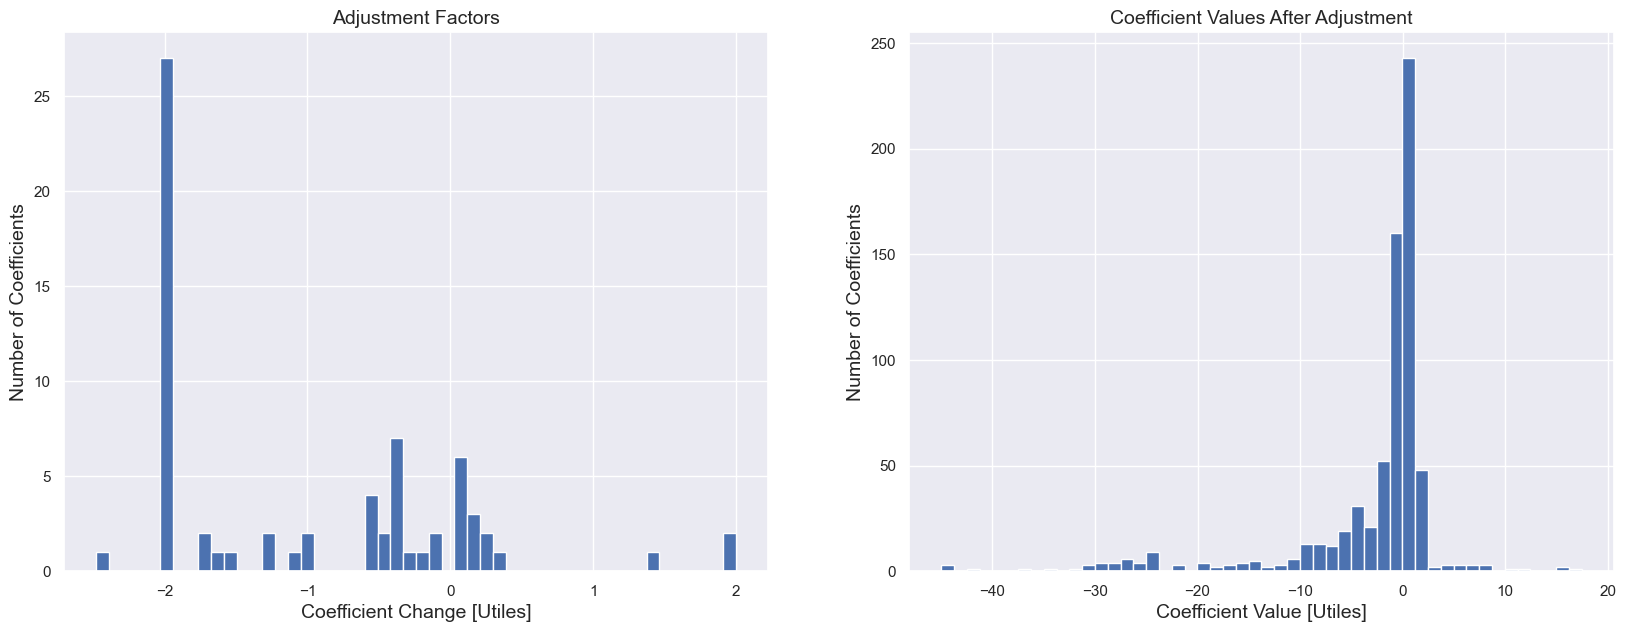

Top 10 largest coefficients:


coefficient_name      value  \
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -45.000000   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -45.000000   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -45.000000   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -42.154493   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -34.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -32.246255   
519  coef_calib_autodeficienthhind_WALK_TRANSIT_school -29.235323   
503       coef_calib_zeroautohhindivtou_SHARED2_school -29.000000   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -28.970666   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -30.970666   

     model_counts  target_counts coef_change  new_value  converged  
540          56.0            0.0        <NA> -45.000000       True  
541          36.0            0.0        <NA> -45.000000       True  
543          40.0            0.0        <NA> -45.000000       True  
544          80.0           29.0        <NA> -42.154493       True  
698         104.0            0.0          -2 -36.875688      False  
695         131.0            0.0          -2 -34.246255      False  
519         263.0           22.0   -2.481112 -31.716434      False  
503         247.0            0.0          -2 -31.000000      False  
676         159.0            0.0          -2 -30.970666      False  
677          32.0            0.0        <NA> -30.970666       True

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_13
ActivitySim run started at:  2023-09-14 15:23:50.644523
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-14 16:11:25.866134
Run Time:  2855.22 secs =  47.586999999999996  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.yticks(fontsize=16)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: 

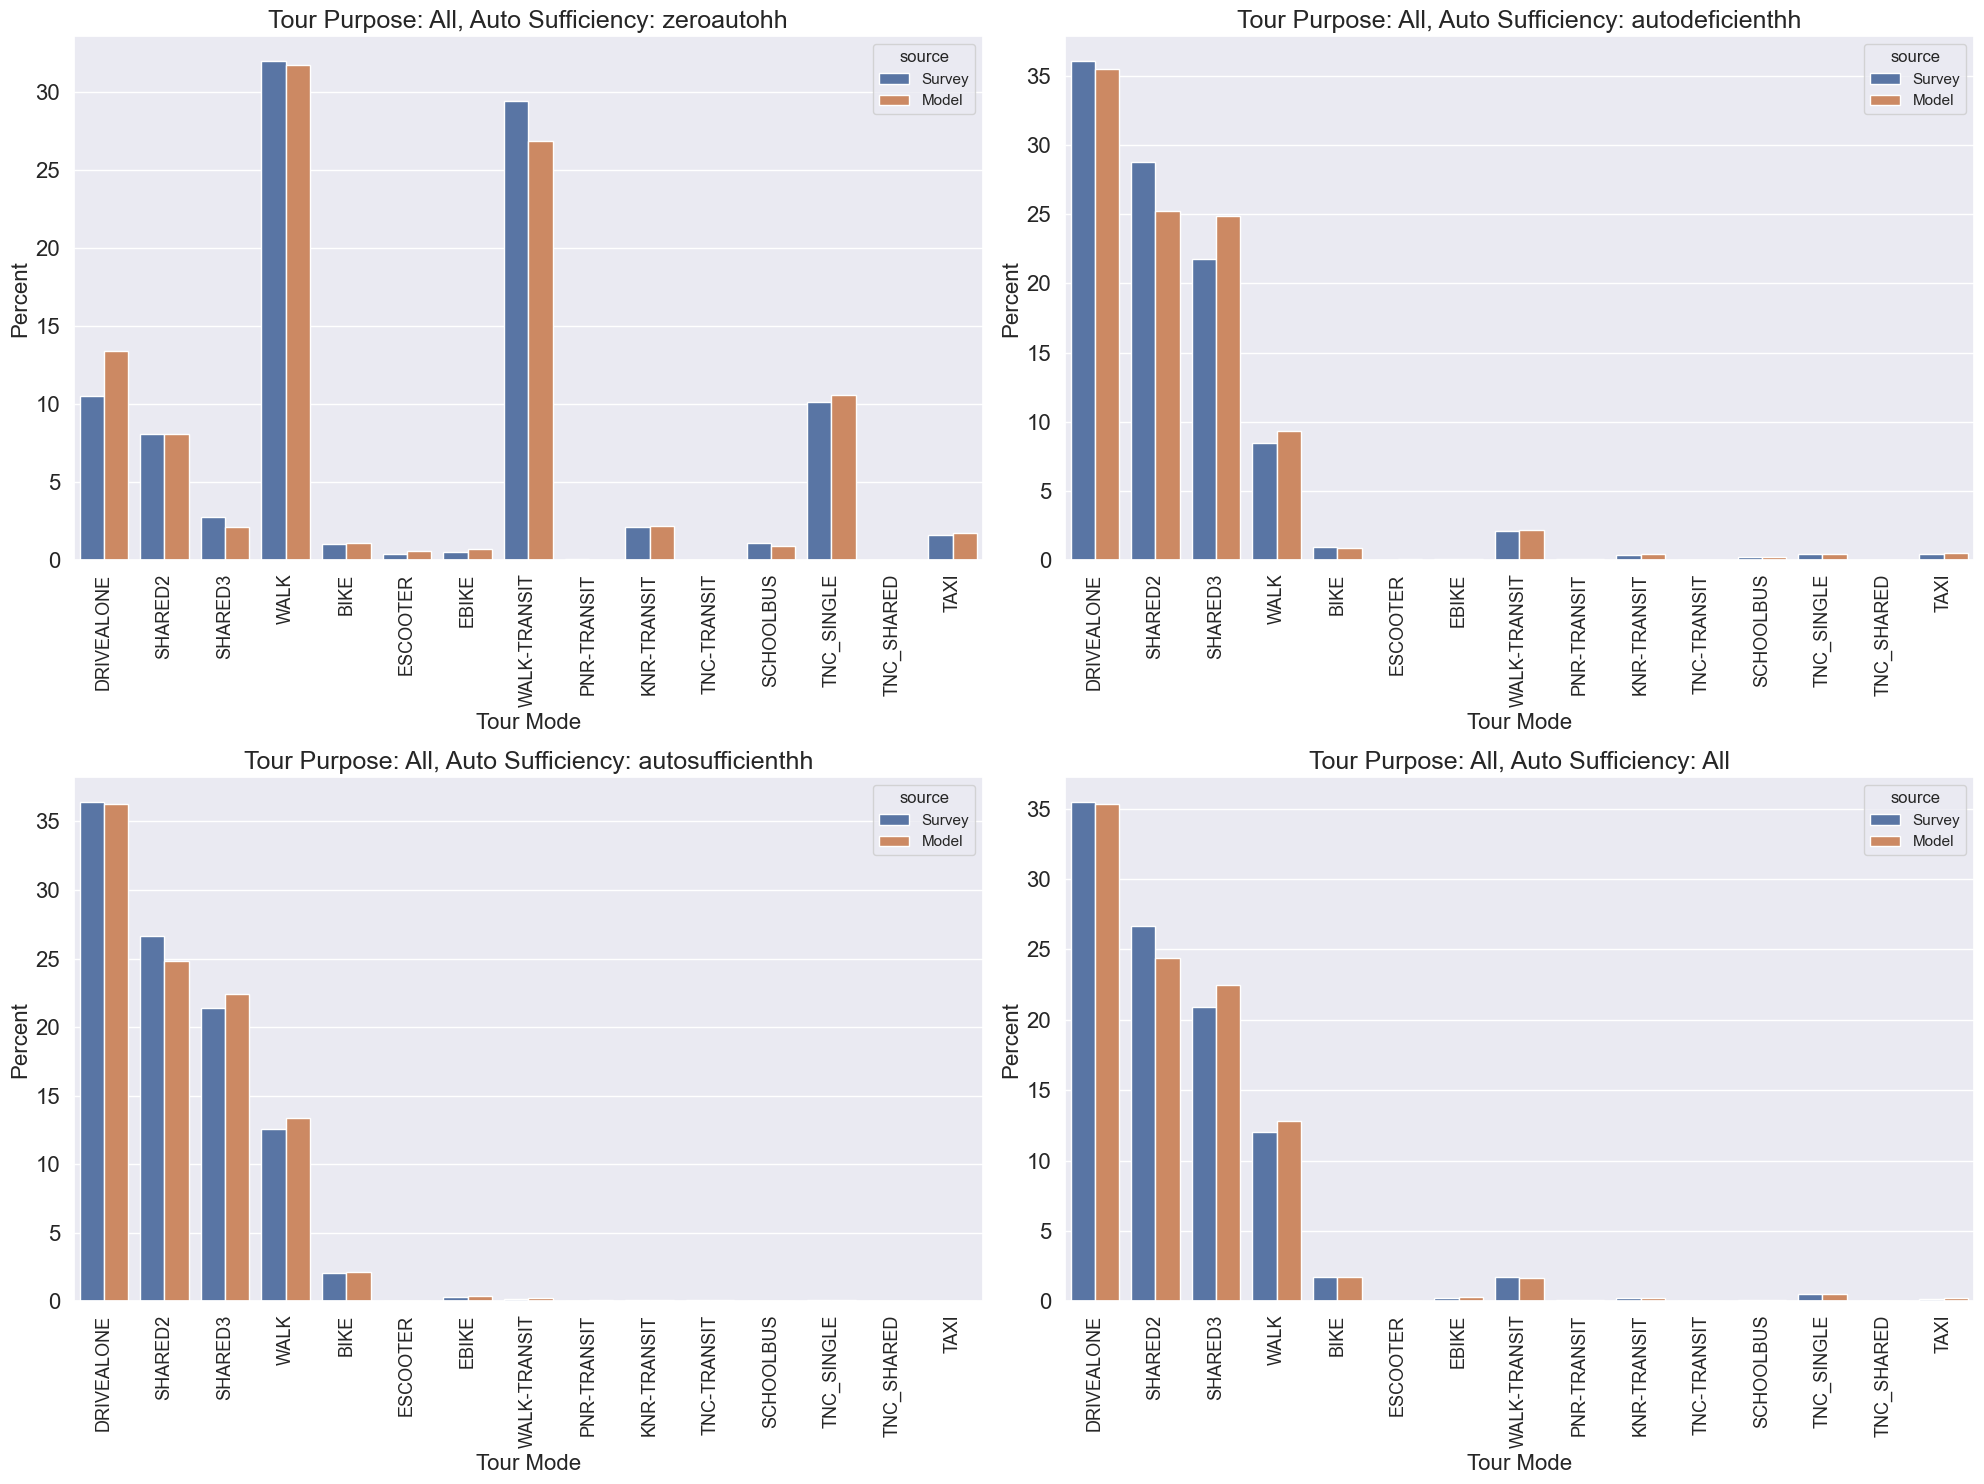

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 58 coefficients adjusted
	 699 coefficients converged
	 58 coefficients not converged


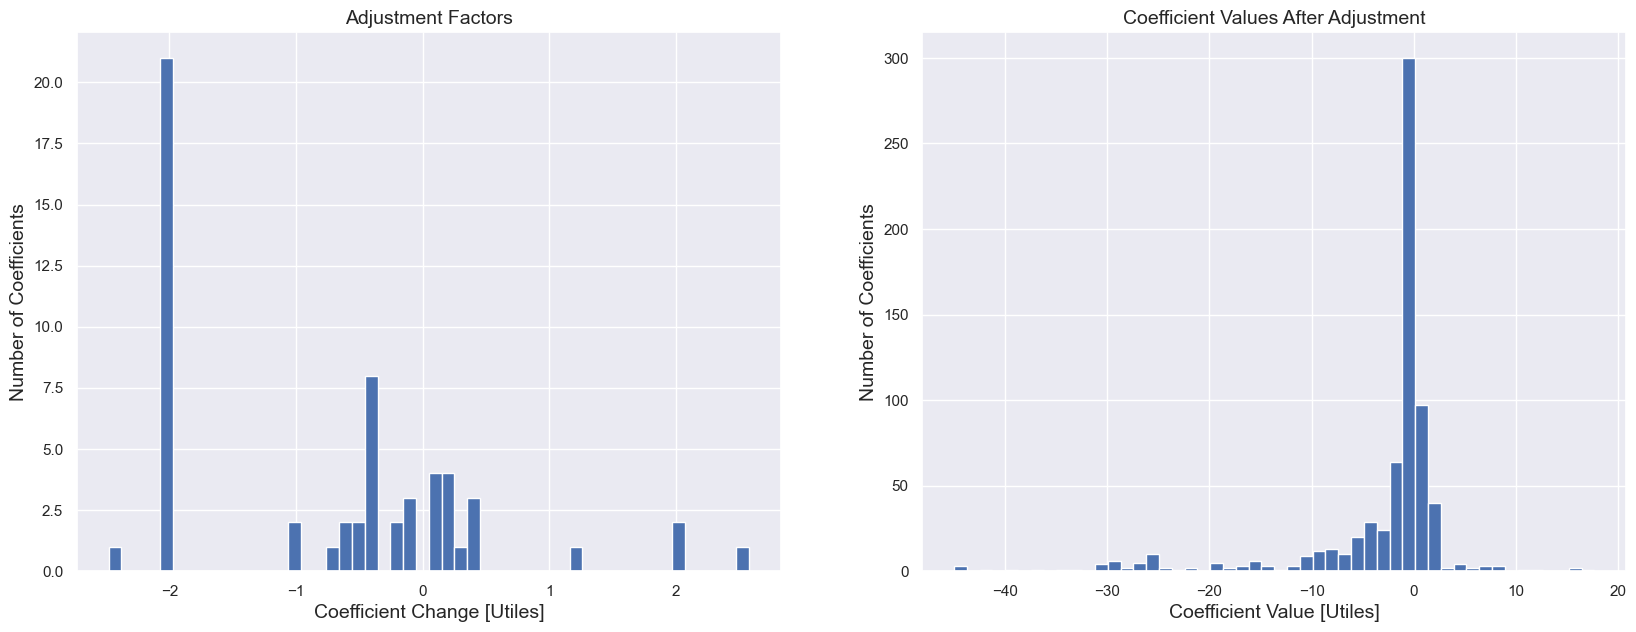

Top 10 largest coefficients:


coefficient_name      value  \
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -45.000000   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -45.000000   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -45.000000   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -42.154493   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -36.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -34.246255   
519  coef_calib_autodeficienthhind_WALK_TRANSIT_school -31.716434   
503       coef_calib_zeroautohhindivtou_SHARED2_school -31.000000   
655        coef_calib_zeroautohhjointtou_SHARED3_maint -29.000000   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -30.970666   

     model_counts  target_counts coef_change  new_value  converged  
540          64.0            0.0        <NA> -45.000000       True  
541          40.0            0.0        <NA> -45.000000       True  
543          40.0            0.0        <NA> -45.000000       True  
544          72.0           29.0        <NA> -42.154493       True  
698         104.0            0.0          -2 -38.875688      False  
695         124.0            0.0          -2 -36.246255      False  
519         263.0           22.0   -2.481112 -34.197546      False  
503         311.0            0.0          -2 -33.000000      False  
655         124.0            0.0          -2 -31.000000      False  
676          12.0            0.0        <NA> -30.970666       True

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_14
ActivitySim run started at:  2023-09-14 16:11:56.297978
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-14 16:59:30.777037
Run Time:  2854.48 secs =  47.574666666666666  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.yticks(fontsize=16)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: 

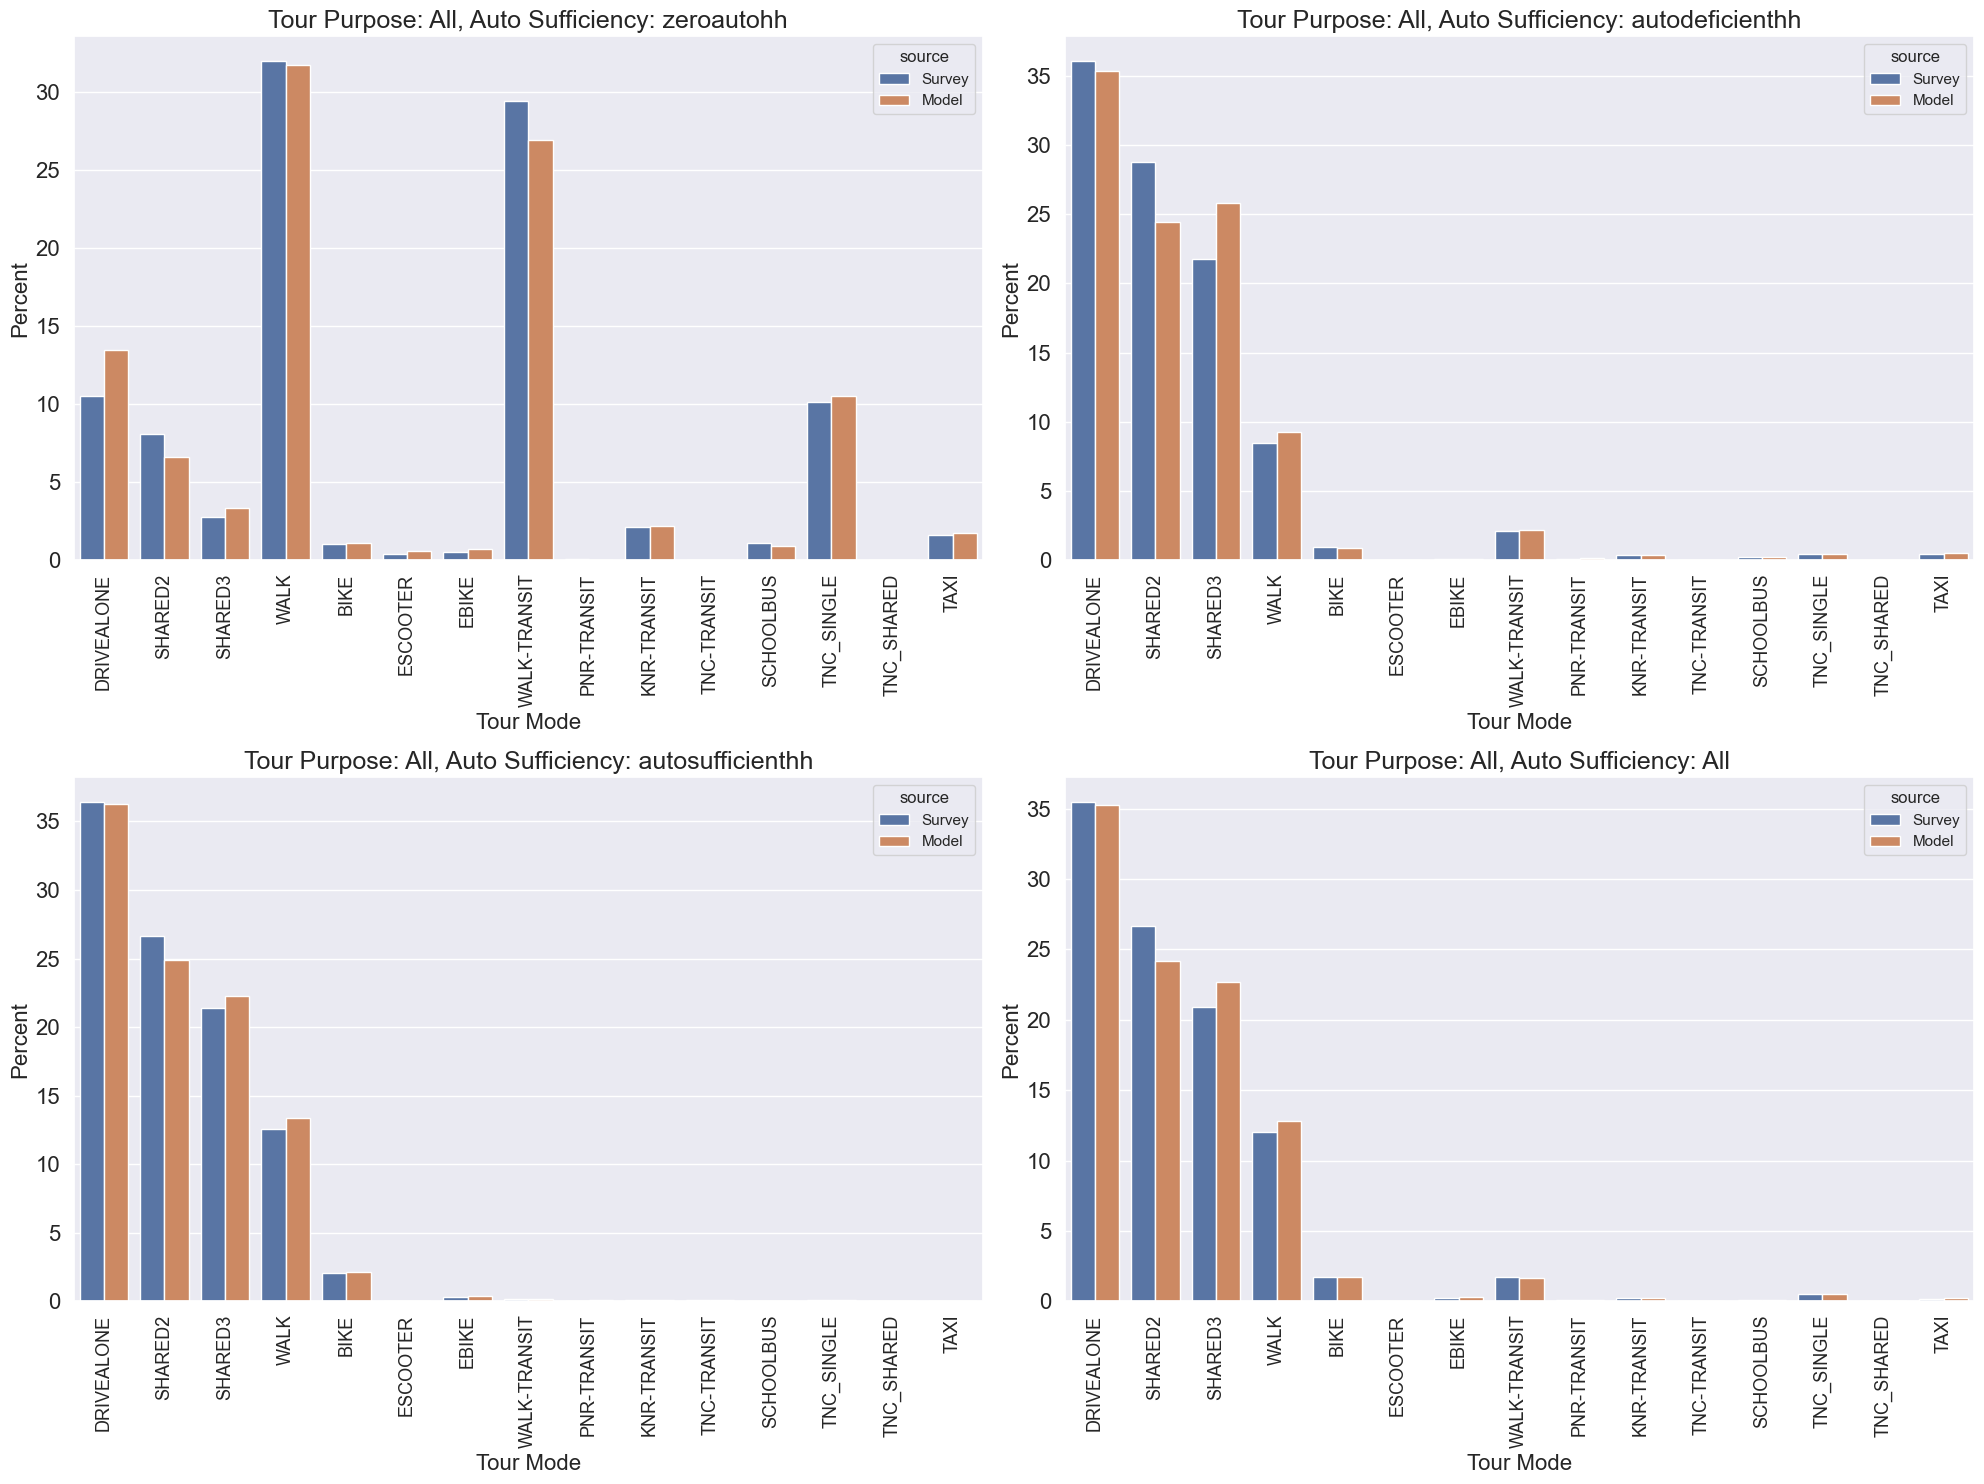

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 54 coefficients adjusted
	 703 coefficients converged
	 54 coefficients not converged


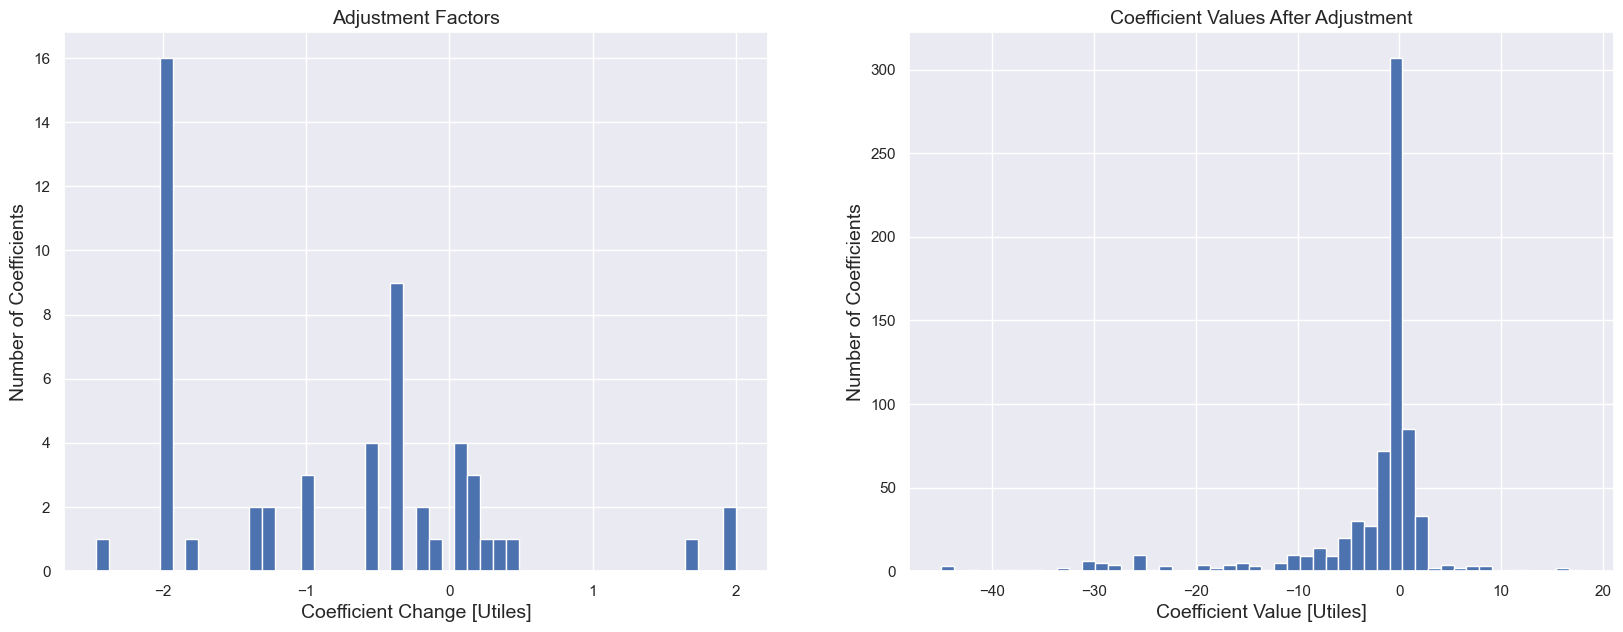

Top 10 largest coefficients:


coefficient_name      value  \
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -45.000000   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -45.000000   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -45.000000   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -42.154493   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -38.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -36.246255   
519  coef_calib_autodeficienthhind_WALK_TRANSIT_school -34.197546   
503       coef_calib_zeroautohhindivtou_SHARED2_school -33.000000   
655        coef_calib_zeroautohhjointtou_SHARED3_maint -31.000000   
677     coef_calib_autodeficienthhjoi_TNC_SHARED_maint -30.970666   

     model_counts  target_counts coef_change  new_value  converged  
540          68.0            0.0        <NA> -45.000000       True  
541          40.0            0.0        <NA> -45.000000       True  
543          36.0            0.0        <NA> -45.000000       True  
544          76.0           29.0        <NA> -42.154493       True  
698          76.0            0.0        <NA> -38.875688       True  
695         112.0            0.0          -2 -38.246255      False  
519         259.0           22.0   -2.465786 -36.663331      False  
503         243.0            0.0          -2 -35.000000      False  
655         112.0            0.0          -2 -33.000000      False  
677         112.0            0.0          -2 -32.970666      False

creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_15
ActivitySim run started at:  2023-09-14 17:00:05.523747
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-14 17:49:21.887244
Run Time:  2956.36 secs =  49.272666666666666  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.yticks(fontsize=16)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: 

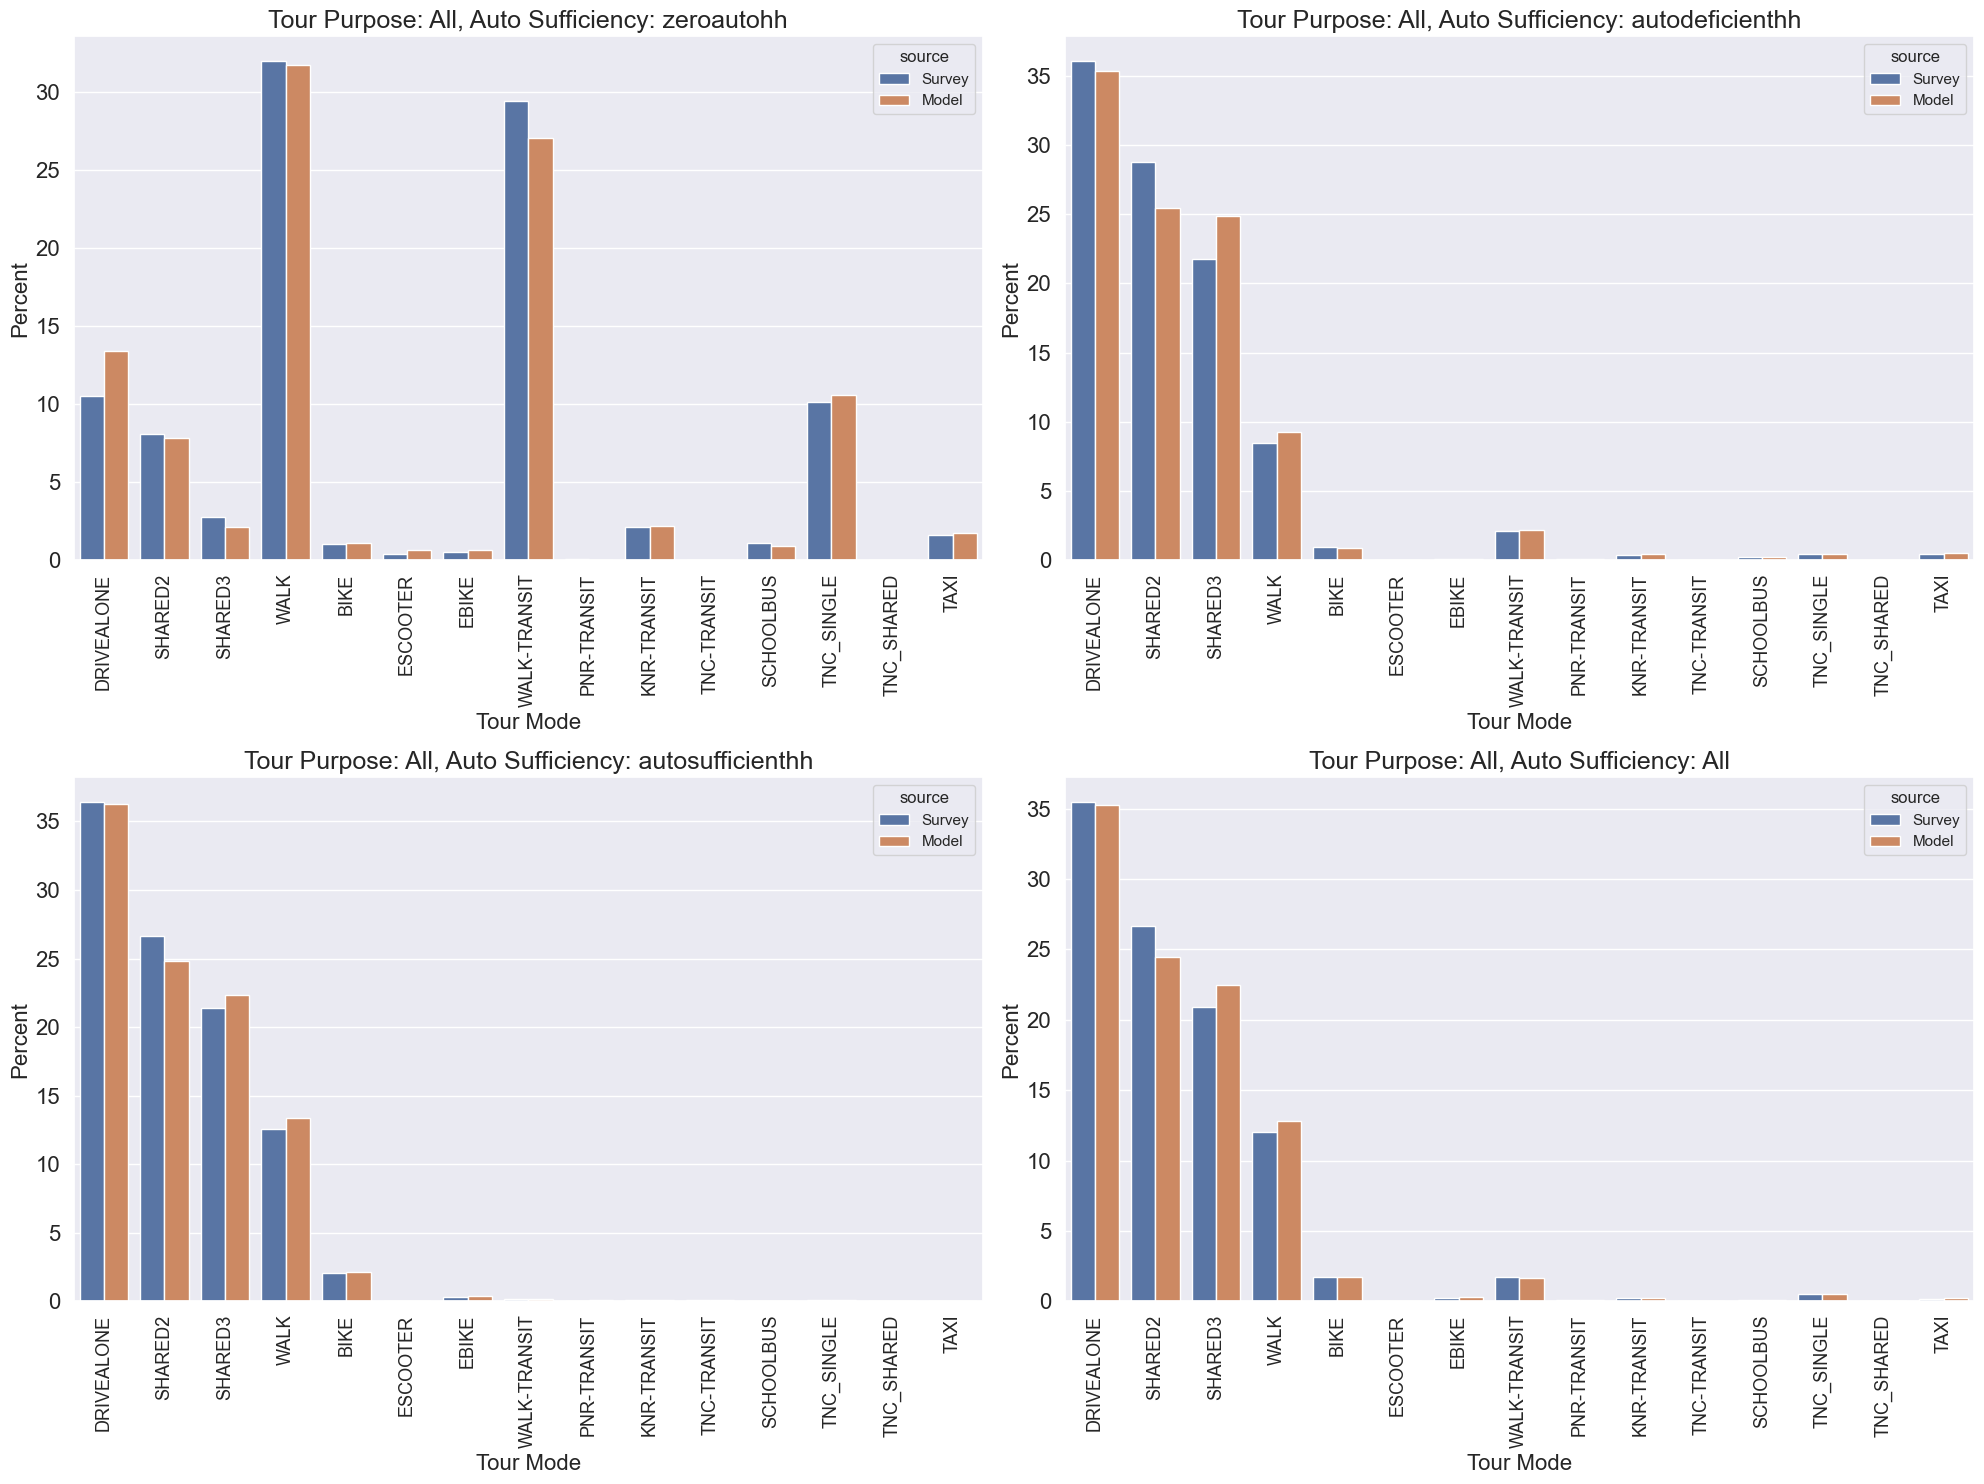

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 56 coefficients adjusted
	 701 coefficients converged
	 56 coefficients not converged


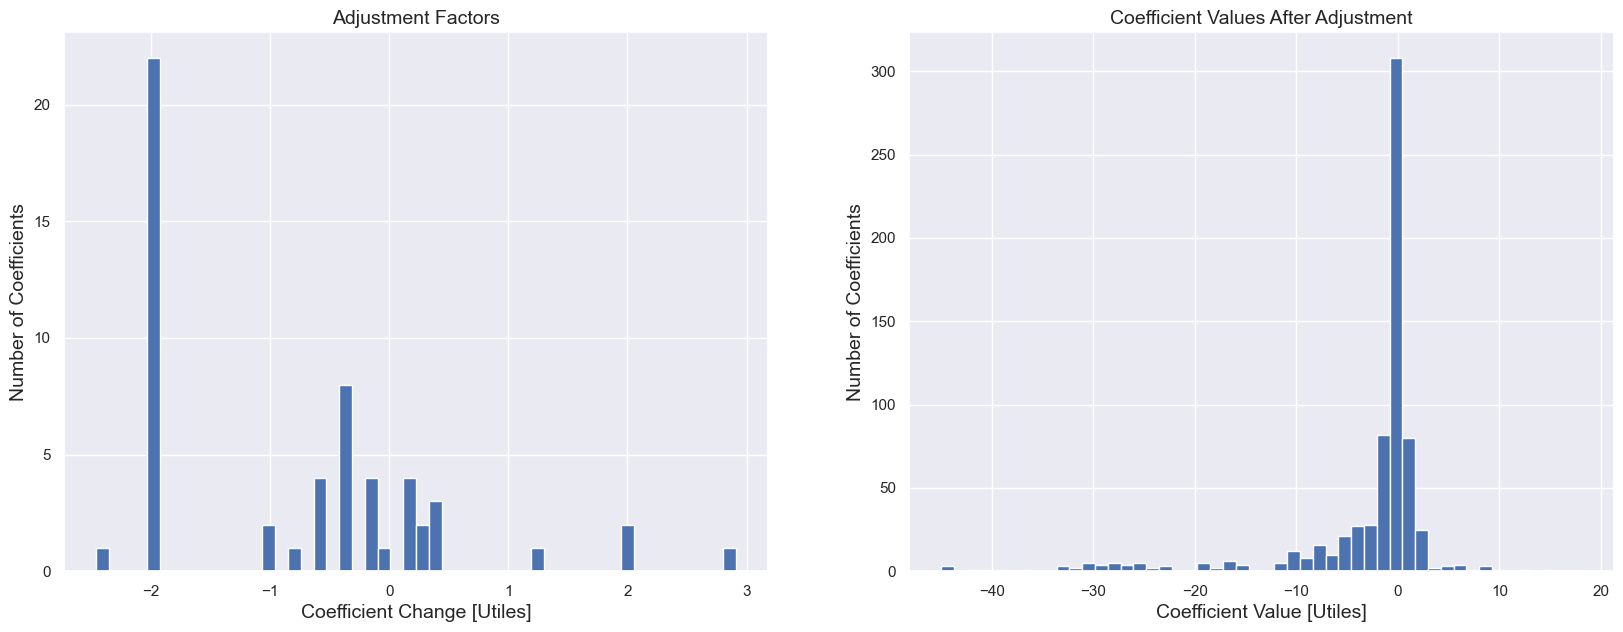

Top 10 largest coefficients:


coefficient_name      value  \
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -45.000000   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -45.000000   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -45.000000   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -42.154493   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -38.875688   
519  coef_calib_autodeficienthhind_WALK_TRANSIT_school -36.663331   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -38.246255   
503       coef_calib_zeroautohhindivtou_SHARED2_school -35.000000   
655        coef_calib_zeroautohhjointtou_SHARED3_maint -33.000000   
676     coef_calib_autodeficienthhjoi_TNC_SINGLE_maint -30.970666   

     model_counts  target_counts coef_change  new_value  converged  
540          64.0            0.0        <NA> -45.000000       True  
541          40.0            0.0        <NA> -45.000000       True  
543          36.0            0.0        <NA> -45.000000       True  
544          76.0           29.0        <NA> -42.154493       True  
698         127.0            0.0          -2 -40.875688      False  
519         259.0           22.0   -2.465786 -39.129117      False  
695          84.0            0.0        <NA> -38.246255       True  
503         311.0            0.0          -2 -37.000000      False  
655          84.0            0.0        <NA> -33.000000       True  
676         112.0            0.0          -2 -32.970666      False



 Final coefficient table written to:  C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_15\tour_mode_choice_coefficients.csv


In [72]:
calibration_iterations_to_run = 5
start_iter_num = 11

for i in range(start_iter_num, start_iter_num + calibration_iterations_to_run):
    asim_calib_util.run_activitysim(
        data_dir=data_dir,  # data inputs for ActivitySim
        configs_resident_dir=configs_resident_dir,  # these files are copied to the config section of the run directory
        configs_common_dir=configs_common_dir,  # just the location of the common config, these files will be used from the original location
        run_dir=activitysim_run_dir,  # ActivitySim run directory
        output_dir=iteration_output_dir,  # location to store run model outputs
        settings_file=warm_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
        tour_mc_coef_file=tour_mc_coef_file  # optional: tour_mode_choice_coefficients.csv to replace the one in configs_dir
    )
    
    _ = asim_calib_util.perform_tour_mode_choice_model_calibration(
        asim_output_dir=iteration_output_dir, # folder containing the activitysim model output
        asim_configs_dir=os.path.join(activitysim_run_dir, 'configs'),  # folder containing activitysim tour mode choice config files
        tour_mode_choice_calib_targets_file=tour_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  # maximum allowed adjustment per iteration
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=iteration_output_dir,  # location to write model calibration steps
    )
    tour_mc_coef_file = os.path.join(iteration_output_dir, 'tour_mode_choice_coefficients.csv')
    iteration_output_dir = iteration_output_dir.strip('_'+str(i)) + '_' + str(i+1)

print("\n\n", "Final coefficient table written to: ", tour_mc_coef_file)

In [76]:
tour_mc_coef_file = r'C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_15\tour_mode_choice_coefficients_UPDATED.csv'
iteration_output_dir = r'C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_16'

print(tour_mc_coef_file)
print(iteration_output_dir)

C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_15\tour_mode_choice_coefficients_UPDATED.csv
C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_16


creating output_dir at C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_16
ActivitySim run started at:  2023-09-14 23:16:38.259320
python simulation.py -s C:\abm_runs\rohans\calibration\tour_mc\scripts\settings_mp_warm_start.yaml -c C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir\configs -c C:\abm_runs\rohans\configs\common -d C:\abm_runs\rohans\input_2022 -o C:\abm_runs\rohans\calibration\tour_mc\output\activitysim_run_dir
ActivitySim ended at 2023-09-15 00:02:47.553829
Run Time:  2769.29 secs =  46.154833333333336  mins
Sample rate of  0.251 results in  857925 out of 3418027 tours


c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:516: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor = ((model_tours - transit_calib_tours)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:481: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
c:\Users\rsirupa\.conda\envs\asim_baydag\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.yticks(fontsize=16)
c:\abm_runs\rohans\calibration\tour_mc\scripts\asim_calib_util.py:742: 

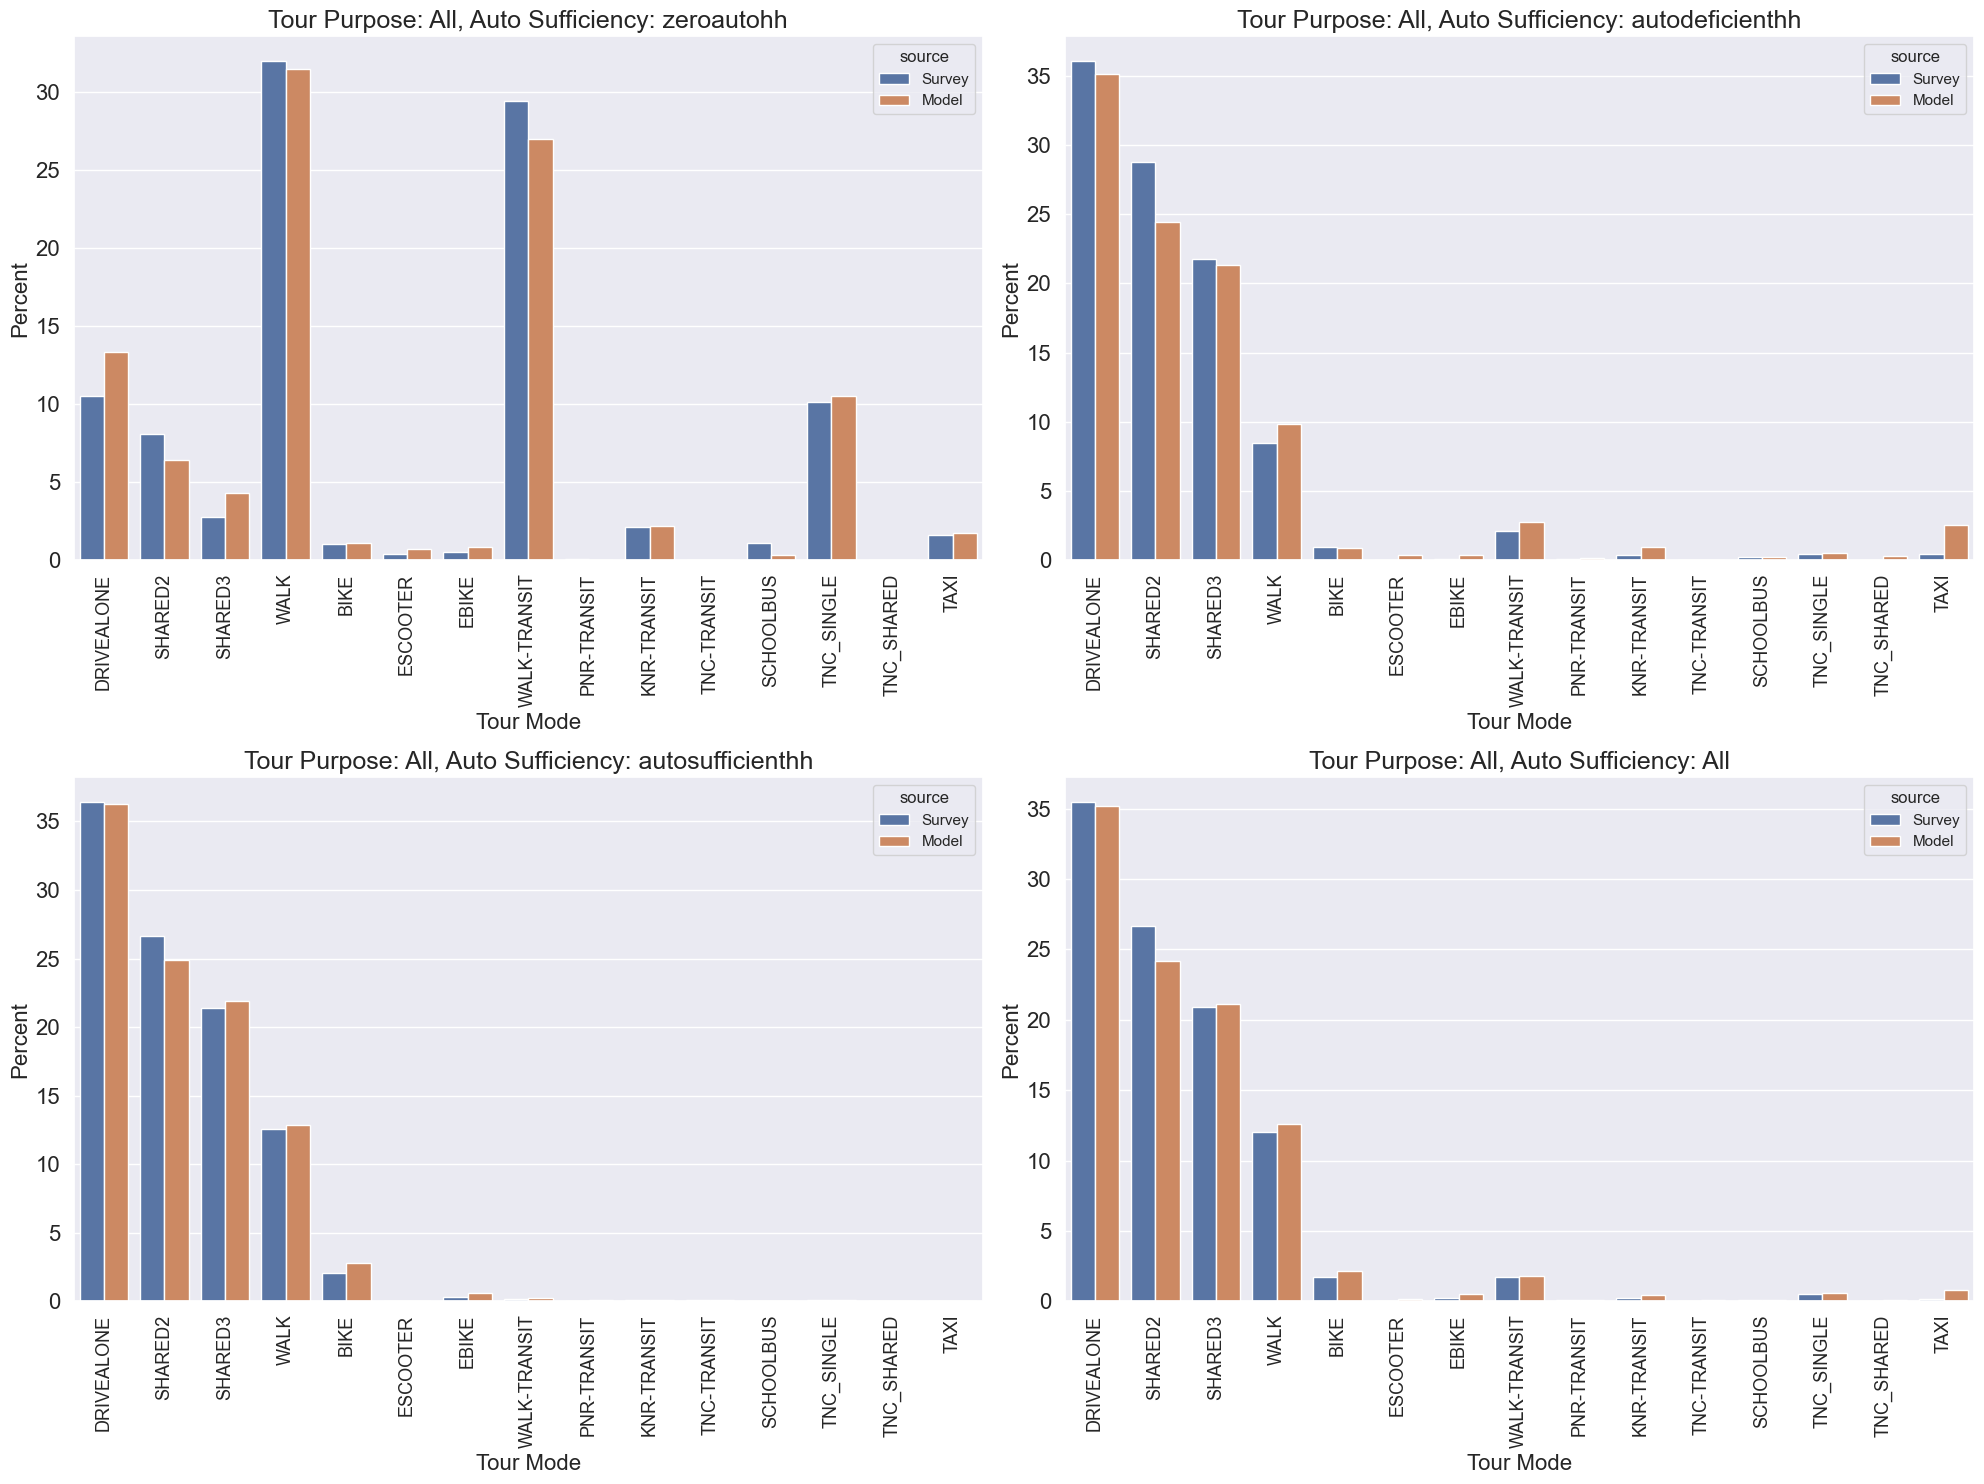

Coefficient Statistics: 
	 757 total coefficients
	 13 constrained coefficients
	 80 coefficients adjusted
	 677 coefficients converged
	 80 coefficients not converged


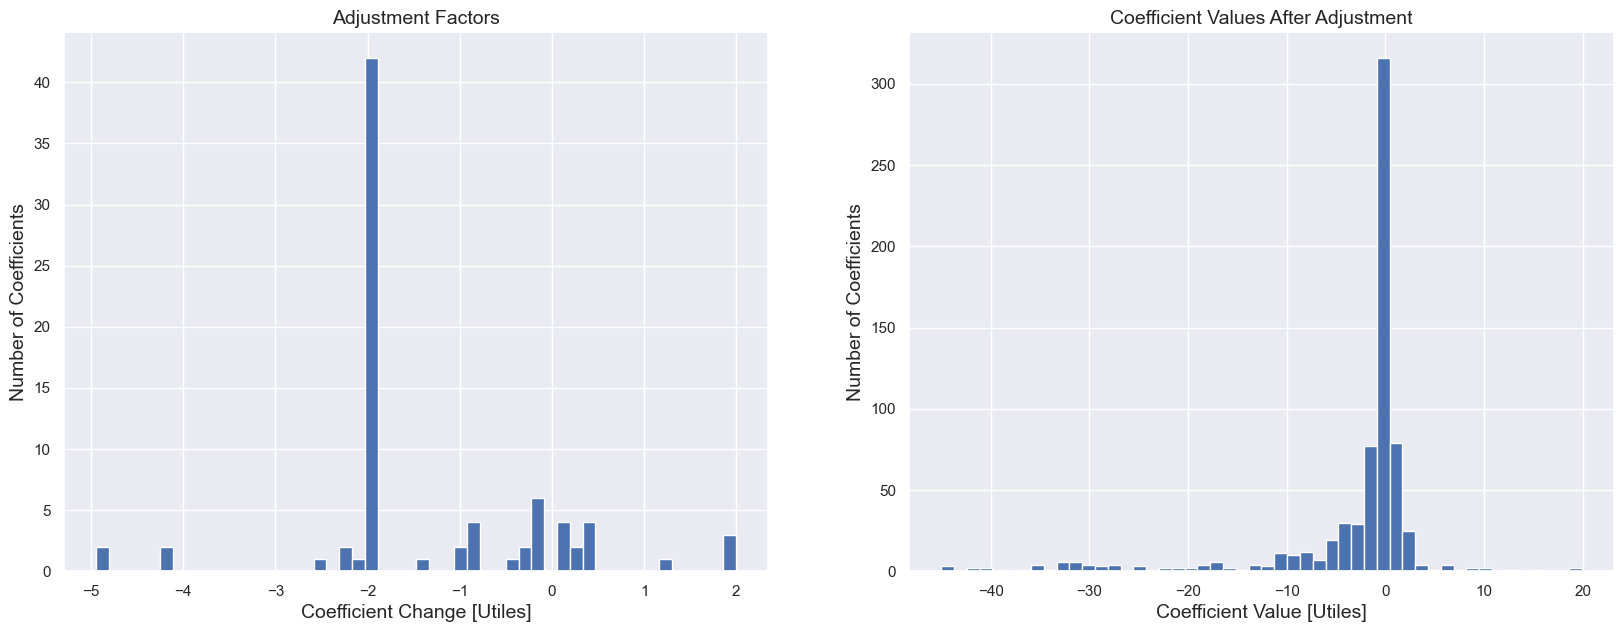

Top 10 largest coefficients:


coefficient_name      value  \
540       coef_calib_zeroautohhindivtou_SHARED2_atwork -45.000000   
541       coef_calib_zeroautohhindivtou_SHARED3_atwork -45.000000   
543          coef_calib_zeroautohhindivtou_BIKE_atwork -45.000000   
544  coef_calib_zeroautohhindivtou_WALK_TRANSIT_atwork -42.154493   
519  coef_calib_autodeficienthhind_WALK_TRANSIT_school -39.129117   
698    coef_calib_zeroautohhjointtou_WALK_TRANSIT_disc -40.875688   
695         coef_calib_zeroautohhjointtou_SHARED3_disc -38.246255   
503       coef_calib_zeroautohhindivtou_SHARED2_school -37.000000   
671   coef_calib_autodeficienthhjoi_WALK_TRANSIT_maint -31.048732   
696            coef_calib_zeroautohhjointtou_WALK_disc -35.000000   

     model_counts  target_counts coef_change  new_value  converged  
540          60.0            0.0        <NA> -45.000000       True  
541          40.0            0.0        <NA> -45.000000       True  
543          36.0            0.0        <NA> -45.000000       True  
544          76.0           29.0        <NA> -42.154493       True  
519         259.0           22.0   -2.465786 -41.594903      False  
698          92.0            0.0        <NA> -40.875688       True  
695         135.0            0.0          -2 -40.246255      False  
503         243.0            0.0          -2 -39.000000      False  
671        5916.0           42.0   -4.947746 -35.996478      False  
696        1307.0          576.0   -0.819382 -35.819382      False



 Final coefficient table written to:  C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_16\tour_mode_choice_coefficients.csv


In [77]:
calibration_iterations_to_run = 1
start_iter_num = 16

for i in range(start_iter_num, start_iter_num + calibration_iterations_to_run):
    asim_calib_util.run_activitysim(
        data_dir=data_dir,  # data inputs for ActivitySim
        configs_resident_dir=configs_resident_dir,  # these files are copied to the config section of the run directory
        configs_common_dir=configs_common_dir,  # just the location of the common config, these files will be used from the original location
        run_dir=activitysim_run_dir,  # ActivitySim run directory
        output_dir=iteration_output_dir,  # location to store run model outputs
        settings_file=warm_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
        tour_mc_coef_file=tour_mc_coef_file  # optional: tour_mode_choice_coefficients.csv to replace the one in configs_dir
    )
    
    _ = asim_calib_util.perform_tour_mode_choice_model_calibration(
        asim_output_dir=iteration_output_dir, # folder containing the activitysim model output
        asim_configs_dir=os.path.join(activitysim_run_dir, 'configs'),  # folder containing activitysim tour mode choice config files
        tour_mode_choice_calib_targets_file=tour_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  # maximum allowed adjustment per iteration
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=iteration_output_dir,  # location to write model calibration steps
    )
    tour_mc_coef_file = os.path.join(iteration_output_dir, 'tour_mode_choice_coefficients.csv')
    iteration_output_dir = iteration_output_dir.strip('_'+str(i)) + '_' + str(i+1)

print("\n\n", "Final coefficient table written to: ", tour_mc_coef_file)

In [78]:
print(tour_mc_coef_file)
print(iteration_output_dir)

C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_16\tour_mode_choice_coefficients.csv
C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_17


### GQ summary

In [56]:
# iteration_output_dir = r"C:\abm_runs\rohans\calibration\tour_mc\output\calibration_output_an_iter_9"

# ### read data
# tours = pd.read_csv(os.path.join(iteration_output_dir, 'final_tours.csv'))
# households = pd.read_csv(os.path.join(iteration_output_dir, 'final_households.csv'))

# ### calculate weights
# households['weight'] = 1/households['sample_rate']

# ### code auto sufficiency
# households['auto_suff'] = 0
# households.loc[(households.auto_ownership < households.num_adults)
#                     & (households.auto_ownership > 0), 'auto_suff'] = 1
# households.loc[(households.auto_ownership >= households.num_adults)
#                     & (households.auto_ownership > 0), 'auto_suff'] = 2

# ### code GQ
# households['is_GQ'] = 'GQ'
# households.loc[households['HHT'].isin([1, 2, 3, 4, 5, 6, 7]), 'is_GQ'] = 'Non-GQ'

# ### Add weight, auto_suff and GQ to tours
# tours = pd.merge(tours, households[['household_id', 'weight', 'auto_suff', 'is_GQ']], on='household_id', suffixes=('', '_x')).rename({'weight': 'model_tours'}, axis=1)

C:\Users\rsirupa\AppData\Local\Temp\9\ipykernel_193712\4111903590.py:4: DtypeWarning: Columns (15,16,20) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(iteration_output_dir, 'final_tours.csv'))


In [57]:
# ### Dictionary for renaming
# asim_to_calib_tour_mode_dict = {
#     'DRIVEALONE': 'DRIVEALONE',
#     'SHARED2': 'SHARED2',
#     'SHARED3': 'SHARED3',
#     'WALK': 'WALK',
#     'BIKE': 'BIKE',
#     'ESCOOTER': 'ESCOOTER',
#     'EBIKE': 'EBIKE',
#     'WALK_LOC': 'WALK-TRANSIT',
#     'WALK_PRM': 'WALK-TRANSIT',
#     'WALK_MIX': 'WALK-TRANSIT',
#     'PNR_LOC': 'PNR-TRANSIT',
#     'PNR_PRM': 'PNR-TRANSIT',
#     'PNR_MIX': 'PNR-TRANSIT',
#     'KNR_LOC': 'KNR-TRANSIT',
#     'KNR_PRM': 'KNR-TRANSIT',
#     'KNR_MIX': 'KNR-TRANSIT',
#     'TNC_LOC': 'TNC-TRANSIT',
#     'TNC_PRM': 'TNC-TRANSIT',
#     'TNC_MIX': 'TNC-TRANSIT',
#     'TAXI': 'TAXI',
#     'TNC_SINGLE': 'TNC_SINGLE',
#     'TNC_SHARED': 'TNC_SHARED',
#     'SCH_BUS': 'SCHOOLBUS'
# }

# asim_to_calib_purpose_dict = {
#     'work': 'work',
#     'univ': 'univ',
#     'school': 'school',
#     'shopping': 'ind_maint',  # individual split to joint in code
#     'escort': 'ind_maint',
#     'othmaint': 'ind_maint',
#     'social': 'ind_discr',
#     'eatout': 'ind_discr',
#     'othdiscr': 'ind_discr',
#     'atwork': 'atwork',
#     'eat': 'atwork',
#     'maint': 'atwork',
#     'business': 'atwork',
#     'all': 'All'
# }

# tours['grouped_tour_mode'] = tours['tour_mode'].map(asim_to_calib_tour_mode_dict)
# tours['purpose'] = tours['primary_purpose'].map(asim_to_calib_purpose_dict)

# ### Pivot table with GQ category
# tours_pivot_df = pd.pivot_table(tours, values='model_tours', index=['auto_suff', 'purpose', 'grouped_tour_mode'], columns='is_GQ', aggfunc=np.sum, margins=True).reset_index().round()
# tours_pivot_df.to_csv(r'C:\abm_runs\rohans\calibration\tour_mc\output\tours_pivot_with_gq.csv', index=False)
# tours_pivot_df